# Homework 2
In this homework, we will explore language generation using character-level RNNs. Sounds awesome, right???

A few notes at the beginning:
- It might be useful for you to read the whole assignment before beginning. Especially the last two sections so you know what to record for turning in.
- Much of the required knowledge in this (and past) homeworks about Python, PyTorch, etc. are not explained fully here. Instead, we expect you to use the existing documentation, search engines, Stack Overflow, etc. for implementation details.
- That being said, we have listed several functions in parts of the homework where knowing those functions exist would be especially useful. However you will still need to read the docs on how to specifically use the functions.

# Part 0: Initial setup
You should recognize this code from last time.


In [29]:
import torch
import math
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
  
# Running this should then print out:
# Version 1.7.0+cu101 (or something like this)
# CUDA enabled: True

Version 1.7.0+cu101
CUDA enabled: True


In [30]:
  from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
MyDrive  Shareddrives


# Part 1: Upload the dataset
We will be using the complete text of Harry Potter as our corpus. We will provide it for you in a not-very-well-formatted way.
Run this code to set up the homework3 files.



In [31]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/hw2/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = '/content/'

if not os.path.exists(os.path.join(DATA_PATH, 'harry_potter.txt')):
    os.chdir(BASE_PATH)
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
    !tar -zxvf homework3.tar.gz
    !rm homework3.tar.gz
    !cp pt_util.py /content
    !cp harry_potter.txt /content
os.chdir('/content')

In [32]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import pt_util

#Part 2: Preprocessing the data
In previous homeworks, we have provided a cleaned version of the data. But this time you'll have to do some of that cleaning yourselves.

Hints:
- train_text and test_text should contain the class indices for the character tokens from the data file. For example, if the text was **`"ABA CDBE"`**, the token version would be a numpy array with contents `[0, 1, 0, 2, 3, 4, 1, 5]`
- The harry_potter.txt file has weird spacing. You might want to replace all the whitespace characters (space, \n, \t, etc.) in the file with the space character.
- You should output two files. One for training and one for testing. The training should be the first 80% of the characters.
- voc2ind is a map from character to the index of the class for that character. There is no predefined vocabulary, but you will need to be consistent across all tasks that use the vocabulary. For the example above, the voc2ind would be `{'A': 0, 'B': 1, ' ': 2, 'C': 3, 'D': 4, 'E': 5}`
- ind2voc is the inverse of voc2ind



In [33]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [34]:
  def prepare_data(data_path):
    with open(data_path) as f:
      # This reads all the data from the file, but does not do any processing on it.
      data = f.read()
      # convert to lowercase

    # remove stop words - 
    # stops = set(stopwords.words("english"))
    # data = [w for w in data if not w in stops]
    # remove the spaces / weird lines 
    data = data.replace("\n", " ")
    data = data.replace("\t", " ")
    data = data.replace("\s", " ")


    # creates index for conversion of characters to numeric represtation for model
    voc2ind = {}  
    # alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz 0123456789.,;:\'\"!?&-~`$*-+=%[]{}^()_\/'
    # voc2ind = dict(zip(alphabet, range(0,len(alphabet))))


    # Compute voc2ind and transform the data into an integer representation of the tokens.
    index = 0
    for char in data:
      if char not in voc2ind:
        voc2ind[char] = index
        index += 1


    # maps the indext to the character - flips the voc2ind
    ind2voc = {val: key for key, val in voc2ind.items()}


    # Compute voc2ind and transform the data into an integer representation of the tokens.
    new_data = []
    for char in data:
      new_data.append(voc2ind.get(char))

    
    # 80% of the data into test and the remaining 20% into train 
    train_text = np.array(new_data[:int(len(data)*.8)])
    test_text = np.array(new_data[int(len(data)*.8):])

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

#Part 3: Loading the data
This is possibly the trickiest part of this homework. In the past, batches were not correlated with each other, and the data within a single minibatch was also not correlated, so you could basically draw randomly from the dataset. That is not the case here. Instead, you should return sequences from the dataset.

Your instructions are to implement the following. First, imagine splitting the dataset into N chunks where N is the batch_size and the chunks are contiguous parts of the data. For each batch, you should return one sequence from each of the chunks. The batches should also be sequential an example is described below.

The data is 20 characters long `[1, 2, 3, ...20]`. The batch size is `2` and the sequence length is `4`
- The 1st batch should consist of  `(data =  [[1, 2, 3, 4]; [11, 12, 13, 14]], labels = [[2, 3, 4, 5]; [12, 13, 14, 15]])`
- The 2nd batch should consist of `(data =  [[5, 6, 7, 8]; [15, 16, 17, 18]], labels = [[6, 7, 8, 9]; [16, 17, 18, 19]])`
- The 3rd batch should consist of `(data =  [[9]; [19]], labels = [[10]; [20]])`
- There is no 4th batch.

Hints:
- To work with the rest of the code, your len(dataset) should be a multiple of the batch_size. 
- Removing the last bit to make the data the proper shape will probably give better results than padding with 0s.
- It is OK to have one batch be shorter than the others as long as all entries in that batch are the same length.
- Notice that the last label in one batch is the first data in the next batch. Be careful of off-by-one errors.



In [35]:
class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)
        

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # TODO: Any preprocessing on the data to get it to the right shape.
        usable_len = math.floor(len(dataset['tokens']) / batch_size) * batch_size # new_len


        chunk_size = int(usable_len / batch_size) # len_subdivision
        
        # check for perfect match (cause issues with no label for last elem)
        # if chunk_size % sequence_length == 0 and usable_len == len(dataset['tokens']): 
        #   usable_len = usable_len - 1
        #   chunk_size = int(usable_len / batch_size) 


        # making batches now         
        # num_batches = (int)(chunk_size / sequence_length)
        self.len = math.ceil((float) (chunk_size-1)/sequence_length) * batch_size # num unique seq
        
        
        num_batches = (int)(chunk_size / self.batch_size)
        
        self.batches = [] # self.dataset_sorted
        # store batches
        # print(num_batches)
        # print(batch_size)
        # for i in range(num_batches):
        #   for j in range(batch_size): #same as num chunks
        #     data_label_pair = []
        #     curr_chunk = dataset['tokens'][j*chunk_size:chunk_size*(j+1)]
        #     data_label_pair.append(curr_chunk[i*sequence_length:sequence_length*(i+1)])
        #     data_label_pair.append(curr_chunk[i*sequence_length+1:sequence_length*(i+1)+1])
        #     self.batches.append(data_label_pair)
        for i in range((int) (self.len / self.batch_size)):
          for batch in range(self.batch_size):
            array = []
            for seq in range(self.sequence_length + 1):
              index = batch * chunk_size + i * self.sequence_length + seq
              if index < (batch + 1) * chunk_size:
                array.append(dataset['tokens'][index])
            self.batches.append(array)
       

    def __len__(self):
         return self.len 
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        
        data = self.batches[idx]
        return torch.LongTensor(data[:-1]), torch.LongTensor(data[1:])

    def vocab_size(self):
        return len(self.vocab)

In [36]:
testHPObj = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', 4, 2)
print(testHPObj.__getitem__(0))

(tensor([0, 1, 2, 2]), tensor([1, 2, 2, 3]))


# Part 4: Defining the Network
This time we will provide a network that should already get pretty good performance. You will still need to write the forward pass and inference functions. You may also choose to modify the network to try and get better performance.

__BE CAREFUL:__ We have specified that the data will be fed in as batch_first. Look at the documentation if you are confused about the implications of this as well as how to call it for the forward pass. https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    


In [37]:

TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.mid_size = int((feature_size - vocab_size) / 2)
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        self.linear_pass = nn.Linear(self.feature_size, self.feature_size)
        self.lstm = nn.LSTM(self.feature_size, self.feature_size, num_layers=2, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        # x = self.linear_pass(x)
        # x = F.relu(x)
        # x = self.linear_pass(x)
        x, hidden_state = self.gru(x, hidden_state)
        # x, hidden_state = self.lstm(x, hidden_state)
        # x = self.linear_pass(x)
        # x, hidden_state = self.gru2(x)
        x = self.decoder(x)
        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

#Part 5: Character Generation

In class we discussed three algorithms for creating sequences.
1. Max: Choose the most likely value
2. Sample: Sample from the distribution output by the network.
3. Beam Search: Sample from the distribution and use the Beam Search algorithm.

The beam search algorithm is as follows:
```
1. Initialize the beam list with the single existing empty beam
2. Repeat for the sequence length:
    1. For each beam in the beam list:
        1. Compute the next distribution over the output space for that state
        2. Sample from the distribution with replacement
        3. For each sample:
            1. Compute its score
            2. Record its hidden state and chosen value
        4. Add all the samples to the new beam list      
     2. Rank the new beam list
     3. Throw out all but the top N beams
 3. Return the top beam's chosen values.
```


Hints:
- np.random.choice and torch.multinomial will both help with the sampling as they can take in a weighted probability distribution and sample from that distribution.
- For beam search you will need to keep a running score of the likelihood of each sequence. If you multiply the likelihoods, you will encounter float underflow. Instead, you should add the log likelihoods.
- For beam search, you will need to keep track of multiple hidden states related to which branch you are currently expanding.
- For beam search, you should search over the beam, but only return the top result in the end.
- It may be useful to do the training part before the character generation part so you have some model to test.
- Feel free to play around with the `BEAM_WIDTH`.


In [38]:
TEMPERATURE = 0.1
BEAM_WIDTH = 10

import copy

def max_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
      max_val = torch.argmax(output)
      outputs.append(max_val)
      output, hidden = model.inference(max_val, hidden)
    return outputs
    
def sample_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
      max_val = np.random.choice(output.shape[1], 1, p=output.flatten().cpu().numpy())
      outputs.append(max_val[0])
      output, hidden = model.inference(torch.tensor(max_val[0]).to(device), hidden)
    return outputs

def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab):
    outputs = []
    beams = [([], output, hidden, 0)]
    for ii in range(sequence_length):
      new_beams = []
      for beam in beams:
        # first time
        if len(beam[0]) == 0:
          max_val = np.random.choice(output.shape[1], 1, p=output.flatten().cpu().numpy())
          output, hidden = model.inference(torch.tensor(max_val[0]).to(device), hidden)
        # every other time
        else:
          output, hidden = model.inference(torch.tensor(beam[0][-1]).to(device), beam[2])
        for n in range(beam_width):
          new_beam = list(copy.deepcopy(beam)) # maybe check l8r
          max_val = np.random.choice(output.shape[1], 1, p=output.flatten().cpu().numpy())
          new_beam[0].append(max_val[0])
          new_beam[1] = output
          new_beam[2] = hidden
          new_beam[3] = np.log(output.flatten().cpu().numpy()[max_val[0]])
          new_beams.append(tuple(new_beam))
      sorted(new_beams, key=lambda x: x[3])
      beams = new_beams[:beam_width]

    outputs = beams[0][0]
    return outputs


def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)
        
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab)


        return vocab.array_to_words(seed_words_arr.tolist() + outputs)


# Part 6: Training
Again, we are providing training code for you. Have a look at the train function though as it implements the exact forward approximate backward computation, which may be of interest to you. You will still need to add the perplexity computation (read more in part 9 about how to do this).

In [39]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

Using device cuda
num workers: 2
Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	IHuO!!;O!OB6*!P!!!B*!!!;fC4!WM/fT---iIu4TX9ZC!!!4!Sr;yHnM-BP!-!!!WW!=B=6uTy.!!ZXXXuu!!ITn=C!!PyfSMM.


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	-sCyr_!!!4!!ZNs!ZZC!!!!C-uBf--M-!GX4!K!uuOO.!W!/277Z4pB%*z!!yfS!;_fn=!zPy!!!s~r;tZh=[fS-/ZZZWuTT-P!!


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	f_y4!!y4!!ZNsK--*!yB6*!PyfSiZZ^%4-!-sCyff!yO9**M-!GX!!y4!WM.f;!y!!!!ZZZ!!ZX4!wu1^^O!!y4!--Z-uO4yW!/2


Input	 . .

  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 17.6627, Accuracy: 7212/1254400 (1%)



  1%|          | 1/196 [00:00<00:33,  5.78it/s]

Train Epoch: 0 [0/50176 (0%)]	Loss: 17.540794


  7%|▋         | 13/196 [00:01<00:16, 10.94it/s]

Train Epoch: 0 [2560/50176 (5%)]	Loss: 11.810439


 12%|█▏        | 23/196 [00:01<00:14, 12.31it/s]

Train Epoch: 0 [5120/50176 (10%)]	Loss: 6.439176


 17%|█▋        | 33/196 [00:02<00:13, 12.35it/s]

Train Epoch: 0 [7680/50176 (15%)]	Loss: 4.049669


 22%|██▏       | 43/196 [00:03<00:12, 12.31it/s]

Train Epoch: 0 [10240/50176 (20%)]	Loss: 2.960352


 27%|██▋       | 53/196 [00:04<00:11, 12.39it/s]

Train Epoch: 0 [12800/50176 (26%)]	Loss: 2.582462


 32%|███▏      | 63/196 [00:05<00:10, 12.38it/s]

Train Epoch: 0 [15360/50176 (31%)]	Loss: 2.449303


 37%|███▋      | 73/196 [00:05<00:09, 12.31it/s]

Train Epoch: 0 [17920/50176 (36%)]	Loss: 2.909679


 42%|████▏     | 83/196 [00:06<00:09, 12.34it/s]

Train Epoch: 0 [20480/50176 (41%)]	Loss: 2.977513


 47%|████▋     | 93/196 [00:07<00:08, 12.41it/s]

Train Epoch: 0 [23040/50176 (46%)]	Loss: 2.747025


 53%|█████▎    | 103/196 [00:08<00:07, 12.38it/s]

Train Epoch: 0 [25600/50176 (51%)]	Loss: 2.331107


 58%|█████▊    | 113/196 [00:09<00:06, 12.35it/s]

Train Epoch: 0 [28160/50176 (56%)]	Loss: 2.173985


 63%|██████▎   | 123/196 [00:10<00:05, 12.26it/s]

Train Epoch: 0 [30720/50176 (61%)]	Loss: 2.064239


 68%|██████▊   | 133/196 [00:10<00:05, 12.24it/s]

Train Epoch: 0 [33280/50176 (66%)]	Loss: 2.669370


 73%|███████▎  | 143/196 [00:11<00:04, 12.41it/s]

Train Epoch: 0 [35840/50176 (71%)]	Loss: 2.343045


 78%|███████▊  | 153/196 [00:12<00:03, 12.33it/s]

Train Epoch: 0 [38400/50176 (77%)]	Loss: 2.142176


 83%|████████▎ | 163/196 [00:13<00:02, 12.35it/s]

Train Epoch: 0 [40960/50176 (82%)]	Loss: 2.023329


 88%|████████▊ | 173/196 [00:14<00:01, 12.41it/s]

Train Epoch: 0 [43520/50176 (87%)]	Loss: 1.886554


 93%|█████████▎| 183/196 [00:14<00:01, 12.27it/s]

Train Epoch: 0 [46080/50176 (92%)]	Loss: 1.923040


 98%|█████████▊| 193/196 [00:15<00:00, 12.39it/s]

Train Epoch: 0 [48640/50176 (97%)]	Loss: 2.077144


100%|██████████| 196/196 [00:15<00:00, 12.29it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	ney sis aoat oo bit aas r  autaule aoldemortiiav soauees sn sonh ."ie soodc,aom elf oner th ahe svse


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 woat aov sos sne  T  wiaisnl  aom. aoclong ilck ardssn o the sascnsiith a booiito Ho soreneledooo s


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	rh  and ses soll aiat ooe soiund in hhe  sikter ais.and se an oo aonei sas. aoioey ind sode i  suck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. efzed, but in inswever in Dible ucurinneves poings on the look," said Duble one over that Mund sorpout done innisweat and who ay once e gave a somethone han' the sonce something over han' in anone son



  2%|▏         | 3/196 [00:00<00:35,  5.38it/s]

Train Epoch: 1 [0/50176 (0%)]	Loss: 1.951509


  7%|▋         | 13/196 [00:01<00:18, 10.16it/s]

Train Epoch: 1 [2560/50176 (5%)]	Loss: 1.856631


 12%|█▏        | 23/196 [00:02<00:14, 11.92it/s]

Train Epoch: 1 [5120/50176 (10%)]	Loss: 1.940487


 17%|█▋        | 33/196 [00:02<00:13, 12.25it/s]

Train Epoch: 1 [7680/50176 (15%)]	Loss: 1.899093


 22%|██▏       | 43/196 [00:03<00:12, 12.39it/s]

Train Epoch: 1 [10240/50176 (20%)]	Loss: 1.768451


 27%|██▋       | 53/196 [00:04<00:11, 12.30it/s]

Train Epoch: 1 [12800/50176 (26%)]	Loss: 1.738370


 32%|███▏      | 63/196 [00:05<00:10, 12.29it/s]

Train Epoch: 1 [15360/50176 (31%)]	Loss: 1.733521


 37%|███▋      | 73/196 [00:06<00:09, 12.36it/s]

Train Epoch: 1 [17920/50176 (36%)]	Loss: 1.764663


 42%|████▏     | 83/196 [00:06<00:09, 12.35it/s]

Train Epoch: 1 [20480/50176 (41%)]	Loss: 1.818570


 47%|████▋     | 93/196 [00:07<00:08, 12.22it/s]

Train Epoch: 1 [23040/50176 (46%)]	Loss: 1.994478


 53%|█████▎    | 103/196 [00:08<00:07, 12.31it/s]

Train Epoch: 1 [25600/50176 (51%)]	Loss: 1.829731


 58%|█████▊    | 113/196 [00:09<00:06, 12.27it/s]

Train Epoch: 1 [28160/50176 (56%)]	Loss: 1.746140


 63%|██████▎   | 123/196 [00:10<00:05, 12.36it/s]

Train Epoch: 1 [30720/50176 (61%)]	Loss: 1.768521


 68%|██████▊   | 133/196 [00:10<00:05, 12.28it/s]

Train Epoch: 1 [33280/50176 (66%)]	Loss: 1.682929


 73%|███████▎  | 143/196 [00:11<00:04, 12.32it/s]

Train Epoch: 1 [35840/50176 (71%)]	Loss: 1.642592


 78%|███████▊  | 153/196 [00:12<00:03, 12.25it/s]

Train Epoch: 1 [38400/50176 (77%)]	Loss: 1.616014


 83%|████████▎ | 163/196 [00:13<00:02, 12.41it/s]

Train Epoch: 1 [40960/50176 (82%)]	Loss: 1.671863


 88%|████████▊ | 173/196 [00:14<00:01, 12.26it/s]

Train Epoch: 1 [43520/50176 (87%)]	Loss: 1.797231


 93%|█████████▎| 183/196 [00:14<00:01, 12.34it/s]

Train Epoch: 1 [46080/50176 (92%)]	Loss: 1.750191


 98%|█████████▊| 193/196 [00:15<00:00, 12.31it/s]

Train Epoch: 1 [48640/50176 (97%)]	Loss: 1.744345


100%|██████████| 196/196 [00:16<00:00, 12.21it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	uty aas aaat th tot tascrs aucause oeldemort tiv saaueed at aamh . ae haadc aim elf tuer th the tnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 whet ted bim hnea "  daaassld tim  aosling aack ardsatto the tascrsaath t saaanse he haaaweledooh t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	rh  tnd his faet aiat the baaund tn hhe  dakten tim and hefan ah tassy aam  aaioly asd Hadp y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar.  haven, was said Harry house the shouient neess was goding as blaked appeared it into his car snary saried answpared boliving and ergappared the to the rais and oved rass wroud and knowned fill time? 



  1%|          | 2/196 [00:00<00:37,  5.16it/s]

Train Epoch: 2 [0/50176 (0%)]	Loss: 1.705436


  6%|▌         | 12/196 [00:01<00:18, 10.05it/s]

Train Epoch: 2 [2560/50176 (5%)]	Loss: 1.610737


 11%|█         | 22/196 [00:01<00:14, 11.87it/s]

Train Epoch: 2 [5120/50176 (10%)]	Loss: 1.619218


 16%|█▋        | 32/196 [00:02<00:13, 12.26it/s]

Train Epoch: 2 [7680/50176 (15%)]	Loss: 1.621071


 21%|██▏       | 42/196 [00:03<00:12, 12.36it/s]

Train Epoch: 2 [10240/50176 (20%)]	Loss: 1.733601


 27%|██▋       | 52/196 [00:04<00:11, 12.34it/s]

Train Epoch: 2 [12800/50176 (26%)]	Loss: 1.670660


 32%|███▏      | 62/196 [00:05<00:10, 12.39it/s]

Train Epoch: 2 [15360/50176 (31%)]	Loss: 1.623932


 37%|███▋      | 72/196 [00:06<00:10, 12.33it/s]

Train Epoch: 2 [17920/50176 (36%)]	Loss: 1.601466


 42%|████▏     | 82/196 [00:06<00:09, 12.33it/s]

Train Epoch: 2 [20480/50176 (41%)]	Loss: 1.553291


 47%|████▋     | 92/196 [00:07<00:08, 12.37it/s]

Train Epoch: 2 [23040/50176 (46%)]	Loss: 1.545465


 52%|█████▏    | 102/196 [00:08<00:07, 12.37it/s]

Train Epoch: 2 [25600/50176 (51%)]	Loss: 1.572598


 57%|█████▋    | 112/196 [00:09<00:06, 12.28it/s]

Train Epoch: 2 [28160/50176 (56%)]	Loss: 1.570655


 62%|██████▏   | 122/196 [00:10<00:06, 12.27it/s]

Train Epoch: 2 [30720/50176 (61%)]	Loss: 1.581631


 67%|██████▋   | 132/196 [00:10<00:05, 12.28it/s]

Train Epoch: 2 [33280/50176 (66%)]	Loss: 1.843627


 72%|███████▏  | 142/196 [00:11<00:04, 12.38it/s]

Train Epoch: 2 [35840/50176 (71%)]	Loss: 1.638940


 78%|███████▊  | 152/196 [00:12<00:03, 12.34it/s]

Train Epoch: 2 [38400/50176 (77%)]	Loss: 1.606457


 83%|████████▎ | 162/196 [00:13<00:02, 12.34it/s]

Train Epoch: 2 [40960/50176 (82%)]	Loss: 1.578898


 88%|████████▊ | 172/196 [00:14<00:01, 12.32it/s]

Train Epoch: 2 [43520/50176 (87%)]	Loss: 1.536138


 93%|█████████▎| 182/196 [00:14<00:01, 12.33it/s]

Train Epoch: 2 [46080/50176 (92%)]	Loss: 1.561238


 98%|█████████▊| 192/196 [00:15<00:00, 12.36it/s]

Train Epoch: 2 [48640/50176 (97%)]	Loss: 1.588298


100%|██████████| 196/196 [00:16<00:00, 12.20it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	u y aas aitt th tet aascr  aucause oeldemortaaad auauted tn aama . aa hlong aam elf iuer th the snge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 hhat aad aas hnm  "  aislsshd tam  arcl ng alck ard tnto tha aascr aalh a lieanse ha haaaweled oh h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dhe and has hiet aist tha sraund tn hha  aikten tam and hrean th tarri aam  ahiwly and hhdp y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. he magic and the Furge of than was right-into nice Magic, lark shary may had that are UGL^ grabble of the was of what says had as hapened had that aback ovil's or anythat, magical that to have around 



  1%|          | 2/196 [00:00<00:38,  5.09it/s]

Train Epoch: 3 [0/50176 (0%)]	Loss: 1.648532


  7%|▋         | 13/196 [00:01<00:17, 10.47it/s]

Train Epoch: 3 [2560/50176 (5%)]	Loss: 1.605387


 12%|█▏        | 23/196 [00:02<00:14, 11.97it/s]

Train Epoch: 3 [5120/50176 (10%)]	Loss: 1.578780


 17%|█▋        | 33/196 [00:02<00:13, 12.27it/s]

Train Epoch: 3 [7680/50176 (15%)]	Loss: 1.560876


 22%|██▏       | 43/196 [00:03<00:12, 12.29it/s]

Train Epoch: 3 [10240/50176 (20%)]	Loss: 1.549779


 27%|██▋       | 53/196 [00:04<00:11, 12.28it/s]

Train Epoch: 3 [12800/50176 (26%)]	Loss: 1.529687


 32%|███▏      | 63/196 [00:05<00:10, 12.36it/s]

Train Epoch: 3 [15360/50176 (31%)]	Loss: 1.521140


 37%|███▋      | 73/196 [00:06<00:09, 12.34it/s]

Train Epoch: 3 [17920/50176 (36%)]	Loss: 1.531019


 42%|████▏     | 83/196 [00:06<00:09, 12.33it/s]

Train Epoch: 3 [20480/50176 (41%)]	Loss: 1.490211


 47%|████▋     | 93/196 [00:07<00:08, 12.35it/s]

Train Epoch: 3 [23040/50176 (46%)]	Loss: 1.495564


 53%|█████▎    | 103/196 [00:08<00:07, 12.35it/s]

Train Epoch: 3 [25600/50176 (51%)]	Loss: 1.508799


 58%|█████▊    | 113/196 [00:09<00:06, 12.36it/s]

Train Epoch: 3 [28160/50176 (56%)]	Loss: 1.507203


 63%|██████▎   | 123/196 [00:10<00:05, 12.35it/s]

Train Epoch: 3 [30720/50176 (61%)]	Loss: 1.499982


 68%|██████▊   | 133/196 [00:10<00:05, 12.36it/s]

Train Epoch: 3 [33280/50176 (66%)]	Loss: 1.519485


 73%|███████▎  | 143/196 [00:11<00:04, 12.30it/s]

Train Epoch: 3 [35840/50176 (71%)]	Loss: 1.541714


 78%|███████▊  | 153/196 [00:12<00:03, 12.33it/s]

Train Epoch: 3 [38400/50176 (77%)]	Loss: 1.528332


 83%|████████▎ | 163/196 [00:13<00:02, 12.33it/s]

Train Epoch: 3 [40960/50176 (82%)]	Loss: 1.512044


 88%|████████▊ | 173/196 [00:14<00:01, 12.30it/s]

Train Epoch: 3 [43520/50176 (87%)]	Loss: 1.467476


 93%|█████████▎| 183/196 [00:15<00:01, 12.33it/s]

Train Epoch: 3 [46080/50176 (92%)]	Loss: 1.501366


 98%|█████████▊| 193/196 [00:15<00:00, 12.37it/s]

Train Epoch: 3 [48640/50176 (97%)]	Loss: 1.493668


100%|██████████| 196/196 [00:16<00:00, 12.19it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	ney ohs oott th tet thscr  aucause ioldemort wad nuaneed tn iomm . ae woong oim elf oner th the snge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 whet ted bem fnm  "t wislssed tim  aocl ng aeck ard tnto the siscr aith anlieanse oe hhhaneled oh t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dhe and tes fiet aist the sround tn hhe  wokten aim and seean to tonri aim  ahiwly and stdp y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Thank she opened." "But ahy own Harry doing the foot and she wooden it's in almother burstness, gave backon the didn't like and Priend and ruse in endsigent and he heave much was looking as though of 



  1%|          | 2/196 [00:00<00:37,  5.18it/s]

Train Epoch: 4 [0/50176 (0%)]	Loss: 1.490159


  6%|▌         | 12/196 [00:01<00:18,  9.97it/s]

Train Epoch: 4 [2560/50176 (5%)]	Loss: 1.464104


 11%|█         | 22/196 [00:01<00:14, 11.83it/s]

Train Epoch: 4 [5120/50176 (10%)]	Loss: 1.542427


 16%|█▋        | 32/196 [00:02<00:13, 12.25it/s]

Train Epoch: 4 [7680/50176 (15%)]	Loss: 1.557249


 21%|██▏       | 42/196 [00:03<00:12, 12.28it/s]

Train Epoch: 4 [10240/50176 (20%)]	Loss: 1.489377


 27%|██▋       | 52/196 [00:04<00:11, 12.34it/s]

Train Epoch: 4 [12800/50176 (26%)]	Loss: 1.470216


 32%|███▏      | 62/196 [00:05<00:10, 12.33it/s]

Train Epoch: 4 [15360/50176 (31%)]	Loss: 1.473245


 37%|███▋      | 72/196 [00:06<00:10, 12.31it/s]

Train Epoch: 4 [17920/50176 (36%)]	Loss: 1.471696


 42%|████▏     | 82/196 [00:06<00:09, 12.28it/s]

Train Epoch: 4 [20480/50176 (41%)]	Loss: 1.439765


 47%|████▋     | 92/196 [00:07<00:08, 12.35it/s]

Train Epoch: 4 [23040/50176 (46%)]	Loss: 1.443906


 52%|█████▏    | 102/196 [00:08<00:07, 12.34it/s]

Train Epoch: 4 [25600/50176 (51%)]	Loss: 1.474660


 57%|█████▋    | 112/196 [00:09<00:06, 12.31it/s]

Train Epoch: 4 [28160/50176 (56%)]	Loss: 1.460511


 62%|██████▏   | 122/196 [00:10<00:05, 12.34it/s]

Train Epoch: 4 [30720/50176 (61%)]	Loss: 1.457854


 67%|██████▋   | 132/196 [00:10<00:05, 12.29it/s]

Train Epoch: 4 [33280/50176 (66%)]	Loss: 1.442672


 72%|███████▏  | 142/196 [00:11<00:04, 12.32it/s]

Train Epoch: 4 [35840/50176 (71%)]	Loss: 1.454614


 78%|███████▊  | 152/196 [00:12<00:03, 12.36it/s]

Train Epoch: 4 [38400/50176 (77%)]	Loss: 1.443839


 83%|████████▎ | 162/196 [00:13<00:02, 12.36it/s]

Train Epoch: 4 [40960/50176 (82%)]	Loss: 1.468827


 88%|████████▊ | 172/196 [00:14<00:01, 12.32it/s]

Train Epoch: 4 [43520/50176 (87%)]	Loss: 1.427414


 93%|█████████▎| 182/196 [00:14<00:01, 12.34it/s]

Train Epoch: 4 [46080/50176 (92%)]	Loss: 1.477073


 98%|█████████▊| 192/196 [00:15<00:00, 12.35it/s]

Train Epoch: 4 [48640/50176 (97%)]	Loss: 1.497764


100%|██████████| 196/196 [00:16<00:00, 12.18it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y ohs oott th tit tiscr  tucause ioldemort sad nuaneed tn iomt . aa wlong oim elf oner th the snge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 whet ted bem fnm  "t wislssed tim  hoclong teck ard tnto the silcr tith ansieanse he hhhaneled oo t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	rh  and hes fiet aist the siound tn the  wotted tim and seean to ton i tam  atiwly and stdp y  tuck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. izaring him one, the minuts.  Professor Snape's onesten, while, it had never him deeping signs Alup. "Now, it's she liftenened to along at we diffed its black Well, it? Unod down it hair. HermineveUy'



  1%|          | 2/196 [00:00<00:37,  5.11it/s]

Train Epoch: 5 [0/50176 (0%)]	Loss: 1.482081


  6%|▌         | 12/196 [00:01<00:18,  9.94it/s]

Train Epoch: 5 [2560/50176 (5%)]	Loss: 1.454931


 11%|█         | 22/196 [00:01<00:14, 11.83it/s]

Train Epoch: 5 [5120/50176 (10%)]	Loss: 1.472101


 16%|█▋        | 32/196 [00:02<00:13, 12.26it/s]

Train Epoch: 5 [7680/50176 (15%)]	Loss: 1.445827


 21%|██▏       | 42/196 [00:03<00:12, 12.33it/s]

Train Epoch: 5 [10240/50176 (20%)]	Loss: 1.439346


 27%|██▋       | 52/196 [00:04<00:11, 12.32it/s]

Train Epoch: 5 [12800/50176 (26%)]	Loss: 1.450023


 32%|███▏      | 62/196 [00:05<00:10, 12.33it/s]

Train Epoch: 5 [15360/50176 (31%)]	Loss: 1.472832


 37%|███▋      | 72/196 [00:06<00:10, 12.33it/s]

Train Epoch: 5 [17920/50176 (36%)]	Loss: 1.465479


 42%|████▏     | 82/196 [00:06<00:09, 12.33it/s]

Train Epoch: 5 [20480/50176 (41%)]	Loss: 1.425529


 47%|████▋     | 92/196 [00:07<00:08, 12.34it/s]

Train Epoch: 5 [23040/50176 (46%)]	Loss: 1.419843


 52%|█████▏    | 102/196 [00:08<00:07, 12.31it/s]

Train Epoch: 5 [25600/50176 (51%)]	Loss: 1.438376


 57%|█████▋    | 112/196 [00:09<00:06, 12.33it/s]

Train Epoch: 5 [28160/50176 (56%)]	Loss: 1.435311


 62%|██████▏   | 122/196 [00:10<00:05, 12.34it/s]

Train Epoch: 5 [30720/50176 (61%)]	Loss: 1.431684


 67%|██████▋   | 132/196 [00:10<00:05, 12.30it/s]

Train Epoch: 5 [33280/50176 (66%)]	Loss: 1.414331


 72%|███████▏  | 142/196 [00:11<00:04, 12.35it/s]

Train Epoch: 5 [35840/50176 (71%)]	Loss: 1.419904


 78%|███████▊  | 152/196 [00:12<00:03, 12.33it/s]

Train Epoch: 5 [38400/50176 (77%)]	Loss: 1.416992


 83%|████████▎ | 162/196 [00:13<00:02, 12.32it/s]

Train Epoch: 5 [40960/50176 (82%)]	Loss: 1.471621


 88%|████████▊ | 172/196 [00:14<00:01, 12.04it/s]

Train Epoch: 5 [43520/50176 (87%)]	Loss: 1.468733


 93%|█████████▎| 182/196 [00:14<00:01, 12.28it/s]

Train Epoch: 5 [46080/50176 (92%)]	Loss: 1.465554


 98%|█████████▊| 192/196 [00:15<00:00, 12.32it/s]

Train Epoch: 5 [48640/50176 (97%)]	Loss: 1.449473


100%|██████████| 196/196 [00:16<00:00, 12.17it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	uey oas oott th sot tiscr  aucause ooldemort sad buaneed tn iomt . aa woong oim elf oner th the snge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 what ted bem hnm  "t wimlcsed tim  aocling aeck ard tnto the dolcr aith anltaanh  oe haaaweled oo s


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and hes saet aift the siound tn hhe  dokted aim and seean to tor i aam  ahiwly and shdp y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He They'm never I won't spud every can't got as good and Ron faint that the didn't secend in the Snape hast, he wondeed in hit tomor, the floorbable completely looked at across one that he had exharms



  2%|▏         | 3/196 [00:00<00:36,  5.35it/s]

Train Epoch: 6 [0/50176 (0%)]	Loss: 1.438914


  7%|▋         | 13/196 [00:01<00:18, 10.10it/s]

Train Epoch: 6 [2560/50176 (5%)]	Loss: 1.406906


 12%|█▏        | 23/196 [00:02<00:14, 11.87it/s]

Train Epoch: 6 [5120/50176 (10%)]	Loss: 1.439916


 17%|█▋        | 33/196 [00:02<00:13, 12.26it/s]

Train Epoch: 6 [7680/50176 (15%)]	Loss: 1.418272


 22%|██▏       | 43/196 [00:03<00:12, 12.30it/s]

Train Epoch: 6 [10240/50176 (20%)]	Loss: 1.413829


 27%|██▋       | 53/196 [00:04<00:11, 12.34it/s]

Train Epoch: 6 [12800/50176 (26%)]	Loss: 1.416174


 32%|███▏      | 63/196 [00:05<00:10, 12.33it/s]

Train Epoch: 6 [15360/50176 (31%)]	Loss: 1.417008


 37%|███▋      | 73/196 [00:06<00:09, 12.34it/s]

Train Epoch: 6 [17920/50176 (36%)]	Loss: 1.427484


 42%|████▏     | 83/196 [00:06<00:09, 12.12it/s]

Train Epoch: 6 [20480/50176 (41%)]	Loss: 1.403218


 47%|████▋     | 93/196 [00:07<00:08, 12.29it/s]

Train Epoch: 6 [23040/50176 (46%)]	Loss: 1.398569


 53%|█████▎    | 103/196 [00:08<00:07, 12.32it/s]

Train Epoch: 6 [25600/50176 (51%)]	Loss: 1.421008


 58%|█████▊    | 113/196 [00:09<00:06, 12.33it/s]

Train Epoch: 6 [28160/50176 (56%)]	Loss: 1.417777


 63%|██████▎   | 123/196 [00:10<00:05, 12.33it/s]

Train Epoch: 6 [30720/50176 (61%)]	Loss: 1.423642


 68%|██████▊   | 133/196 [00:10<00:05, 12.28it/s]

Train Epoch: 6 [33280/50176 (66%)]	Loss: 1.426934


 73%|███████▎  | 143/196 [00:11<00:04, 12.35it/s]

Train Epoch: 6 [35840/50176 (71%)]	Loss: 1.415986


 78%|███████▊  | 153/196 [00:12<00:03, 12.30it/s]

Train Epoch: 6 [38400/50176 (77%)]	Loss: 1.402749


 83%|████████▎ | 163/196 [00:13<00:02, 12.37it/s]

Train Epoch: 6 [40960/50176 (82%)]	Loss: 1.421748


 88%|████████▊ | 173/196 [00:14<00:01, 12.41it/s]

Train Epoch: 6 [43520/50176 (87%)]	Loss: 1.395048


 93%|█████████▎| 183/196 [00:15<00:01, 12.34it/s]

Train Epoch: 6 [46080/50176 (92%)]	Loss: 1.425422


 98%|█████████▊| 193/196 [00:15<00:00, 12.34it/s]

Train Epoch: 6 [48640/50176 (97%)]	Loss: 1.425237


100%|██████████| 196/196 [00:16<00:00, 12.19it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tas tott th sot tiscr  aucause holdemort wad buaneed tn iomt . aa woogg ois elf oner th the snge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 what hed bas hnm  "t wialased tim  aocling aack ard tnto the dalcr ahth anshaanh  oe waaawbled oo s


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and hes saet aiat the siound tn hhe  wokted ais wnd seean to tor i aam  ahiwly and shdp y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Vowered it," said Hermione.  "They try and jus!" said Harry, unarly helf sir, and of your staying warned him, Better," said Harry, Wood. Jaldered she same still burnnerking into ahead turenly. "All Fa



  1%|          | 2/196 [00:00<00:37,  5.11it/s]

Train Epoch: 7 [0/50176 (0%)]	Loss: 1.414622


  6%|▌         | 12/196 [00:01<00:18,  9.95it/s]

Train Epoch: 7 [2560/50176 (5%)]	Loss: 1.390782


 11%|█         | 22/196 [00:01<00:14, 11.85it/s]

Train Epoch: 7 [5120/50176 (10%)]	Loss: 1.433625


 16%|█▋        | 32/196 [00:02<00:13, 12.24it/s]

Train Epoch: 7 [7680/50176 (15%)]	Loss: 1.408049


 21%|██▏       | 42/196 [00:03<00:12, 12.32it/s]

Train Epoch: 7 [10240/50176 (20%)]	Loss: 1.409388


 27%|██▋       | 52/196 [00:04<00:11, 12.34it/s]

Train Epoch: 7 [12800/50176 (26%)]	Loss: 1.401526


 32%|███▏      | 62/196 [00:05<00:10, 12.33it/s]

Train Epoch: 7 [15360/50176 (31%)]	Loss: 1.418249


 37%|███▋      | 72/196 [00:06<00:10, 12.37it/s]

Train Epoch: 7 [17920/50176 (36%)]	Loss: 1.434371


 42%|████▏     | 82/196 [00:06<00:09, 12.32it/s]

Train Epoch: 7 [20480/50176 (41%)]	Loss: 1.402881


 47%|████▋     | 92/196 [00:07<00:08, 12.34it/s]

Train Epoch: 7 [23040/50176 (46%)]	Loss: 1.391653


 52%|█████▏    | 102/196 [00:08<00:07, 12.35it/s]

Train Epoch: 7 [25600/50176 (51%)]	Loss: 1.409243


 57%|█████▋    | 112/196 [00:09<00:06, 12.34it/s]

Train Epoch: 7 [28160/50176 (56%)]	Loss: 1.403427


 62%|██████▏   | 122/196 [00:10<00:05, 12.34it/s]

Train Epoch: 7 [30720/50176 (61%)]	Loss: 1.400991


 67%|██████▋   | 132/196 [00:10<00:05, 11.96it/s]

Train Epoch: 7 [33280/50176 (66%)]	Loss: 1.389472


 72%|███████▏  | 142/196 [00:11<00:04, 12.28it/s]

Train Epoch: 7 [35840/50176 (71%)]	Loss: 1.418983


 78%|███████▊  | 152/196 [00:12<00:03, 12.32it/s]

Train Epoch: 7 [38400/50176 (77%)]	Loss: 1.392380


 83%|████████▎ | 162/196 [00:13<00:02, 12.34it/s]

Train Epoch: 7 [40960/50176 (82%)]	Loss: 1.420603


 88%|████████▊ | 172/196 [00:14<00:01, 12.33it/s]

Train Epoch: 7 [43520/50176 (87%)]	Loss: 1.389047


 93%|█████████▎| 182/196 [00:14<00:01, 12.30it/s]

Train Epoch: 7 [46080/50176 (92%)]	Loss: 1.412428


 98%|█████████▊| 192/196 [00:15<00:00, 12.23it/s]

Train Epoch: 7 [48640/50176 (97%)]	Loss: 1.419008


100%|██████████| 196/196 [00:16<00:00, 12.16it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	  y tas tott th set thscr  aucause holdemort wad suaceed tn womt . aa woegg ois elf oner th the dnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 woat hed bas hnm  "t wemlased tim  hocling aack ard tnto the dalcr ahth a shaanh  oe waaawbled oo s


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  snd hes saet aift the dround tt hhe  wokeed ais wnd seean to tor i aam  ahiwly atd shdp y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Ih, gaah," said Mrs. Crough, Professor Nockhart socre crue. "No do you'," said Harry, which for had founded again. Harry repart. "He felt shocked, and Hermione, looking at live between Whiz--" Harry s



  1%|          | 2/196 [00:00<00:37,  5.19it/s]

Train Epoch: 8 [0/50176 (0%)]	Loss: 1.401534


  6%|▌         | 12/196 [00:01<00:18,  9.93it/s]

Train Epoch: 8 [2560/50176 (5%)]	Loss: 1.381202


 11%|█         | 22/196 [00:01<00:14, 11.84it/s]

Train Epoch: 8 [5120/50176 (10%)]	Loss: 1.414110


 16%|█▋        | 32/196 [00:02<00:13, 12.23it/s]

Train Epoch: 8 [7680/50176 (15%)]	Loss: 1.397427


 21%|██▏       | 42/196 [00:03<00:12, 12.32it/s]

Train Epoch: 8 [10240/50176 (20%)]	Loss: 1.399713


 27%|██▋       | 52/196 [00:04<00:11, 12.34it/s]

Train Epoch: 8 [12800/50176 (26%)]	Loss: 1.393059


 32%|███▏      | 62/196 [00:05<00:10, 12.32it/s]

Train Epoch: 8 [15360/50176 (31%)]	Loss: 1.397482


 37%|███▋      | 72/196 [00:06<00:10, 12.31it/s]

Train Epoch: 8 [17920/50176 (36%)]	Loss: 1.401393


 42%|████▏     | 82/196 [00:06<00:09, 12.32it/s]

Train Epoch: 8 [20480/50176 (41%)]	Loss: 1.370388


 47%|████▋     | 92/196 [00:07<00:08, 12.33it/s]

Train Epoch: 8 [23040/50176 (46%)]	Loss: 1.382704


 52%|█████▏    | 102/196 [00:08<00:07, 12.26it/s]

Train Epoch: 8 [25600/50176 (51%)]	Loss: 1.394169


 57%|█████▋    | 112/196 [00:09<00:06, 12.18it/s]

Train Epoch: 8 [28160/50176 (56%)]	Loss: 1.394685


 62%|██████▏   | 122/196 [00:10<00:06, 12.30it/s]

Train Epoch: 8 [30720/50176 (61%)]	Loss: 1.402820


 67%|██████▋   | 132/196 [00:10<00:05, 12.08it/s]

Train Epoch: 8 [33280/50176 (66%)]	Loss: 1.433129


 72%|███████▏  | 142/196 [00:11<00:04, 12.19it/s]

Train Epoch: 8 [35840/50176 (71%)]	Loss: 1.392913


 78%|███████▊  | 152/196 [00:12<00:03, 12.13it/s]

Train Epoch: 8 [38400/50176 (77%)]	Loss: 1.384962


 83%|████████▎ | 162/196 [00:13<00:02, 12.26it/s]

Train Epoch: 8 [40960/50176 (82%)]	Loss: 1.410897


 88%|████████▊ | 172/196 [00:14<00:01, 12.34it/s]

Train Epoch: 8 [43520/50176 (87%)]	Loss: 1.378943


 93%|█████████▎| 182/196 [00:15<00:01, 12.32it/s]

Train Epoch: 8 [46080/50176 (92%)]	Loss: 1.406350


 98%|█████████▊| 192/196 [00:15<00:00, 12.31it/s]

Train Epoch: 8 [48640/50176 (97%)]	Loss: 1.405161


100%|██████████| 196/196 [00:16<00:00, 12.13it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	  y ths tott th tot thscr  tucause holdemort wad buacted tn womt . He woeng ois elf oner th the dnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 woat hed bas hnm  "t wealased tim  hocling aack ard tnto the dalcr ahth a lhianh  oe whaawbled oo t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes haet aoat the dround tt hhe  wokeed tim wnd seean to tor i aam  ahiwly atd strp y  tuck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar.  SAR Snape cack8ard one the other hope of Hogwart on its plun, of both one of a loot into him. He tood mother joldemort had countled him to the class cold dayurs to deeb where ephand to the doors step



  1%|          | 2/196 [00:00<00:38,  5.07it/s]

Train Epoch: 9 [0/50176 (0%)]	Loss: 1.398203


  6%|▌         | 12/196 [00:01<00:18,  9.83it/s]

Train Epoch: 9 [2560/50176 (5%)]	Loss: 1.371735


 11%|█         | 22/196 [00:01<00:14, 11.84it/s]

Train Epoch: 9 [5120/50176 (10%)]	Loss: 1.411798


 16%|█▋        | 32/196 [00:02<00:13, 12.27it/s]

Train Epoch: 9 [7680/50176 (15%)]	Loss: 1.384389


 21%|██▏       | 42/196 [00:03<00:12, 12.32it/s]

Train Epoch: 9 [10240/50176 (20%)]	Loss: 1.374828


 27%|██▋       | 52/196 [00:04<00:11, 12.33it/s]

Train Epoch: 9 [12800/50176 (26%)]	Loss: 1.373070


 32%|███▏      | 62/196 [00:05<00:11, 12.08it/s]

Train Epoch: 9 [15360/50176 (31%)]	Loss: 1.384814


 37%|███▋      | 72/196 [00:06<00:10, 12.20it/s]

Train Epoch: 9 [17920/50176 (36%)]	Loss: 1.394575


 42%|████▏     | 82/196 [00:06<00:09, 12.34it/s]

Train Epoch: 9 [20480/50176 (41%)]	Loss: 1.368288


 47%|████▋     | 92/196 [00:07<00:08, 12.36it/s]

Train Epoch: 9 [23040/50176 (46%)]	Loss: 1.390453


 52%|█████▏    | 102/196 [00:08<00:07, 12.34it/s]

Train Epoch: 9 [25600/50176 (51%)]	Loss: 1.407026


 57%|█████▋    | 112/196 [00:09<00:06, 12.33it/s]

Train Epoch: 9 [28160/50176 (56%)]	Loss: 1.401391


 62%|██████▏   | 122/196 [00:10<00:06, 12.33it/s]

Train Epoch: 9 [30720/50176 (61%)]	Loss: 1.387174


 67%|██████▋   | 132/196 [00:10<00:05, 12.34it/s]

Train Epoch: 9 [33280/50176 (66%)]	Loss: 1.368523


 72%|███████▏  | 142/196 [00:11<00:04, 12.07it/s]

Train Epoch: 9 [35840/50176 (71%)]	Loss: 1.378880


 78%|███████▊  | 152/196 [00:12<00:03, 12.27it/s]

Train Epoch: 9 [38400/50176 (77%)]	Loss: 1.372434


 83%|████████▎ | 162/196 [00:13<00:02, 12.33it/s]

Train Epoch: 9 [40960/50176 (82%)]	Loss: 1.409312


 88%|████████▊ | 172/196 [00:14<00:01, 12.02it/s]

Train Epoch: 9 [43520/50176 (87%)]	Loss: 1.374514


 93%|█████████▎| 182/196 [00:15<00:01, 12.28it/s]

Train Epoch: 9 [46080/50176 (92%)]	Loss: 1.401654


 98%|█████████▊| 192/196 [00:15<00:00, 12.35it/s]

Train Epoch: 9 [48640/50176 (97%)]	Loss: 1.397915


100%|██████████| 196/196 [00:16<00:00, 12.13it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	  y ths tott th tot thscr  tucause holdemort wad buacted tn womt.. He woeng ois elf oner th the fnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 woat hed bam hnm  "  weaiased tim  hocling aack ard tnto the ciler ahth a lhiash  oe waaawbled oo t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes haet aoft the dround tt hhe  wokeed tim ond seean to torei aim  hhiwly atd stpp y  tuck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. And he gettered the pilcious undress bed, to tall all over Quddly into the Tho, "At can relies off maining." "Bllus?" said Harry. "And the day's and pacting to hour und what she saw he could voing on 



  2%|▏         | 3/196 [00:00<00:36,  5.25it/s]

Train Epoch: 10 [0/50176 (0%)]	Loss: 1.392956


  7%|▋         | 13/196 [00:01<00:18,  9.97it/s]

Train Epoch: 10 [2560/50176 (5%)]	Loss: 1.366777


 12%|█▏        | 23/196 [00:02<00:14, 11.86it/s]

Train Epoch: 10 [5120/50176 (10%)]	Loss: 1.403477


 17%|█▋        | 33/196 [00:02<00:13, 12.26it/s]

Train Epoch: 10 [7680/50176 (15%)]	Loss: 1.379109


 22%|██▏       | 43/196 [00:03<00:12, 12.31it/s]

Train Epoch: 10 [10240/50176 (20%)]	Loss: 1.369393


 27%|██▋       | 53/196 [00:04<00:11, 12.33it/s]

Train Epoch: 10 [12800/50176 (26%)]	Loss: 1.370969


 32%|███▏      | 63/196 [00:05<00:10, 12.34it/s]

Train Epoch: 10 [15360/50176 (31%)]	Loss: 1.382509


 37%|███▋      | 73/196 [00:06<00:10, 12.09it/s]

Train Epoch: 10 [17920/50176 (36%)]	Loss: 1.387868


 42%|████▏     | 83/196 [00:06<00:09, 12.04it/s]

Train Epoch: 10 [20480/50176 (41%)]	Loss: 1.358719


 47%|████▋     | 93/196 [00:07<00:08, 11.95it/s]

Train Epoch: 10 [23040/50176 (46%)]	Loss: 1.372168


 53%|█████▎    | 103/196 [00:08<00:07, 12.13it/s]

Train Epoch: 10 [25600/50176 (51%)]	Loss: 1.383776


 58%|█████▊    | 113/196 [00:09<00:06, 12.20it/s]

Train Epoch: 10 [28160/50176 (56%)]	Loss: 1.395443


 63%|██████▎   | 123/196 [00:10<00:05, 12.31it/s]

Train Epoch: 10 [30720/50176 (61%)]	Loss: 1.376881


 68%|██████▊   | 133/196 [00:11<00:05, 12.11it/s]

Train Epoch: 10 [33280/50176 (66%)]	Loss: 1.359711


 73%|███████▎  | 143/196 [00:11<00:04, 12.29it/s]

Train Epoch: 10 [35840/50176 (71%)]	Loss: 1.373243


 78%|███████▊  | 153/196 [00:12<00:03, 12.23it/s]

Train Epoch: 10 [38400/50176 (77%)]	Loss: 1.361505


 83%|████████▎ | 163/196 [00:13<00:02, 11.88it/s]

Train Epoch: 10 [40960/50176 (82%)]	Loss: 1.417114


 88%|████████▊ | 173/196 [00:14<00:01, 12.23it/s]

Train Epoch: 10 [43520/50176 (87%)]	Loss: 1.385378


 93%|█████████▎| 183/196 [00:15<00:01, 12.33it/s]

Train Epoch: 10 [46080/50176 (92%)]	Loss: 1.400316


 98%|█████████▊| 193/196 [00:15<00:00, 12.09it/s]

Train Epoch: 10 [48640/50176 (97%)]	Loss: 1.392502


100%|██████████| 196/196 [00:16<00:00, 12.08it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	  y tas toat th tot thscr  aucause holdemort wad buacted tn womt.. He woeng ois elf oner th the fnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 what hed bas hrm  "  weaiased tim  hocling aack ard tnto the caler ahth a ltiath  oe waaawbled oo t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes faet aoat the sround tt hhe  wokeed tis and seaan to torei ais  aoiwly atd stpp y  tuck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. omehone's that was clasping his thruisty intennigant pick into the door was on the sppot. and drocked, a lot of him. "Toan    and then working was down hover," said ball, its nabled upwardstal one to 



  2%|▏         | 3/196 [00:00<00:35,  5.42it/s]

Train Epoch: 11 [0/50176 (0%)]	Loss: 1.382663


  7%|▋         | 13/196 [00:01<00:18, 10.10it/s]

Train Epoch: 11 [2560/50176 (5%)]	Loss: 1.354597


 12%|█▏        | 23/196 [00:02<00:14, 11.90it/s]

Train Epoch: 11 [5120/50176 (10%)]	Loss: 1.394736


 17%|█▋        | 33/196 [00:02<00:13, 12.29it/s]

Train Epoch: 11 [7680/50176 (15%)]	Loss: 1.372533


 22%|██▏       | 43/196 [00:03<00:12, 12.33it/s]

Train Epoch: 11 [10240/50176 (20%)]	Loss: 1.362838


 27%|██▋       | 53/196 [00:04<00:11, 12.36it/s]

Train Epoch: 11 [12800/50176 (26%)]	Loss: 1.373172


 32%|███▏      | 63/196 [00:05<00:10, 12.31it/s]

Train Epoch: 11 [15360/50176 (31%)]	Loss: 1.385154


 37%|███▋      | 73/196 [00:06<00:09, 12.35it/s]

Train Epoch: 11 [17920/50176 (36%)]	Loss: 1.384932


 42%|████▏     | 83/196 [00:06<00:09, 12.31it/s]

Train Epoch: 11 [20480/50176 (41%)]	Loss: 1.355137


 47%|████▋     | 93/196 [00:07<00:08, 12.34it/s]

Train Epoch: 11 [23040/50176 (46%)]	Loss: 1.365295


 53%|█████▎    | 103/196 [00:08<00:07, 12.36it/s]

Train Epoch: 11 [25600/50176 (51%)]	Loss: 1.376340


 58%|█████▊    | 113/196 [00:09<00:06, 12.09it/s]

Train Epoch: 11 [28160/50176 (56%)]	Loss: 1.372144


 63%|██████▎   | 123/196 [00:10<00:05, 12.28it/s]

Train Epoch: 11 [30720/50176 (61%)]	Loss: 1.368925


 68%|██████▊   | 133/196 [00:10<00:05, 12.34it/s]

Train Epoch: 11 [33280/50176 (66%)]	Loss: 1.363980


 73%|███████▎  | 143/196 [00:11<00:04, 12.38it/s]

Train Epoch: 11 [35840/50176 (71%)]	Loss: 1.374489


 78%|███████▊  | 153/196 [00:12<00:03, 12.35it/s]

Train Epoch: 11 [38400/50176 (77%)]	Loss: 1.360399


 83%|████████▎ | 163/196 [00:13<00:02, 12.34it/s]

Train Epoch: 11 [40960/50176 (82%)]	Loss: 1.393572


 88%|████████▊ | 173/196 [00:14<00:01, 12.34it/s]

Train Epoch: 11 [43520/50176 (87%)]	Loss: 1.359053


 93%|█████████▎| 183/196 [00:15<00:01, 11.98it/s]

Train Epoch: 11 [46080/50176 (92%)]	Loss: 1.387294


 98%|█████████▊| 193/196 [00:15<00:00, 12.26it/s]

Train Epoch: 11 [48640/50176 (97%)]	Loss: 1.391005


100%|██████████| 196/196 [00:16<00:00, 12.17it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	  y tas tott th tot thscr  tucause holdemort wad buacted tn womt.. te woeng ois elf oner th the fnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 what hed bas hrm  "  weaiased tis  hocling aack ard tnto the caler ahth a ltiath  oe haaaweled to t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes faet aoft the sround tt hhe  wokeed tis and secan to torei ais  aoiwly atd strp y  tuck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. ho was at Dudo's potion running hoarse in everorious for the Horstain he said him forced, he could not him one take She was looking, Voice happened. He loomed winging to pretrain and to continued, " c



  2%|▏         | 3/196 [00:00<00:35,  5.46it/s]

Train Epoch: 12 [0/50176 (0%)]	Loss: 1.376291


  7%|▋         | 13/196 [00:01<00:17, 10.18it/s]

Train Epoch: 12 [2560/50176 (5%)]	Loss: 1.354289


 12%|█▏        | 23/196 [00:02<00:14, 11.91it/s]

Train Epoch: 12 [5120/50176 (10%)]	Loss: 1.388802


 17%|█▋        | 33/196 [00:02<00:13, 12.08it/s]

Train Epoch: 12 [7680/50176 (15%)]	Loss: 1.366683


 22%|██▏       | 43/196 [00:03<00:12, 12.18it/s]

Train Epoch: 12 [10240/50176 (20%)]	Loss: 1.356836


 27%|██▋       | 53/196 [00:04<00:11, 12.37it/s]

Train Epoch: 12 [12800/50176 (26%)]	Loss: 1.363498


 32%|███▏      | 63/196 [00:05<00:10, 12.33it/s]

Train Epoch: 12 [15360/50176 (31%)]	Loss: 1.373546


 37%|███▋      | 73/196 [00:06<00:10, 12.22it/s]

Train Epoch: 12 [17920/50176 (36%)]	Loss: 1.376924


 42%|████▏     | 83/196 [00:06<00:09, 12.17it/s]

Train Epoch: 12 [20480/50176 (41%)]	Loss: 1.351906


 47%|████▋     | 93/196 [00:07<00:08, 12.31it/s]

Train Epoch: 12 [23040/50176 (46%)]	Loss: 1.357821


 53%|█████▎    | 103/196 [00:08<00:07, 12.35it/s]

Train Epoch: 12 [25600/50176 (51%)]	Loss: 1.368096


 58%|█████▊    | 113/196 [00:09<00:06, 12.31it/s]

Train Epoch: 12 [28160/50176 (56%)]	Loss: 1.368734


 63%|██████▎   | 123/196 [00:10<00:06, 12.01it/s]

Train Epoch: 12 [30720/50176 (61%)]	Loss: 1.365270


 68%|██████▊   | 133/196 [00:10<00:05, 12.24it/s]

Train Epoch: 12 [33280/50176 (66%)]	Loss: 1.365839


 73%|███████▎  | 143/196 [00:11<00:04, 12.04it/s]

Train Epoch: 12 [35840/50176 (71%)]	Loss: 1.369451


 78%|███████▊  | 153/196 [00:12<00:03, 12.13it/s]

Train Epoch: 12 [38400/50176 (77%)]	Loss: 1.352983


 83%|████████▎ | 163/196 [00:13<00:02, 11.96it/s]

Train Epoch: 12 [40960/50176 (82%)]	Loss: 1.390152


 88%|████████▊ | 173/196 [00:14<00:01, 11.95it/s]

Train Epoch: 12 [43520/50176 (87%)]	Loss: 1.358173


 93%|█████████▎| 183/196 [00:15<00:01, 12.24it/s]

Train Epoch: 12 [46080/50176 (92%)]	Loss: 1.385375


 98%|█████████▊| 193/196 [00:15<00:00, 12.32it/s]

Train Epoch: 12 [48640/50176 (97%)]	Loss: 1.381480


100%|██████████| 196/196 [00:16<00:00, 12.12it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	  y ths tott th hot thscr  tucause holdemort wad boacted tn womt.. te woeng ois elf oner th the fnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 woat hed bas hrm  "t wealased tis  aocling aack ard tnto the caler ohth a ltrath  oe htoawbled oo t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes faet aoft the rround on hhe  wokeed tis ond socan to torey ais  aoiwly atd strp y  tuck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Gch dropping the wings of his cloak on the attack to the coat nosibilit stack out of itchenever over the die like trime looked postice had good like away to his ncurry.  "This matteraked Hogarms," sai



  2%|▏         | 3/196 [00:00<00:35,  5.40it/s]

Train Epoch: 13 [0/50176 (0%)]	Loss: 1.378286


  7%|▋         | 13/196 [00:01<00:18, 10.15it/s]

Train Epoch: 13 [2560/50176 (5%)]	Loss: 1.351060


 12%|█▏        | 23/196 [00:02<00:14, 11.81it/s]

Train Epoch: 13 [5120/50176 (10%)]	Loss: 1.382792


 17%|█▋        | 33/196 [00:02<00:13, 12.23it/s]

Train Epoch: 13 [7680/50176 (15%)]	Loss: 1.362014


 22%|██▏       | 43/196 [00:03<00:12, 12.28it/s]

Train Epoch: 13 [10240/50176 (20%)]	Loss: 1.352980


 27%|██▋       | 53/196 [00:04<00:11, 12.27it/s]

Train Epoch: 13 [12800/50176 (26%)]	Loss: 1.358043


 32%|███▏      | 63/196 [00:05<00:10, 12.31it/s]

Train Epoch: 13 [15360/50176 (31%)]	Loss: 1.370617


 37%|███▋      | 73/196 [00:06<00:10, 12.10it/s]

Train Epoch: 13 [17920/50176 (36%)]	Loss: 1.373274


 42%|████▏     | 83/196 [00:06<00:09, 12.24it/s]

Train Epoch: 13 [20480/50176 (41%)]	Loss: 1.346346


 47%|████▋     | 93/196 [00:07<00:08, 12.03it/s]

Train Epoch: 13 [23040/50176 (46%)]	Loss: 1.349664


 53%|█████▎    | 103/196 [00:08<00:07, 12.14it/s]

Train Epoch: 13 [25600/50176 (51%)]	Loss: 1.363886


 58%|█████▊    | 113/196 [00:09<00:06, 12.29it/s]

Train Epoch: 13 [28160/50176 (56%)]	Loss: 1.363571


 63%|██████▎   | 123/196 [00:10<00:05, 12.27it/s]

Train Epoch: 13 [30720/50176 (61%)]	Loss: 1.359206


 68%|██████▊   | 133/196 [00:11<00:05, 12.00it/s]

Train Epoch: 13 [33280/50176 (66%)]	Loss: 1.351494


 73%|███████▎  | 143/196 [00:11<00:04, 12.28it/s]

Train Epoch: 13 [35840/50176 (71%)]	Loss: 1.374153


 78%|███████▊  | 153/196 [00:12<00:03, 12.25it/s]

Train Epoch: 13 [38400/50176 (77%)]	Loss: 1.346483


 83%|████████▎ | 163/196 [00:13<00:02, 12.18it/s]

Train Epoch: 13 [40960/50176 (82%)]	Loss: 1.383404


 88%|████████▊ | 173/196 [00:14<00:01, 12.08it/s]

Train Epoch: 13 [43520/50176 (87%)]	Loss: 1.351611


 93%|█████████▎| 183/196 [00:15<00:01, 12.16it/s]

Train Epoch: 13 [46080/50176 (92%)]	Loss: 1.377216


 98%|█████████▊| 193/196 [00:15<00:00, 12.19it/s]

Train Epoch: 13 [48640/50176 (97%)]	Loss: 1.376117


100%|██████████| 196/196 [00:16<00:00, 12.10it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	  y ths tott th hot thscr  tucause holdemort wad buacted tn womt.. te woeng ois elf oner th the fnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 woat hed bas hrm   t wemlased tim  aocling aack ard an o the caler ohth a ltiath  oe htoambled to t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes faet aoft the rround tn hhe  wokeed tis and secan to torey ais  ahiwly atd ttrp y  tuck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Dat again - He me!" said Fon his head. "Harry's ago. Yom Kriminage alone?" "go, fungu, you s?peakes!" "Foon." "High an apparent it?" "Ohat's all. Ithing I'm I think you are from my fine going on, it's



  1%|          | 2/196 [00:00<00:37,  5.13it/s]

Train Epoch: 14 [0/50176 (0%)]	Loss: 1.369067


  6%|▌         | 12/196 [00:01<00:18,  9.89it/s]

Train Epoch: 14 [2560/50176 (5%)]	Loss: 1.346988


 11%|█         | 22/196 [00:01<00:14, 11.70it/s]

Train Epoch: 14 [5120/50176 (10%)]	Loss: 1.376965


 16%|█▋        | 32/196 [00:02<00:13, 12.14it/s]

Train Epoch: 14 [7680/50176 (15%)]	Loss: 1.355704


 21%|██▏       | 42/196 [00:03<00:12, 12.08it/s]

Train Epoch: 14 [10240/50176 (20%)]	Loss: 1.348421


 27%|██▋       | 52/196 [00:04<00:11, 12.23it/s]

Train Epoch: 14 [12800/50176 (26%)]	Loss: 1.352595


 32%|███▏      | 62/196 [00:05<00:10, 12.33it/s]

Train Epoch: 14 [15360/50176 (31%)]	Loss: 1.363498


 37%|███▋      | 72/196 [00:06<00:10, 12.09it/s]

Train Epoch: 14 [17920/50176 (36%)]	Loss: 1.367833


 42%|████▏     | 82/196 [00:06<00:09, 12.12it/s]

Train Epoch: 14 [20480/50176 (41%)]	Loss: 1.342129


 47%|████▋     | 92/196 [00:07<00:08, 12.27it/s]

Train Epoch: 14 [23040/50176 (46%)]	Loss: 1.345055


 52%|█████▏    | 102/196 [00:08<00:07, 12.13it/s]

Train Epoch: 14 [25600/50176 (51%)]	Loss: 1.359558


 57%|█████▋    | 112/196 [00:09<00:06, 12.26it/s]

Train Epoch: 14 [28160/50176 (56%)]	Loss: 1.359434


 62%|██████▏   | 122/196 [00:10<00:06, 12.33it/s]

Train Epoch: 14 [30720/50176 (61%)]	Loss: 1.356001


 67%|██████▋   | 132/196 [00:11<00:05, 12.01it/s]

Train Epoch: 14 [33280/50176 (66%)]	Loss: 1.350831


 72%|███████▏  | 142/196 [00:11<00:04, 12.10it/s]

Train Epoch: 14 [35840/50176 (71%)]	Loss: 1.366818


 78%|███████▊  | 152/196 [00:12<00:03, 12.21it/s]

Train Epoch: 14 [38400/50176 (77%)]	Loss: 1.346002


 83%|████████▎ | 162/196 [00:13<00:02, 12.14it/s]

Train Epoch: 14 [40960/50176 (82%)]	Loss: 1.373818


 88%|████████▊ | 172/196 [00:14<00:01, 12.13it/s]

Train Epoch: 14 [43520/50176 (87%)]	Loss: 1.345745


 93%|█████████▎| 182/196 [00:15<00:01, 12.18it/s]

Train Epoch: 14 [46080/50176 (92%)]	Loss: 1.374075


 98%|█████████▊| 192/196 [00:15<00:00, 12.27it/s]

Train Epoch: 14 [48640/50176 (97%)]	Loss: 1.370209


100%|██████████| 196/196 [00:16<00:00, 12.03it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y ths tott th hot thscr  aucause holdemort wad buacted tn womt.. te woeng ois elf oner th the fnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 what hed bas hrm   t weaiased tim  aocling aack ard an o the caler aith a ltiath  oe htoambled to t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes faet aoft the rround an hhe  wokeed tis and secan to torey ais  aoiwly atd ttrp y  tuck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. p out nose havim been's goingu; entered the hospital below mevily of the creatures in a paid of and trible door had widen screaming across twenty, starped anyloing at the firment difrecitely through t



  1%|          | 2/196 [00:00<00:39,  4.93it/s]

Train Epoch: 15 [0/50176 (0%)]	Loss: 1.364279


  6%|▌         | 12/196 [00:01<00:18,  9.82it/s]

Train Epoch: 15 [2560/50176 (5%)]	Loss: 1.343553


 11%|█         | 22/196 [00:01<00:14, 11.64it/s]

Train Epoch: 15 [5120/50176 (10%)]	Loss: 1.372181


 16%|█▋        | 32/196 [00:02<00:13, 12.13it/s]

Train Epoch: 15 [7680/50176 (15%)]	Loss: 1.350759


 21%|██▏       | 42/196 [00:03<00:12, 12.32it/s]

Train Epoch: 15 [10240/50176 (20%)]	Loss: 1.343724


 27%|██▋       | 52/196 [00:04<00:11, 12.35it/s]

Train Epoch: 15 [12800/50176 (26%)]	Loss: 1.346228


 32%|███▏      | 62/196 [00:05<00:10, 12.33it/s]

Train Epoch: 15 [15360/50176 (31%)]	Loss: 1.356799


 37%|███▋      | 72/196 [00:06<00:10, 11.91it/s]

Train Epoch: 15 [17920/50176 (36%)]	Loss: 1.363017


 42%|████▏     | 82/196 [00:06<00:09, 12.17it/s]

Train Epoch: 15 [20480/50176 (41%)]	Loss: 1.339499


 47%|████▋     | 92/196 [00:07<00:08, 12.06it/s]

Train Epoch: 15 [23040/50176 (46%)]	Loss: 1.340654


 52%|█████▏    | 102/196 [00:08<00:07, 12.27it/s]

Train Epoch: 15 [25600/50176 (51%)]	Loss: 1.355052


 57%|█████▋    | 112/196 [00:09<00:06, 12.29it/s]

Train Epoch: 15 [28160/50176 (56%)]	Loss: 1.356128


 62%|██████▏   | 122/196 [00:10<00:06, 12.21it/s]

Train Epoch: 15 [30720/50176 (61%)]	Loss: 1.353085


 67%|██████▋   | 132/196 [00:11<00:05, 12.22it/s]

Train Epoch: 15 [33280/50176 (66%)]	Loss: 1.343876


 72%|███████▏  | 142/196 [00:11<00:04, 11.99it/s]

Train Epoch: 15 [35840/50176 (71%)]	Loss: 1.358918


 78%|███████▊  | 152/196 [00:12<00:03, 11.89it/s]

Train Epoch: 15 [38400/50176 (77%)]	Loss: 1.344119


 83%|████████▎ | 162/196 [00:13<00:02, 12.20it/s]

Train Epoch: 15 [40960/50176 (82%)]	Loss: 1.373380


 88%|████████▊ | 172/196 [00:14<00:01, 12.02it/s]

Train Epoch: 15 [43520/50176 (87%)]	Loss: 1.343075


 93%|█████████▎| 182/196 [00:15<00:01, 11.97it/s]

Train Epoch: 15 [46080/50176 (92%)]	Loss: 1.370083


 98%|█████████▊| 192/196 [00:15<00:00, 12.21it/s]

Train Epoch: 15 [48640/50176 (97%)]	Loss: 1.363894


100%|██████████| 196/196 [00:16<00:00, 12.02it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y ths tott th hot thscr  aucause holdemort wad buacted tn womt.. te woeng oim elf oner th the fnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 ahat hed bas hrm   t weaeased tim  aocling aack ard an o the caler aith a ltiath  oe htoambled ao t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes faet aott the rround an hhe  wokted tis and secan to torey ais  aoiwly and ttrp y  tuck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. bby jmileboltwom day and in a while throw wand that Mryffindor Enever done it shape might go to have a pelt for loud shuWter. Harry added and a huge of the floorwor. Harry forget the exay.  He recold 



  1%|          | 2/196 [00:00<00:39,  4.95it/s]

Train Epoch: 16 [0/50176 (0%)]	Loss: 1.359996


  6%|▌         | 12/196 [00:01<00:18,  9.81it/s]

Train Epoch: 16 [2560/50176 (5%)]	Loss: 1.339414


 11%|█         | 22/196 [00:01<00:14, 11.80it/s]

Train Epoch: 16 [5120/50176 (10%)]	Loss: 1.368611


 16%|█▋        | 32/196 [00:02<00:13, 12.24it/s]

Train Epoch: 16 [7680/50176 (15%)]	Loss: 1.346934


 21%|██▏       | 42/196 [00:03<00:12, 12.28it/s]

Train Epoch: 16 [10240/50176 (20%)]	Loss: 1.340297


 27%|██▋       | 52/196 [00:04<00:11, 12.32it/s]

Train Epoch: 16 [12800/50176 (26%)]	Loss: 1.342089


 32%|███▏      | 62/196 [00:05<00:10, 12.35it/s]

Train Epoch: 16 [15360/50176 (31%)]	Loss: 1.354661


 37%|███▋      | 72/196 [00:06<00:10, 12.16it/s]

Train Epoch: 16 [17920/50176 (36%)]	Loss: 1.361777


 42%|████▏     | 82/196 [00:06<00:09, 12.33it/s]

Train Epoch: 16 [20480/50176 (41%)]	Loss: 1.336547


 47%|████▋     | 92/196 [00:07<00:08, 12.33it/s]

Train Epoch: 16 [23040/50176 (46%)]	Loss: 1.337559


 52%|█████▏    | 102/196 [00:08<00:07, 12.39it/s]

Train Epoch: 16 [25600/50176 (51%)]	Loss: 1.350237


 57%|█████▋    | 112/196 [00:09<00:06, 12.32it/s]

Train Epoch: 16 [28160/50176 (56%)]	Loss: 1.351395


 62%|██████▏   | 122/196 [00:10<00:06, 12.13it/s]

Train Epoch: 16 [30720/50176 (61%)]	Loss: 1.349725


 67%|██████▋   | 132/196 [00:10<00:05, 12.03it/s]

Train Epoch: 16 [33280/50176 (66%)]	Loss: 1.339003


 72%|███████▏  | 142/196 [00:11<00:04, 12.17it/s]

Train Epoch: 16 [35840/50176 (71%)]	Loss: 1.353408


 78%|███████▊  | 152/196 [00:12<00:03, 12.20it/s]

Train Epoch: 16 [38400/50176 (77%)]	Loss: 1.342496


 83%|████████▎ | 162/196 [00:13<00:02, 12.08it/s]

Train Epoch: 16 [40960/50176 (82%)]	Loss: 1.371687


 88%|████████▊ | 172/196 [00:14<00:02, 11.92it/s]

Train Epoch: 16 [43520/50176 (87%)]	Loss: 1.340248


 93%|█████████▎| 182/196 [00:15<00:01, 11.88it/s]

Train Epoch: 16 [46080/50176 (92%)]	Loss: 1.367428


 98%|█████████▊| 192/196 [00:15<00:00, 12.27it/s]

Train Epoch: 16 [48640/50176 (97%)]	Loss: 1.359073


100%|██████████| 196/196 [00:16<00:00, 12.08it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y ahs tott th hot thscr  aucause holdemort wad auanted tn womt.. te woeng oim elf oner th the fnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 ahat hed bas hrm   t weaeased tim  aocling aack ard anto the caler aith a ltiath  oe htrembled ao t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes faet aott the rround an hhe  wokted tis and selan to torey ais  aoiwly and strp y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Woh you on, this point is here, jut it scar wrief of yest if I don't go this? I wonled eyember on Fudger. And how must that a also are precide at him. They knewked, For contin' them to  get Harry abou



  2%|▏         | 3/196 [00:00<00:35,  5.46it/s]

Train Epoch: 17 [0/50176 (0%)]	Loss: 1.359209


  7%|▋         | 13/196 [00:01<00:18, 10.15it/s]

Train Epoch: 17 [2560/50176 (5%)]	Loss: 1.337599


 12%|█▏        | 23/196 [00:02<00:14, 11.88it/s]

Train Epoch: 17 [5120/50176 (10%)]	Loss: 1.365526


 17%|█▋        | 33/196 [00:02<00:13, 12.29it/s]

Train Epoch: 17 [7680/50176 (15%)]	Loss: 1.343053


 22%|██▏       | 43/196 [00:03<00:12, 12.32it/s]

Train Epoch: 17 [10240/50176 (20%)]	Loss: 1.336346


 27%|██▋       | 53/196 [00:04<00:11, 12.38it/s]

Train Epoch: 17 [12800/50176 (26%)]	Loss: 1.339519


 32%|███▏      | 63/196 [00:05<00:10, 12.31it/s]

Train Epoch: 17 [15360/50176 (31%)]	Loss: 1.351651


 37%|███▋      | 73/196 [00:06<00:10, 12.12it/s]

Train Epoch: 17 [17920/50176 (36%)]	Loss: 1.358152


 42%|████▏     | 83/196 [00:06<00:09, 12.18it/s]

Train Epoch: 17 [20480/50176 (41%)]	Loss: 1.334099


 47%|████▋     | 93/196 [00:07<00:08, 12.02it/s]

Train Epoch: 17 [23040/50176 (46%)]	Loss: 1.334973


 53%|█████▎    | 103/196 [00:08<00:07, 12.20it/s]

Train Epoch: 17 [25600/50176 (51%)]	Loss: 1.346517


 58%|█████▊    | 113/196 [00:09<00:06, 12.31it/s]

Train Epoch: 17 [28160/50176 (56%)]	Loss: 1.347913


 63%|██████▎   | 123/196 [00:10<00:06, 12.03it/s]

Train Epoch: 17 [30720/50176 (61%)]	Loss: 1.346647


 68%|██████▊   | 133/196 [00:11<00:05, 11.93it/s]

Train Epoch: 17 [33280/50176 (66%)]	Loss: 1.335182


 73%|███████▎  | 143/196 [00:11<00:04, 12.10it/s]

Train Epoch: 17 [35840/50176 (71%)]	Loss: 1.350151


 78%|███████▊  | 153/196 [00:12<00:03, 12.06it/s]

Train Epoch: 17 [38400/50176 (77%)]	Loss: 1.338803


 83%|████████▎ | 163/196 [00:13<00:02, 11.84it/s]

Train Epoch: 17 [40960/50176 (82%)]	Loss: 1.368493


 88%|████████▊ | 173/196 [00:14<00:01, 12.22it/s]

Train Epoch: 17 [43520/50176 (87%)]	Loss: 1.338059


 93%|█████████▎| 183/196 [00:15<00:01, 12.00it/s]

Train Epoch: 17 [46080/50176 (92%)]	Loss: 1.364811


 98%|█████████▊| 193/196 [00:16<00:00, 12.03it/s]

Train Epoch: 17 [48640/50176 (97%)]	Loss: 1.355753


100%|██████████| 196/196 [00:16<00:00, 12.04it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y ths tott th hot thscr  aucause holdemort wad auanted tn womt . te woeng oim elf oner th the fnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 hhat hed bas hrm   t weaeased tim  aocling aack ard anto the caler aith h ltiath  oe htrembled ao h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes faet aott the fround an hhe  wokted tis and selan to toley ais  hoiwly atd htrp y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. ooked looking doon at his head. Thet had nowned Harry hearture to Profes, sounded at our tout of might light happen. He Non," if lad under these white semetur had had happened to Bugge, though had alr



  2%|▏         | 3/196 [00:00<00:34,  5.61it/s]

Train Epoch: 18 [0/50176 (0%)]	Loss: 1.357504


  7%|▋         | 13/196 [00:01<00:17, 10.24it/s]

Train Epoch: 18 [2560/50176 (5%)]	Loss: 1.331802


 12%|█▏        | 23/196 [00:02<00:14, 11.95it/s]

Train Epoch: 18 [5120/50176 (10%)]	Loss: 1.365217


 17%|█▋        | 33/196 [00:02<00:13, 12.33it/s]

Train Epoch: 18 [7680/50176 (15%)]	Loss: 1.340210


 22%|██▏       | 43/196 [00:03<00:12, 12.31it/s]

Train Epoch: 18 [10240/50176 (20%)]	Loss: 1.333556


 27%|██▋       | 53/196 [00:04<00:11, 12.33it/s]

Train Epoch: 18 [12800/50176 (26%)]	Loss: 1.334443


 32%|███▏      | 63/196 [00:05<00:10, 12.34it/s]

Train Epoch: 18 [15360/50176 (31%)]	Loss: 1.346709


 37%|███▋      | 73/196 [00:06<00:09, 12.32it/s]

Train Epoch: 18 [17920/50176 (36%)]	Loss: 1.354990


 42%|████▏     | 83/196 [00:06<00:09, 12.06it/s]

Train Epoch: 18 [20480/50176 (41%)]	Loss: 1.331055


 47%|████▋     | 93/196 [00:07<00:08, 12.16it/s]

Train Epoch: 18 [23040/50176 (46%)]	Loss: 1.330304


 53%|█████▎    | 103/196 [00:08<00:07, 12.13it/s]

Train Epoch: 18 [25600/50176 (51%)]	Loss: 1.342070


 58%|█████▊    | 113/196 [00:09<00:06, 12.32it/s]

Train Epoch: 18 [28160/50176 (56%)]	Loss: 1.345357


 63%|██████▎   | 123/196 [00:10<00:05, 12.21it/s]

Train Epoch: 18 [30720/50176 (61%)]	Loss: 1.344299


 68%|██████▊   | 133/196 [00:10<00:05, 12.23it/s]

Train Epoch: 18 [33280/50176 (66%)]	Loss: 1.334393


 73%|███████▎  | 143/196 [00:11<00:04, 12.32it/s]

Train Epoch: 18 [35840/50176 (71%)]	Loss: 1.349109


 78%|███████▊  | 153/196 [00:12<00:03, 11.84it/s]

Train Epoch: 18 [38400/50176 (77%)]	Loss: 1.337059


 83%|████████▎ | 163/196 [00:13<00:02, 11.89it/s]

Train Epoch: 18 [40960/50176 (82%)]	Loss: 1.361126


 88%|████████▊ | 173/196 [00:14<00:01, 12.25it/s]

Train Epoch: 18 [43520/50176 (87%)]	Loss: 1.333465


 93%|█████████▎| 183/196 [00:15<00:01, 12.08it/s]

Train Epoch: 18 [46080/50176 (92%)]	Loss: 1.361214


 98%|█████████▊| 193/196 [00:15<00:00, 11.94it/s]

Train Epoch: 18 [48640/50176 (97%)]	Loss: 1.352362


100%|██████████| 196/196 [00:16<00:00, 12.10it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y ths tott th hot thscr  aucause toldemort wad auanted tn womt . te woeng oim elf aner th the fnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 hhat hed bas hrm   t weaeased tim  aocling aack ard anto the caler aith h ltiath  te htrembled ao h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	rh  and tes faet aott the fround an hhe  wokted tim and selan to toley ais  aoiwly and strp y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. uped howoin frow Harry might full you an undectoy on the Blowerings. Toverhaps, he pointed pensying list andragezan and running of rower three didniching angrial partment of the thing of his grass. Zn



  1%|          | 2/196 [00:00<00:36,  5.30it/s]

Train Epoch: 19 [0/50176 (0%)]	Loss: 1.355647


  7%|▋         | 13/196 [00:01<00:17, 10.46it/s]

Train Epoch: 19 [2560/50176 (5%)]	Loss: 1.327723


 12%|█▏        | 23/196 [00:02<00:14, 11.79it/s]

Train Epoch: 19 [5120/50176 (10%)]	Loss: 1.363105


 17%|█▋        | 33/196 [00:02<00:13, 12.23it/s]

Train Epoch: 19 [7680/50176 (15%)]	Loss: 1.337679


 22%|██▏       | 43/196 [00:03<00:12, 12.28it/s]

Train Epoch: 19 [10240/50176 (20%)]	Loss: 1.331830


 27%|██▋       | 53/196 [00:04<00:11, 12.32it/s]

Train Epoch: 19 [12800/50176 (26%)]	Loss: 1.331535


 32%|███▏      | 63/196 [00:05<00:11, 12.07it/s]

Train Epoch: 19 [15360/50176 (31%)]	Loss: 1.343942


 37%|███▋      | 73/196 [00:06<00:10, 12.04it/s]

Train Epoch: 19 [17920/50176 (36%)]	Loss: 1.351303


 42%|████▏     | 83/196 [00:07<00:09, 11.97it/s]

Train Epoch: 19 [20480/50176 (41%)]	Loss: 1.328433


 47%|████▋     | 93/196 [00:07<00:08, 12.27it/s]

Train Epoch: 19 [23040/50176 (46%)]	Loss: 1.327341


 53%|█████▎    | 103/196 [00:08<00:07, 12.15it/s]

Train Epoch: 19 [25600/50176 (51%)]	Loss: 1.338872


 58%|█████▊    | 113/196 [00:09<00:06, 12.10it/s]

Train Epoch: 19 [28160/50176 (56%)]	Loss: 1.342889


 63%|██████▎   | 123/196 [00:10<00:06, 12.13it/s]

Train Epoch: 19 [30720/50176 (61%)]	Loss: 1.342223


 68%|██████▊   | 133/196 [00:11<00:05, 12.00it/s]

Train Epoch: 19 [33280/50176 (66%)]	Loss: 1.331964


 73%|███████▎  | 143/196 [00:11<00:04, 12.25it/s]

Train Epoch: 19 [35840/50176 (71%)]	Loss: 1.346984


 78%|███████▊  | 153/196 [00:12<00:03, 12.14it/s]

Train Epoch: 19 [38400/50176 (77%)]	Loss: 1.334285


 83%|████████▎ | 163/196 [00:13<00:02, 11.94it/s]

Train Epoch: 19 [40960/50176 (82%)]	Loss: 1.356021


 88%|████████▊ | 173/196 [00:14<00:01, 11.94it/s]

Train Epoch: 19 [43520/50176 (87%)]	Loss: 1.329536


 93%|█████████▎| 183/196 [00:15<00:01, 12.23it/s]

Train Epoch: 19 [46080/50176 (92%)]	Loss: 1.358172


 98%|█████████▊| 193/196 [00:16<00:00, 12.03it/s]

Train Epoch: 19 [48640/50176 (97%)]	Loss: 1.350601


100%|██████████| 196/196 [00:16<00:00, 11.98it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y ahs tott th hot thscr  aucause toldemort wad aranted tn womt . te woeng oim elf aner th the fnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 hhat hed bam hrm     weaeased tim  aocling aack ard anto the caler aith a ltiath  te htrembled ao t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	rh  and tes faet aott the fround an hhe  wokted tim and selan to toley aim  hoiwly and strp y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. We'glo him in down," snar hurry asked, He well.   "Oh, I-thern' so that %uries your know what Snape is up with conuse that all the first by fire jominic was empty trick in a Dumbledore voice Harry' Ho



  1%|          | 2/196 [00:00<00:36,  5.26it/s]

Train Epoch: 20 [0/50176 (0%)]	Loss: 1.352142


  6%|▌         | 12/196 [00:01<00:18,  9.93it/s]

Train Epoch: 20 [2560/50176 (5%)]	Loss: 1.324635


 11%|█         | 22/196 [00:01<00:14, 11.84it/s]

Train Epoch: 20 [5120/50176 (10%)]	Loss: 1.361219


 16%|█▋        | 32/196 [00:02<00:13, 12.24it/s]

Train Epoch: 20 [7680/50176 (15%)]	Loss: 1.335916


 21%|██▏       | 42/196 [00:03<00:12, 12.34it/s]

Train Epoch: 20 [10240/50176 (20%)]	Loss: 1.329946


 27%|██▋       | 52/196 [00:04<00:11, 12.36it/s]

Train Epoch: 20 [12800/50176 (26%)]	Loss: 1.329811


 32%|███▏      | 62/196 [00:05<00:10, 12.26it/s]

Train Epoch: 20 [15360/50176 (31%)]	Loss: 1.342112


 37%|███▋      | 72/196 [00:06<00:10, 12.37it/s]

Train Epoch: 20 [17920/50176 (36%)]	Loss: 1.347800


 42%|████▏     | 82/196 [00:06<00:09, 12.33it/s]

Train Epoch: 20 [20480/50176 (41%)]	Loss: 1.326197


 47%|████▋     | 92/196 [00:07<00:08, 12.35it/s]

Train Epoch: 20 [23040/50176 (46%)]	Loss: 1.325828


 52%|█████▏    | 102/196 [00:08<00:07, 12.33it/s]

Train Epoch: 20 [25600/50176 (51%)]	Loss: 1.336305


 57%|█████▋    | 112/196 [00:09<00:06, 12.35it/s]

Train Epoch: 20 [28160/50176 (56%)]	Loss: 1.340572


 62%|██████▏   | 122/196 [00:10<00:05, 12.36it/s]

Train Epoch: 20 [30720/50176 (61%)]	Loss: 1.340617


 67%|██████▋   | 132/196 [00:10<00:05, 12.02it/s]

Train Epoch: 20 [33280/50176 (66%)]	Loss: 1.330134


 72%|███████▏  | 142/196 [00:11<00:04, 12.23it/s]

Train Epoch: 20 [35840/50176 (71%)]	Loss: 1.345291


 78%|███████▊  | 152/196 [00:12<00:03, 12.19it/s]

Train Epoch: 20 [38400/50176 (77%)]	Loss: 1.329946


 83%|████████▎ | 162/196 [00:13<00:02, 11.99it/s]

Train Epoch: 20 [40960/50176 (82%)]	Loss: 1.352646


 88%|████████▊ | 172/196 [00:14<00:02, 12.00it/s]

Train Epoch: 20 [43520/50176 (87%)]	Loss: 1.326912


 93%|█████████▎| 182/196 [00:15<00:01, 12.25it/s]

Train Epoch: 20 [46080/50176 (92%)]	Loss: 1.355252


 98%|█████████▊| 192/196 [00:15<00:00, 12.30it/s]

Train Epoch: 20 [48640/50176 (97%)]	Loss: 1.349020


100%|██████████| 196/196 [00:16<00:00, 12.12it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y ahs tott th hot thscr  aucause toldemort wad aranted tn womt . te woeng oim elf aner th the fnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 hhat hed bas hrm     weaeased tim  aocling aack ard tnto the caler aith h ltiath  te htrembled ao t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	rh  and tes faet aott the fround an hhe  wokted tim and selan to toley aim  hoiwly and strp y  tuck 


Input	 . . . Dumbledore scooped the locket 

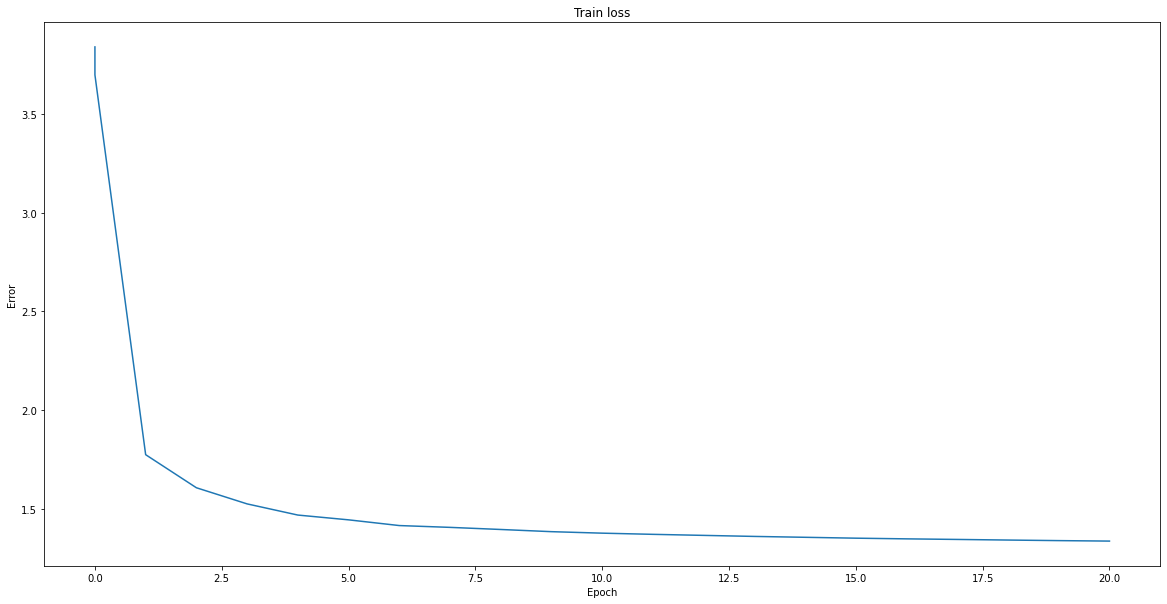

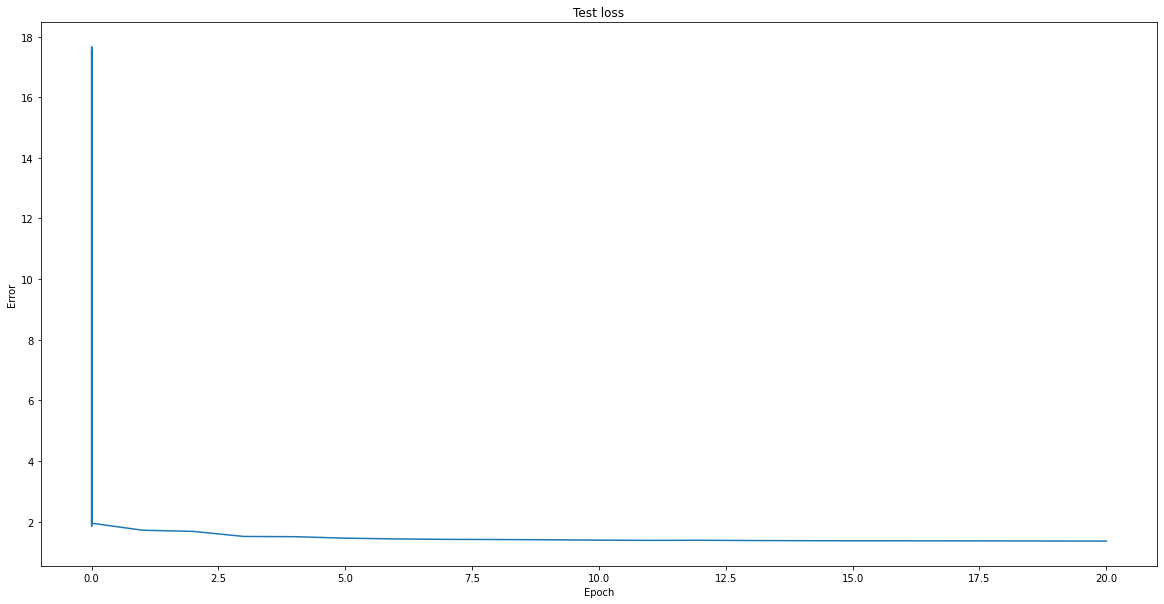

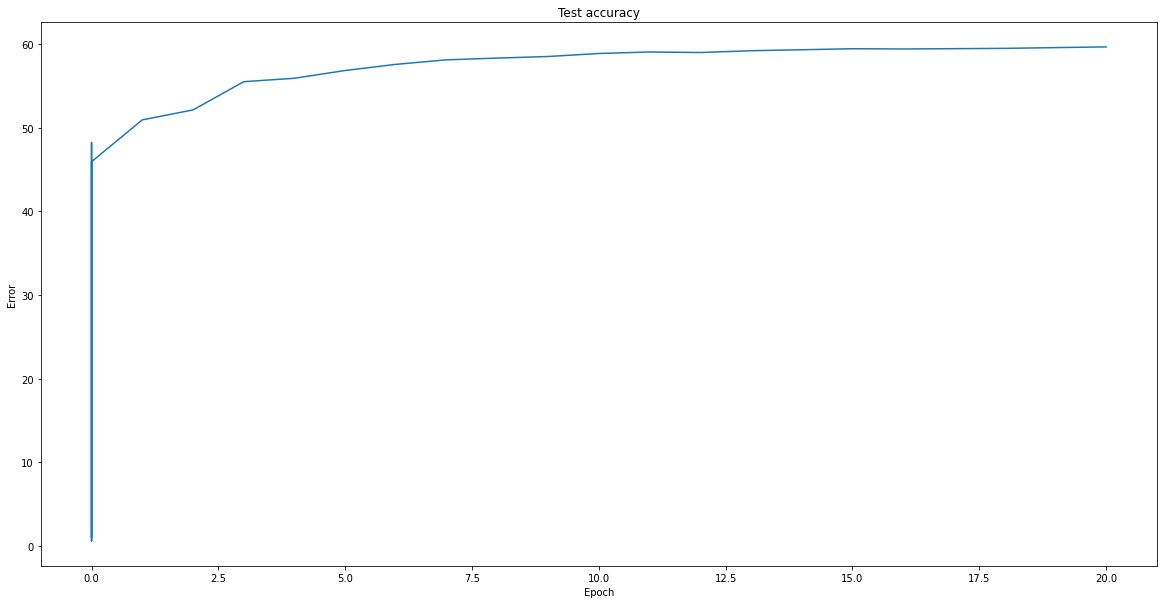

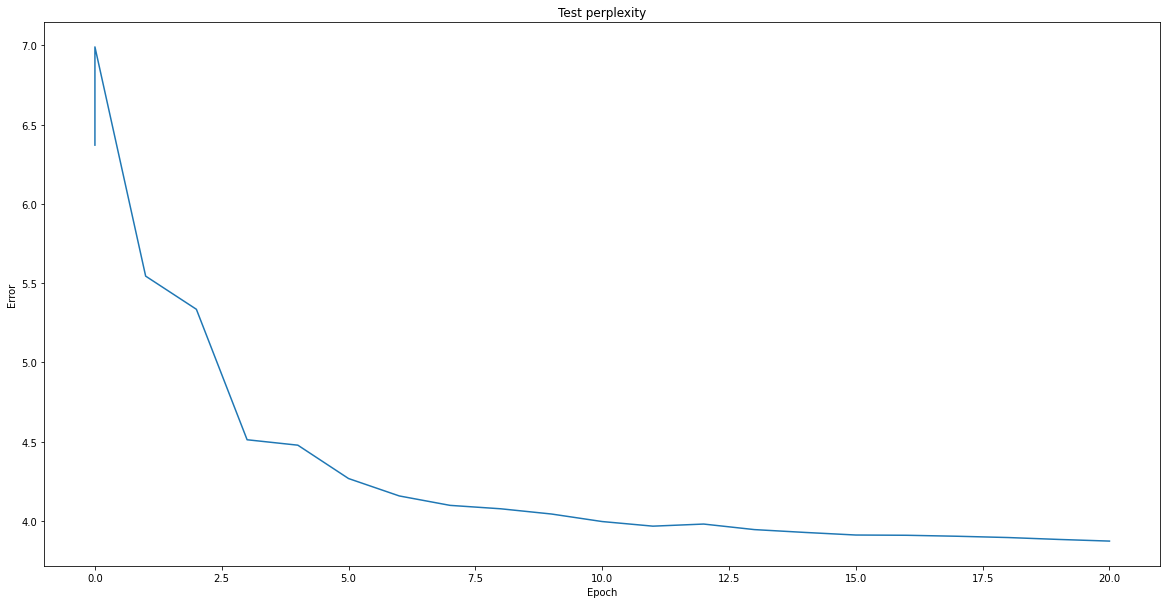

In [40]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log3.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    # start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')
    start_epoch = 0

    train_losses, test_losses, test_accuracies, test_perplexities = pt_util.read_log(LOG_PATH, ([], [], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            test_perplexities.append((epoch, math.exp(test_loss)))
            print("perplexity: " + str(test_perplexities))

            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies, test_perplexities))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 30)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        ep, val = zip(*test_perplexities)
        pt_util.plot(ep, val, 'Test perplexity', 'Epoch', 'Error')

        return model, vocab, device

final_model, vocab, device = main()

#Part 7: Experiments

In [41]:
def eval_final_model(model, vocab, device):
    seed_words = 'Harry Potter and the'
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Harry Potter and the stand of the corner of the corner of the corner of the corner of the corner of the corner of the corner of the corner of the corner of the corner of the corner of the corner of the corner of the corn
generated with sample	 Harry Potter and the ncelent Sneaturn should buly accove?; of crowded ind uspa/etary drewery than on its nostbacn honey voices that she had taken to stone stirrys floorly windows," griend, "Gook it flight."  " Wom and yo
generated with sample	 Harry Potter and the nosy watching a knicken of window and sulored at ston into broom biqs.  "Took.h! 'Och Flent - you doy told you thinking m.." said Hagrid. "Chall, not would year here, and coul of Digg Bats fall of pi
generated with sample	 Harry Potter and the survacle of notice more and Professor Lon and Ron Krage, Maving Harry and still importainly from the arnon as an ordershand" had heard. Sllack contains of horrial amainst a for a fire folfork on hiz,
generated with sample	 Harr

#Part 8: Other things
Choose **three** of the following to try. You should create new code cells below rather than modifying your earlier code:


1. Train on a different text corpus. The corpus should be at least as large as the provided Harry Potter dataset.
    - Options include other books, websites, tweets, wikipedia articles etc.
    -  (Hint: this is probably the easiest one)
1. Find a better network architecture. Some ideas:
    - Look at the various options in https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    - You can make the network wider or deeper.
    - You can try to learn separate encoders and decoders.
1. Use an LSTM instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM
    - The output of an LSTM is a hidden state **and** a cell state, so you will need to deal with a tuple instead of a single vector.
1. Use a Transformer instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer
    - Be sure to get the masks right so you don't condition on the future characters: https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer.generate_square_subsequent_mask may be of use.
1. Train a model using student-forcing.
    - You will have to modify the network inputs.
    - You will need to use `torch.nn.GRUCell` and its like. https://pytorch.org/docs/stable/nn.html#grucell
    - You cannot simply feed an empty string to start off a sequence. The sequence must be somehow conditioned on prior ground truth.
1. Train a model on words instead of characters.
    - You will need to redefine your input/output space vocabulary as well.
    - You should replace any words that occur less than 5 times in the dataset with an <unknown\> token. 
1. Write a new data loader which picks a random point in the text to start from and returns 10 consecutive sequences starting from that point onward. 
    - You should also modify the train and test functions to reset the memory when you reset the sequence.
    - You should consider an epoch to be feeding in approximately the number of characters in the dataset.
    - You may run into issues if your dataset size/epochs are not a multiple of your batch size.
1. Train on sentences instead of one long sequence.
    - You should still produce output character by character.
    - Sentences can end with a . ! ?, but words like Mr. generally do not end a sentence.
    - A sentence may also continue in the case of quotations. For example: ``"Do your homework!" said the TAs.`` is only one sentence.
    - Your parsing does not have to be perfect, but try to incorporate as many of these rules as you can.
    - Feel free to use existing NLP tools for finding sentence endings. One is spacy: https://spacy.io/usage/linguistic-features#section-sbd
    - All sentences should end with an <eos\> token. Your output sampling should now stop when it produces the <eos\> token.



### Part 8 Number 1: 

In [55]:
len(open(DATA_PATH + 'baskerville.txt').read())


373569

In [42]:
  def prepare_data(data_path):
    with open(data_path) as f:
      # This reads all the data from the file, but does not do any processing on it.
      data = f.read()
      # convert to lowercase

    # remove stop words - 
    # stops = set(stopwords.words("english"))
    # data = [w for w in data if not w in stops]
    # remove the spaces / weird lines 
    data = data.replace("\n", " ")
    data = data.replace("\t", " ")
    data = data.replace("\s", " ")


    # creates index for conversion of characters to numeric represtation for model
    voc2ind = {}  
    # alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz 0123456789.,;:\'\"!?&-~`$*-+=%[]{}^()_\/'
    # voc2ind = dict(zip(alphabet, range(0,len(alphabet))))


    # Compute voc2ind and transform the data into an integer representation of the tokens.
    index = 0
    for char in data:
      if char not in voc2ind:
        voc2ind[char] = index
        index += 1


    # maps the indext to the character - flips the voc2ind
    ind2voc = {val: key for key, val in voc2ind.items()}


    # Compute voc2ind and transform the data into an integer representation of the tokens.
    new_data = []
    for char in data:
      new_data.append(voc2ind.get(char))
    
    # print(None in new_data)
    # # figure out how to remove the None values. 
    # res = [i for i in range(len(new_data)) if new_data[i] == None] 
    # print(res)
    # print(data[5512846:5512865])      

    
    # 80% of the data into test and the remaining 20% into train 
    train_text = np.array(new_data[:int(len(data)*.8)])
    test_text = np.array(new_data[int(len(data)*.8):])

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'baskerville_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'baskerville_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'baskerville.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

In [46]:
class BaskervillesDataSet(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(BaskervillesDataSet, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)
        

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # TODO: Any preprocessing on the data to get it to the right shape.
        usable_len = math.floor(len(dataset['tokens']) / batch_size) * batch_size # new_len


        chunk_size = int(usable_len / batch_size) # len_subdivision
        
        # check for perfect match (cause issues with no label for last elem)
        # if chunk_size % sequence_length == 0 and usable_len == len(dataset['tokens']): 
        #   usable_len = usable_len - 1
        #   chunk_size = int(usable_len / batch_size) 


        # making batches now         
        # num_batches = (int)(chunk_size / sequence_length)
        self.len = math.ceil((float) (chunk_size-1)/sequence_length) * batch_size # num unique seq
        
        
        num_batches = (int)(chunk_size / self.batch_size)
        
        self.batches = [] # self.dataset_sorted
        # store batches
        # print(num_batches)
        # print(batch_size)
        # for i in range(num_batches):
        #   for j in range(batch_size): #same as num chunks
        #     data_label_pair = []
        #     curr_chunk = dataset['tokens'][j*chunk_size:chunk_size*(j+1)]
        #     data_label_pair.append(curr_chunk[i*sequence_length:sequence_length*(i+1)])
        #     data_label_pair.append(curr_chunk[i*sequence_length+1:sequence_length*(i+1)+1])
        #     self.batches.append(data_label_pair)


        for i in range(0, (int) (self.len / self.batch_size)):  # 1-3
          for batch in range(self.batch_size): # 0-1
            array = []
            for seq in range(self.sequence_length + 1): # 0-4
              index = batch * chunk_size + i * self.sequence_length + seq
              if index < (batch + 1) * chunk_size:
                array.append(dataset['tokens'][index])
            self.batches.append(array)
       

    def __len__(self):
         return self.len 
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        
        data = self.batches[idx]
        return torch.LongTensor(data[:-1]), torch.LongTensor(data[1:])

    def vocab_size(self):
        return len(self.vocab)

Using device cuda
num workers: 2
Restoring:
Shape mismatch for var encoder.weight expected torch.Size([93, 512]) got torch.Size([90, 512])
gru.weight_ih_l0 -> 	torch.Size([1536, 512]) = 3MB
gru.weight_hh_l0 -> 	torch.Size([1536, 512]) = 3MB
gru.bias_ih_l0 -> 	torch.Size([1536]) = 0MB
gru.bias_hh_l0 -> 	torch.Size([1536]) = 0MB
linear_pass.weight -> 	torch.Size([512, 512]) = 1MB
linear_pass.bias -> 	torch.Size([512]) = 0MB
lstm.weight_ih_l0 -> 	torch.Size([2048, 512]) = 4MB
lstm.weight_hh_l0 -> 	torch.Size([2048, 512]) = 4MB
lstm.bias_ih_l0 -> 	torch.Size([2048]) = 0MB
lstm.bias_hh_l0 -> 	torch.Size([2048]) = 0MB
lstm.weight_ih_l1 -> 	torch.Size([2048, 512]) = 4MB
lstm.weight_hh_l1 -> 	torch.Size([2048, 512]) = 4MB
lstm.bias_ih_l1 -> 	torch.Size([2048]) = 0MB
lstm.bias_hh_l1 -> 	torch.Size([2048]) = 0MB
Shape mismatch for var decoder.weight expected torch.Size([93, 512]) got torch.Size([90, 512])
Shape mismatch for var decoder.bias expected torch.Size([93]) got torch.Size([90])

Did not

  0%|          | 0/12 [00:00<?, ?it/s]

Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	1BBBBBBBayU))/WWæO)),WH2WyW__,2AU22222DDva2,X'3)W[WWDD,æææBaW)CHd,.WVDd,7?(,),)y)/9y,WWxFFFæ,UaUyyDy



Test set: Average loss: 23.4144, Accuracy: 369/76800 (0%)



 17%|█▋        | 2/12 [00:00<00:01,  5.59it/s]

Train Epoch: 20 [0/3072 (0%)]	Loss: 23.205500


100%|██████████| 12/12 [00:01<00:00, 10.52it/s]

Train Epoch: 20 [2560/3072 (83%)]	Loss: 12.352817


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	 ffff mmaenend,toeu t.untmtt,hhHt hottttvkin.fllnn””gg     ““ ”IIktttmvou, hok cnlttttgg  lln unt Ir



Test set: Average loss: 11.2606, Accuracy: 16653/76800 (22%)

perplexity: [(20, 77701.287844926)]
Saved /content/checkpoints/020.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.” I ugret hent ht hat ht hat ht hat hat ht hat hat ht hat hat ht hat hat ht hat hat ht hat hat ht hat hat ht hat hat ht hat hat ht hat hat ht hat hat ht hat hat ht hat hat ht hat hat ht hat hat ht hat
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at th

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. I uêk““WWGeno8” wo8”                                                   weeGeGeGeTV$$$’Per. grMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM



 25%|██▌       | 3/12 [00:00<00:01,  5.46it/s]

Train Epoch: 21 [0/3072 (0%)]	Loss: 10.703750


100%|██████████| 12/12 [00:01<00:00, 10.46it/s]

Train Epoch: 21 [2560/3072 (83%)]	Loss: 5.360925


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	ib   bbbeoy l  toom   llyn d hhen iedndfss r aitn  H      “roo”Mon  nyaoue,tes itetee lf  mh  and hi



Test set: Average loss: 5.4992, Accuracy: 23431/76800 (31%)

perplexity: [(20, 77701.287844926), (21, 244.49031764557026)]
Saved /content/checkpoints/021.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. I hed ald and hed allou ner thand heer lour neo ther ent its its infing ther lour neo ther ent its its its its inf ther lourde ronguld not wer ling ther ean ther erly ther erly four rof ther erly the
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up al

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.        Itskn’s?”       “uARnR:W, and agallou neo that its its it.”      and uppongught is tupong, Sir Heen ther lconer tharde ent wit its ine fingut in tly fime tatsins, its itt, inf tits, it.”      



 17%|█▋        | 2/12 [00:00<00:01,  5.34it/s]

Train Epoch: 22 [0/3072 (0%)]	Loss: 4.755669


100%|██████████| 12/12 [00:01<00:00, 10.18it/s]

Train Epoch: 22 [2560/3072 (83%)]	Loss: 3.361495


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	 h      oegeeg  oau   wn mnn nhit he ndtccrr cote          rop Honn ncoou  tis ct  i y f  dt  Ind ci



Test set: Average loss: 3.7199, Accuracy: 26232/76800 (34%)

perplexity: [(20, 77701.287844926), (21, 244.49031764557026), (22, 41.262257176117295)]
Saved /content/checkpoints/022.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. I frof the          courn pitpponin.”          “The Yeses I was I com poitime this his his we e       com pointied. A         “We hely ede the wis of fefe Ifor thime with his his his his his we e    
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent o

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.         “On upon yout his sified till thins his porpoppled itr the his howed?”           swe migh the hew ely bere wo coublad con tly we            coubly didogtince uppon oin this his his we lies de



 17%|█▋        | 2/12 [00:00<00:01,  5.47it/s]

Train Epoch: 23 [0/3072 (0%)]	Loss: 3.151449


100%|██████████| 12/12 [00:01<00:00, 10.23it/s]

Train Epoch: 23 [2560/3072 (83%)]	Loss: 2.837250


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	 h      iinytg moemmmewnymsd hhit hedddtccor tate  H       iii Hobs ntoou  tisiit ai iif ice  and hi



Test set: Average loss: 3.2930, Accuracy: 25432/76800 (33%)

perplexity: [(20, 77701.287844926), (21, 244.49031764557026), (22, 41.262257176117295), (23, 26.9246638755119)]
generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.          “id upon it. This is his his his his his his his his his his his his his his his his his his his his his his dingh, and his didod, hid houd, houd houd of the poppoingivied hidou, his didou, 
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions wh

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.        “You, as you you wou ivild hich Harom shives geviong anom inevesigiedid, thiinkink, thinik, anfe prieniviend it. Sir His Hery have is had uit no thion hinking?”       “You, I the         usidi



 17%|█▋        | 2/12 [00:00<00:01,  5.38it/s]

Train Epoch: 24 [0/3072 (0%)]	Loss: 2.669720


100%|██████████| 12/12 [00:01<00:00, 10.29it/s]

Train Epoch: 24 [2560/3072 (83%)]	Loss: 2.810891


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	 f      eenntg toeneeeenenneeshet wettttcs r tated H       rit Holsentoon etir it te ewf  re   n   i



Test set: Average loss: 3.1650, Accuracy: 27582/76800 (36%)

perplexity: [(20, 77701.287844926), (21, 244.49031764557026), (22, 41.262257176117295), (23, 26.9246638755119), (24, 23.688571812090235)]
Saved /content/checkpoints/024.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.         unthe whis reeseedeed the whis seeededed the whis seeededed the wheres is prppreseed the whis seeedeededes, sir sppitpressteresst          sursuseededess strursests sursuressts surressts usmu
generated sample	  Mr. Sherlock Holmes, who was usually very lat

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.hew surredes pporeds stair viness.          Mr. Streedpped steresepored was a        pleaturess if uprepseeseme.”        “Holmes, I shees fruresspeededestts switshe shire whe hed usour veretthig avere



 17%|█▋        | 2/12 [00:00<00:01,  5.20it/s]

Train Epoch: 25 [0/3072 (0%)]	Loss: 2.582445


100%|██████████| 12/12 [00:01<00:00, 10.00it/s]

Train Epoch: 25 [2560/3072 (83%)]	Loss: 2.238622


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	 a      eeiang toemedewnemnd that he s scsa  hate  H       yit Hossenioou ,tis in ta ewf ined and  i



Test set: Average loss: 2.7475, Accuracy: 29007/76800 (38%)

perplexity: [(20, 77701.287844926), (21, 244.49031764557026), (22, 41.262257176117295), (23, 26.9246638755119), (24, 23.688571812090235), (25, 15.603818788076362)]
Saved /content/checkpoints/025.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.          “What is as acle come comeme of that is          shat as come that is          seeme me. The was          seemeed meentight that seed that has seed           seeentight            was have p
generated sample	  Mr. Sherlock Holmes

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.What have as in that hat      exise me upon the crintidon have       me. The me of      Seppote of that he as of       surunedp youse, thay wash an pleache— ampleed factbion has washave am farre gol.”



 25%|██▌       | 3/12 [00:00<00:01,  5.67it/s]

Train Epoch: 26 [0/3072 (0%)]	Loss: 2.203676


100%|██████████| 12/12 [00:01<00:00, 10.54it/s]

Train Epoch: 26 [2560/3072 (83%)]	Loss: 2.150197


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        iiiytg toawtdttndwnd thit wottggcc r tottd”H      “rot”Hont ttyoud,tiy tt ti  of intd and  i



Test set: Average loss: 2.7607, Accuracy: 28949/76800 (38%)

perplexity: [(20, 77701.287844926), (21, 244.49031764557026), (22, 41.262257176117295), (23, 26.9246638755119), (24, 23.688571812090235), (25, 15.603818788076362), (26, 15.810329770751418)]
generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. This his his his his his his his from this this of the         cringurst. This of with the         conning ing this of the crours of it with          cringurst.”          “This in this of the crourst
generated sample	  Mr. Sherlock Holmes, who was

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.Whis tryought hohed it doock of round it. Holm storikD, ofity would, ‘on, MitM. Why ehis       cirstpD,” soidols.       stonatirsy this rous firing indownstty. Ardond rund oning with in might.”       



 17%|█▋        | 2/12 [00:00<00:01,  5.45it/s]

Train Epoch: 27 [0/3072 (0%)]	Loss: 2.210527


100%|██████████| 12/12 [00:01<00:00, 10.29it/s]

Train Epoch: 27 [2560/3072 (83%)]	Loss: 2.114431


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        eenatg eoened wndwnd whet te t scsa  tate  H       yit HDlteltyon  tis tn ee ewf ined and  i



Test set: Average loss: 2.5455, Accuracy: 31334/76800 (41%)

perplexity: [(20, 77701.287844926), (21, 244.49031764557026), (22, 41.262257176117295), (23, 26.9246638755119), (24, 23.688571812090235), (25, 15.603818788076362), (26, 15.810329770751418), (27, 12.749171181117568)]
Saved /content/checkpoints/027.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.          “Whe had lasted the me the moor who could            The he he dood you and even with he he he dood you and even with he he he dood you an he he was the            will the pope

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.“BathB, I dobout the mat he lmess. Thoing e gred a        Col.”        The way the peat I had sefed he pefual play of the       mucch of he but the finled upnd the      deencle befr.         The Mrest



 17%|█▋        | 2/12 [00:00<00:01,  5.27it/s]

Train Epoch: 28 [0/3072 (0%)]	Loss: 2.029383


100%|██████████| 12/12 [00:01<00:00, 10.24it/s]

Train Epoch: 28 [2560/3072 (83%)]	Loss: 1.925970


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        eeiatg toene etnewgdewhet he t gcca  mete  H       yit Hotgettoon ,tes tt te ewf int   nd  i



Test set: Average loss: 2.3901, Accuracy: 32325/76800 (42%)

perplexity: [(20, 77701.287844926), (21, 244.49031764557026), (22, 41.262257176117295), (23, 26.9246638755119), (24, 23.688571812090235), (25, 15.603818788076362), (26, 15.810329770751418), (27, 12.749171181117568), (28, 10.914889838306086)]
Saved /content/checkpoints/028.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.          “Whe he he dood, you whe he was the me the me of the me of the me to of the          we he perest of the         we he perest of the seen of he he we s

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.Then       Vrimest the Sir riled Heapy      the I leavent me reaspe,”         hubre I acks hely eve. Sthere ofe the yousB, of      hes        showe he he lodeve        hes your face dengestat I cangen



 25%|██▌       | 3/12 [00:00<00:01,  5.61it/s]

Train Epoch: 29 [0/3072 (0%)]	Loss: 1.891559


100%|██████████| 12/12 [00:01<00:00, 10.46it/s]

Train Epoch: 29 [2560/3072 (83%)]	Loss: 2.723777


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        eagaeg toawe vaddmgdethed waaddgcma  tete  H      “yae Heygedcoou ,tay  d te e u  de  tdd tt



Test set: Average loss: 3.6871, Accuracy: 28499/76800 (37%)

perplexity: [(20, 77701.287844926), (21, 244.49031764557026), (22, 41.262257176117295), (23, 26.9246638755119), (24, 23.688571812090235), (25, 15.603818788076362), (26, 15.810329770751418), (27, 12.749171181117568), (28, 10.914889838306086), (29, 39.92737837864224)]
generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.         “Whad the teeme the tawad the te teeme the te twad the teexteme the te twade the teexteme the tewarde the teexteme the tewarde the texeteme the tewarde the texete

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. We tha me the tkwa?”       “Out tha coum to texceme tadid he texette up the    tway ve to exteram peache twardame tade texped te take the twas be tee teexttemeeme twe the te te    twas       expeadre



 25%|██▌       | 3/12 [00:00<00:01,  5.61it/s]

Train Epoch: 30 [0/3072 (0%)]	Loss: 3.058406


100%|██████████| 12/12 [00:01<00:00, 10.48it/s]

Train Epoch: 30 [2560/3072 (83%)]	Loss: 2.190011


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        einit  toeu   tndwss ihet tittgscci  iite  H      “rii Hongenioou  iii in ti   u idu  and ii



Test set: Average loss: 2.6601, Accuracy: 29759/76800 (39%)

perplexity: [(20, 77701.287844926), (21, 244.49031764557026), (22, 41.262257176117295), (23, 26.9246638755119), (24, 23.688571812090235), (25, 15.603818788076362), (26, 15.810329770751418), (27, 12.749171181117568), (28, 10.914889838306086), (29, 39.92737837864224), (30, 14.297347000166809)]
generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. What in the           cimptoincious out the crimpried in the crimpried in the crimpring                               station to coust to the cr

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.He reig viride is naturnge. IfBrothB-D-overstimer. ThBery hat for her is not         is yous back foul ke vis thoin the my smoprisie ouch divid of his avid here inis youl chave have te trow nig. I tha



 17%|█▋        | 2/12 [00:00<00:01,  5.37it/s]

Train Epoch: 31 [0/3072 (0%)]	Loss: 2.112250


100%|██████████| 12/12 [00:01<00:00, 10.39it/s]

Train Epoch: 31 [2560/3072 (83%)]	Loss: 1.913758


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	 i      eenatd toooed wn mnd,noet hostdsccar mote  H     ““rou Holseliyon,,iis in aa ewf inud and ai



Test set: Average loss: 2.3649, Accuracy: 31447/76800 (41%)

perplexity: [(20, 77701.287844926), (21, 244.49031764557026), (22, 41.262257176117295), (23, 26.9246638755119), (24, 23.688571812090235), (25, 15.603818788076362), (26, 15.810329770751418), (27, 12.749171181117568), (28, 10.914889838306086), (29, 39.92737837864224), (30, 14.297347000166809), (31, 10.642858936894566)]
generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The was all of the prissions, and allow was in the mand, and allow was in and allow the mand and allow the had and all

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.They wos have any berrised, the,      mabuls, the dam?”        “No, sir, buly the brony haven, and dal, face exsames in hard warned, you. I cames was in angles ceastantrion. Holmes, of many is which d



 17%|█▋        | 2/12 [00:00<00:01,  5.14it/s]

Train Epoch: 32 [0/3072 (0%)]	Loss: 1.881447


100%|██████████| 12/12 [00:01<00:00, 10.22it/s]

Train Epoch: 32 [2560/3072 (83%)]	Loss: 1.841683


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	t       eanatt taaaed tnewnd toat taattfcca  tate  H      “yat Hatteltyon,,tat ttttaaeaf  nu  and ti



Test set: Average loss: 2.2981, Accuracy: 31880/76800 (42%)

perplexity: [(20, 77701.287844926), (21, 244.49031764557026), (22, 41.262257176117295), (23, 26.9246638755119), (24, 23.688571812090235), (25, 15.603818788076362), (26, 15.810329770751418), (27, 12.749171181117568), (28, 10.914889838306086), (29, 39.92737837864224), (30, 14.297347000166809), (31, 10.642858936894566), (32, 9.95563159046558)]
generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. That the was that that had a geture a latter was that that had a gerat had a care a callaction

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.Whe part cance to theat hould andger am vowhat wave surated that that fat her case facles, and leatwas that awas to deard, agread, It       way hare to at heast to lager      cartamideen watthe face h



 17%|█▋        | 2/12 [00:00<00:01,  5.22it/s]

Train Epoch: 33 [0/3072 (0%)]	Loss: 1.801253


100%|██████████| 12/12 [00:01<00:00, 10.23it/s]

Train Epoch: 33 [2560/3072 (83%)]	Loss: 1.914108


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        ein tg ooowed  ndwnd  oit tottdgccar oote  H      “riu Hoytelcyon  fhy  t tir  f icud  nd  i



Test set: Average loss: 2.4036, Accuracy: 31623/76800 (41%)

perplexity: [(20, 77701.287844926), (21, 244.49031764557026), (22, 41.262257176117295), (23, 26.9246638755119), (24, 23.688571812090235), (25, 15.603818788076362), (26, 15.810329770751418), (27, 12.749171181117568), (28, 10.914889838306086), (29, 39.92737837864224), (30, 14.297347000166809), (31, 10.642858936894566), (32, 9.95563159046558), (33, 11.062946908259226)]
generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. This                                          such fired upon       

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.Thight houg hing undown boor roo do         rif. This you acpto his which whot of the mer       moorry       prighir crilaw wor     orce. I’___——uet”           tho hoserfur         rilef;      how abo



 17%|█▋        | 2/12 [00:00<00:01,  5.32it/s]

Train Epoch: 34 [0/3072 (0%)]	Loss: 1.925126


100%|██████████| 12/12 [00:01<00:00, 10.21it/s]

Train Epoch: 34 [2560/3072 (83%)]	Loss: 1.891024


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	 o      eenetg ooeueeetnennd nhet tetttgecer mete  H      “yet Hottencoon,,tis tn tereof ine. and Ii



Test set: Average loss: 2.4172, Accuracy: 30977/76800 (40%)

perplexity: [(20, 77701.287844926), (21, 244.49031764557026), (22, 41.262257176117295), (23, 26.9246638755119), (24, 23.688571812090235), (25, 15.603818788076362), (26, 15.810329770751418), (27, 12.749171181117568), (28, 10.914889838306086), (29, 39.92737837864224), (30, 14.297347000166809), (31, 10.642858936894566), (32, 9.95563159046558), (33, 11.062946908259226), (34, 11.21420917776995)]
generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. There of the perestong of it. There with on

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.       “Perver?”        “Not, here. Nookes, it.”        “It is to extileft. Thesed Stapleton, whith out he heperen I werent out deelverer, pleen to topeen meent me. We meremer, fEandss.         “Well,



 25%|██▌       | 3/12 [00:00<00:01,  5.67it/s]

Train Epoch: 35 [0/3072 (0%)]	Loss: 1.953432


100%|██████████| 12/12 [00:01<00:00, 10.51it/s]

Train Epoch: 35 [2560/3072 (83%)]	Loss: 1.799481


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        ainang ooaue  tndnnd ahat haasdsaca  aate  H      “you Holtencoond,wis an ti  hf ine  and ai



Test set: Average loss: 2.2131, Accuracy: 33553/76800 (44%)

perplexity: [(20, 77701.287844926), (21, 244.49031764557026), (22, 41.262257176117295), (23, 26.9246638755119), (24, 23.688571812090235), (25, 15.603818788076362), (26, 15.810329770751418), (27, 12.749171181117568), (28, 10.914889838306086), (29, 39.92737837864224), (30, 14.297347000166809), (31, 10.642858936894566), (32, 9.95563159046558), (33, 11.062946908259226), (34, 11.21420917776995), (35, 9.144147916268285)]
Saved /content/checkpoints/035.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the 

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.Hall, ade?”        “Ha-meBs, I court jever such dare so go not was with a  showell but fidget       was as in anunserst       dauid a geat they sall. And a was as mement, said       aboutelf tit my hu



 17%|█▋        | 2/12 [00:00<00:01,  5.37it/s]

Train Epoch: 36 [0/3072 (0%)]	Loss: 1.748503


100%|██████████| 12/12 [00:01<00:00, 10.37it/s]

Train Epoch: 36 [2560/3072 (83%)]	Loss: 1.676328


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        eenatg toeue  tnennd thet heartgccar mate  H      “y.t Hongencyond,tis tn ti  tf  cu  and ti



Test set: Average loss: 2.0796, Accuracy: 35081/76800 (46%)

perplexity: [(20, 77701.287844926), (21, 244.49031764557026), (22, 41.262257176117295), (23, 26.9246638755119), (24, 23.688571812090235), (25, 15.603818788076362), (26, 15.810329770751418), (27, 12.749171181117568), (28, 10.914889838306086), (29, 39.92737837864224), (30, 14.297347000166809), (31, 10.642858936894566), (32, 9.95563159046558), (33, 11.062946908259226), (34, 11.21420917776995), (35, 9.144147916268285), (36, 8.000897185657124)]
Saved /content/checkpoints/036.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all 

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.But Engly Sir Chand skerville your cover __      exruts took.”      I saw had beled will toots read. But Shrow-led caure you a bether, what acke off, and lepten !Why     howere broutend?”       “Ber; 



 17%|█▋        | 2/12 [00:00<00:01,  5.24it/s]

Train Epoch: 37 [0/3072 (0%)]	Loss: 1.622216


100%|██████████| 12/12 [00:01<00:00, 10.05it/s]

Train Epoch: 37 [2560/3072 (83%)]	Loss: 1.718941


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        aanatd taanedvtndnnd thet waattsacar tate  H     ““y.t Hattencyon,,tas tt tirewn inud and at



Test set: Average loss: 2.1354, Accuracy: 33993/76800 (44%)

perplexity: [(20, 77701.287844926), (21, 244.49031764557026), (22, 41.262257176117295), (23, 26.9246638755119), (24, 23.688571812090235), (25, 15.603818788076362), (26, 15.810329770751418), (27, 12.749171181117568), (28, 10.914889838306086), (29, 39.92737837864224), (30, 14.297347000166809), (31, 10.642858936894566), (32, 9.95563159046558), (33, 11.062946908259226), (34, 11.21420917776995), (35, 9.144147916268285), (36, 8.000897185657124), (37, 8.460142039212199)]
generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.Lever, an had, and a untlerend was        etteret.”       There a caut denterelfwl a replanctly this affort he run man py ont.”       I put as by talk had had sopen, that whing at it was you unturdury



 17%|█▋        | 2/12 [00:00<00:01,  5.34it/s]

Train Epoch: 38 [0/3072 (0%)]	Loss: 1.687970


100%|██████████| 12/12 [00:01<00:00, 10.33it/s]

Train Epoch: 38 [2560/3072 (83%)]	Loss: 1.898707


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	 o      eeveee  rene eorennd  oet ie r secer  ete          ret Hoytetcoon  oes ot  i e f ece   rd  i



Test set: Average loss: 2.5817, Accuracy: 31016/76800 (40%)

perplexity: [(20, 77701.287844926), (21, 244.49031764557026), (22, 41.262257176117295), (23, 26.9246638755119), (24, 23.688571812090235), (25, 15.603818788076362), (26, 15.810329770751418), (27, 12.749171181117568), (28, 10.914889838306086), (29, 39.92737837864224), (30, 14.297347000166809), (31, 10.642858936894566), (32, 9.95563159046558), (33, 11.062946908259226), (34, 11.21420917776995), (35, 9.144147916268285), (36, 8.000897185657124), (37, 8.460142039212199), (38, 13.219336125712863)]
generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions whe

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.          “MresspsoBry crey vere fre bere          perembere me of here swee         noticke sor us of eyes upon his grere         neopere ore re munt benen or        eyep been reempreses of upon to g



 17%|█▋        | 2/12 [00:00<00:01,  5.31it/s]

Train Epoch: 39 [0/3072 (0%)]	Loss: 2.114151


100%|██████████| 12/12 [00:01<00:00, 10.29it/s]

Train Epoch: 39 [2560/3072 (83%)]	Loss: 1.940520


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        iiwatg ooauervononnd whet  itttsacar mote         “rou Hotgetgoond,oas  t  i eof rrur  nd  i



Test set: Average loss: 2.4322, Accuracy: 31803/76800 (41%)

perplexity: [(20, 77701.287844926), (21, 244.49031764557026), (22, 41.262257176117295), (23, 26.9246638755119), (24, 23.688571812090235), (25, 15.603818788076362), (26, 15.810329770751418), (27, 12.749171181117568), (28, 10.914889838306086), (29, 39.92737837864224), (30, 14.297347000166809), (31, 10.642858936894566), (32, 9.95563159046558), (33, 11.062946908259226), (34, 11.21420917776995), (35, 9.144147916268285), (36, 8.000897185657124), (37, 8.460142039212199), (38, 13.219336125712863), (39, 11.383426367478448)]
generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those no

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.The recould un deriblity, of yourriviight userdury ind        wat the Sir       CorgrimmatGed in the materon’s was        SirCllitially it o mee onercuturled dervigher. There is orling was Coomer?”   



 17%|█▋        | 2/12 [00:00<00:01,  5.54it/s]

Train Epoch: 40 [0/3072 (0%)]	Loss: 1.966774


100%|██████████| 12/12 [00:01<00:00, 10.40it/s]

Train Epoch: 40 [2560/3072 (83%)]	Loss: 1.706243


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	 t      aan tg aoeuedetnemnd thet weardfecar mete  H      “yit Hoytetgyond,fhs tn tirewf  cu  and ai



Test set: Average loss: 2.1130, Accuracy: 34129/76800 (44%)

perplexity: [(20, 77701.287844926), (21, 244.49031764557026), (22, 41.262257176117295), (23, 26.9246638755119), (24, 23.688571812090235), (25, 15.603818788076362), (26, 15.810329770751418), (27, 12.749171181117568), (28, 10.914889838306086), (29, 39.92737837864224), (30, 14.297347000166809), (31, 10.642858936894566), (32, 9.95563159046558), (33, 11.062946908259226), (34, 11.21420917776995), (35, 9.144147916268285), (36, 8.000897185657124), (37, 8.460142039212199), (38, 13.219336125712863), (39, 11.383426367478448), (40, 8.272730552107113)]
generated max		  Mr. Sherlock Holmes, who was usually very late in the mo

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.This firtan of felempens face of the who cane old the pestook a lasut night for him, fro Self-unding you straink at all it any op and as this bruthing of gurnesshorled which I down to his mer. Betrati



 17%|█▋        | 2/12 [00:00<00:01,  5.17it/s]

Train Epoch: 41 [0/3072 (0%)]	Loss: 1.666122


100%|██████████| 12/12 [00:01<00:00, 10.03it/s]

Train Epoch: 41 [2560/3072 (83%)]	Loss: 1.595923


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        een ng ooeue  tnennd woet heattfeca  mane  H      “you Hongengoon ,was an ti eaf  nu  and  i



Test set: Average loss: 2.0381, Accuracy: 35401/76800 (46%)

perplexity: [(20, 77701.287844926), (21, 244.49031764557026), (22, 41.262257176117295), (23, 26.9246638755119), (24, 23.688571812090235), (25, 15.603818788076362), (26, 15.810329770751418), (27, 12.749171181117568), (28, 10.914889838306086), (29, 39.92737837864224), (30, 14.297347000166809), (31, 10.642858936894566), (32, 9.95563159046558), (33, 11.062946908259226), (34, 11.21420917776995), (35, 9.144147916268285), (36, 8.000897185657124), (37, 8.460142039212199), (38, 13.219336125712863), (39, 11.383426367478448), (40, 8.272730552107113), (41, 7.675841968665167)]
Saved /content/checkpoints/041.pt

generated max

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.There of one hired       curselance frme his deesactsaked from us an end       hirds.      I was and       black you sent loome for men. “I mend to you extler away coursta to an voight. But would vint



 17%|█▋        | 2/12 [00:00<00:01,  5.22it/s]

Train Epoch: 42 [0/3072 (0%)]	Loss: 1.592858


100%|██████████| 12/12 [00:01<00:00, 10.07it/s]

Train Epoch: 42 [2560/3072 (83%)]	Loss: 1.556973


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        eenang ooeued,tnennd thet waastsacar mate  H      “y.t Hattengyond,wis tn tirewf ecu. and ai



Test set: Average loss: 1.9927, Accuracy: 35574/76800 (46%)

perplexity: [(20, 77701.287844926), (21, 244.49031764557026), (22, 41.262257176117295), (23, 26.9246638755119), (24, 23.688571812090235), (25, 15.603818788076362), (26, 15.810329770751418), (27, 12.749171181117568), (28, 10.914889838306086), (29, 39.92737837864224), (30, 14.297347000166809), (31, 10.642858936894566), (32, 9.95563159046558), (33, 11.062946908259226), (34, 11.21420917776995), (35, 9.144147916268285), (36, 8.000897185657124), (37, 8.460142039212199), (38, 13.219336125712863), (39, 11.383426367478448), (40, 8.272730552107113), (41, 7.675841968665167), (42, 7.3353763769809515)]
Saved /content/checkpo

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.A_     had laste, Mr. Holmes Mrips of largge hereck on with dirting his comearly plac, dark about up there facosus, of        ace for me. I; had been           has thenesed Sar to stelechem,        sk



 25%|██▌       | 3/12 [00:00<00:01,  5.53it/s]

Train Epoch: 43 [0/3072 (0%)]	Loss: 1.553999


100%|██████████| 12/12 [00:01<00:00, 10.52it/s]

Train Epoch: 43 [2560/3072 (83%)]	Loss: 1.625072


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        ean nd woene  annnnd whet waasdsaca  mane  H      “yat Hangangyond wis nn  i  an  nu  and  i



Test set: Average loss: 2.0398, Accuracy: 35013/76800 (46%)

perplexity: [(20, 77701.287844926), (21, 244.49031764557026), (22, 41.262257176117295), (23, 26.9246638755119), (24, 23.688571812090235), (25, 15.603818788076362), (26, 15.810329770751418), (27, 12.749171181117568), (28, 10.914889838306086), (29, 39.92737837864224), (30, 14.297347000166809), (31, 10.642858936894566), (32, 9.95563159046558), (33, 11.062946908259226), (34, 11.21420917776995), (35, 9.144147916268285), (36, 8.000897185657124), (37, 8.460142039212199), (38, 13.219336125712863), (39, 11.383426367478448), (40, 8.272730552107113), (41, 7.675841968665167), (42, 7.3353763769809515), (43, 7.688732766711142

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.One tem an I who can use twered thank aman and for und the mand durnes with strachan on excase of mos!”      Frakfa Dr.M.MAs mire which he gave Watson’t is giver my disraing his frish hus faug, and ca



 17%|█▋        | 2/12 [00:00<00:01,  5.30it/s]

Train Epoch: 44 [0/3072 (0%)]	Loss: 1.600934


100%|██████████| 12/12 [00:01<00:00, 10.20it/s]

Train Epoch: 44 [2560/3072 (83%)]	Loss: 1.548146


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	 o      een ng ooeued tnennd toet heastsacar mute  H      “yst Hottsncoond,ths tn tir hf icu. and ti



Test set: Average loss: 1.9761, Accuracy: 36186/76800 (47%)

perplexity: [(20, 77701.287844926), (21, 244.49031764557026), (22, 41.262257176117295), (23, 26.9246638755119), (24, 23.688571812090235), (25, 15.603818788076362), (26, 15.810329770751418), (27, 12.749171181117568), (28, 10.914889838306086), (29, 39.92737837864224), (30, 14.297347000166809), (31, 10.642858936894566), (32, 9.95563159046558), (33, 11.062946908259226), (34, 11.21420917776995), (35, 9.144147916268285), (36, 8.000897185657124), (37, 8.460142039212199), (38, 13.219336125712863), (39, 11.383426367478448), (40, 8.272730552107113), (41, 7.675841968665167), (42, 7.3353763769809515), (43, 7.688732766711142

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.The care surumed to be his      somehos hoped of the. It in lipit of this      the goo.”       said I do Enly hid his parkins of mmaniner, nother curm to this on       his onon of thing ours of als ey



 17%|█▋        | 2/12 [00:00<00:01,  5.29it/s]

Train Epoch: 45 [0/3072 (0%)]	Loss: 1.548203


100%|██████████| 12/12 [00:01<00:00, 10.15it/s]

Train Epoch: 45 [2560/3072 (83%)]	Loss: 1.549121


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	 t      een ne toene vtnennd toet teastseca  tete  H      “yit Hontengyond,wis tn ti ewf icu  and ti



Test set: Average loss: 1.9468, Accuracy: 36585/76800 (48%)

perplexity: [(20, 77701.287844926), (21, 244.49031764557026), (22, 41.262257176117295), (23, 26.9246638755119), (24, 23.688571812090235), (25, 15.603818788076362), (26, 15.810329770751418), (27, 12.749171181117568), (28, 10.914889838306086), (29, 39.92737837864224), (30, 14.297347000166809), (31, 10.642858936894566), (32, 9.95563159046558), (33, 11.062946908259226), (34, 11.21420917776995), (35, 9.144147916268285), (36, 8.000897185657124), (37, 8.460142039212199), (38, 13.219336125712863), (39, 11.383426367478448), (40, 8.272730552107113), (41, 7.675841968665167), (42, 7.3353763769809515), (43, 7.688732766711142

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.Sherlesed, and I was and his before any hilel we into every so fllowes hoper his      offcur, and the will tak we had leante? Orned to get. I worlde-shed firest to me whilghy        wildles of upon to



 25%|██▌       | 3/12 [00:00<00:01,  5.51it/s]

Train Epoch: 46 [0/3072 (0%)]	Loss: 1.521084


100%|██████████| 12/12 [00:01<00:00, 10.56it/s]

Train Epoch: 46 [2560/3072 (83%)]	Loss: 1.557247


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        een ne aoene  tnennd thet heastsesar mete  H       yet Hansengyon  tis sn ti eif  cu  and  i



Test set: Average loss: 1.9747, Accuracy: 36005/76800 (47%)

perplexity: [(20, 77701.287844926), (21, 244.49031764557026), (22, 41.262257176117295), (23, 26.9246638755119), (24, 23.688571812090235), (25, 15.603818788076362), (26, 15.810329770751418), (27, 12.749171181117568), (28, 10.914889838306086), (29, 39.92737837864224), (30, 14.297347000166809), (31, 10.642858936894566), (32, 9.95563159046558), (33, 11.062946908259226), (34, 11.21420917776995), (35, 9.144147916268285), (36, 8.000897185657124), (37, 8.460142039212199), (38, 13.219336125712863), (39, 11.383426367478448), (40, 8.272730552107113), (41, 7.675841968665167), (42, 7.3353763769809515), (43, 7.688732766711142

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.Barrey from his gyse—”        keep metine preasten this spreced away he as ’so agan       experned tow a fret       your nearues semend.       We homs to methin wish begen ment fos?       siden the qu



 17%|█▋        | 2/12 [00:00<00:01,  5.21it/s]

Train Epoch: 47 [0/3072 (0%)]	Loss: 1.541097


100%|██████████| 12/12 [00:01<00:00, 10.01it/s]

Train Epoch: 47 [2560/3072 (83%)]	Loss: 1.698819


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        een ng woene  anennd when heasssesar mase          yet Hansengyond,whs sn  e ewn ece  and si



Test set: Average loss: 2.2330, Accuracy: 33581/76800 (44%)

perplexity: [(20, 77701.287844926), (21, 244.49031764557026), (22, 41.262257176117295), (23, 26.9246638755119), (24, 23.688571812090235), (25, 15.603818788076362), (26, 15.810329770751418), (27, 12.749171181117568), (28, 10.914889838306086), (29, 39.92737837864224), (30, 14.297347000166809), (31, 10.642858936894566), (32, 9.95563159046558), (33, 11.062946908259226), (34, 11.21420917776995), (35, 9.144147916268285), (36, 8.000897185657124), (37, 8.460142039212199), (38, 13.219336125712863), (39, 11.383426367478448), (40, 8.272730552107113), (41, 7.675841968665167), (42, 7.3353763769809515), (43, 7.688732766711142

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.        “He wree no dinvigan. “I he surpraless breage.          “I here runness an cleye, an he drepy see conlabed any seay he his fread.         “Welses which I head he letemen sead there. But hey an



 17%|█▋        | 2/12 [00:00<00:01,  5.15it/s]

Train Epoch: 48 [0/3072 (0%)]	Loss: 1.781652


100%|██████████| 12/12 [00:01<00:00, 10.14it/s]

Train Epoch: 48 [2560/3072 (83%)]	Loss: 1.978518


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	 o      ianstt trecelsonnnnt toet tessttanar mrten H      “yst Hantsngyon ,ohs ot ti  wf  nun and It



Test set: Average loss: 2.3374, Accuracy: 32812/76800 (43%)

perplexity: [(20, 77701.287844926), (21, 244.49031764557026), (22, 41.262257176117295), (23, 26.9246638755119), (24, 23.688571812090235), (25, 15.603818788076362), (26, 15.810329770751418), (27, 12.749171181117568), (28, 10.914889838306086), (29, 39.92737837864224), (30, 14.297347000166809), (31, 10.642858936894566), (32, 9.95563159046558), (33, 11.062946908259226), (34, 11.21420917776995), (35, 9.144147916268285), (36, 8.000897185657124), (37, 8.460142039212199), (38, 13.219336125712863), (39, 11.383426367478448), (40, 8.272730552107113), (41, 7.675841968665167), (42, 7.3353763769809515), (43, 7.688732766711142

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.The bran known that I was do ret to to the knot an of tBatcut wher his who seemn he worshers of to the       likey, and In two brot the man wors. Lhoodmorn Stat to he lesing of the or ders prson, gin,



 25%|██▌       | 3/12 [00:00<00:01,  5.37it/s]

Train Epoch: 49 [0/3072 (0%)]	Loss: 1.881981


100%|██████████| 12/12 [00:01<00:00, 10.48it/s]

Train Epoch: 49 [2560/3072 (83%)]	Loss: 1.670608


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	 i      oen ne ooese  tnensd hoet haas sesa   ate  H      “yyt Hangebgoon  whs  n  i   n iee  tnd  i



Test set: Average loss: 2.0964, Accuracy: 35271/76800 (46%)

perplexity: [(20, 77701.287844926), (21, 244.49031764557026), (22, 41.262257176117295), (23, 26.9246638755119), (24, 23.688571812090235), (25, 15.603818788076362), (26, 15.810329770751418), (27, 12.749171181117568), (28, 10.914889838306086), (29, 39.92737837864224), (30, 14.297347000166809), (31, 10.642858936894566), (32, 9.95563159046558), (33, 11.062946908259226), (34, 11.21420917776995), (35, 9.144147916268285), (36, 8.000897185657124), (37, 8.460142039212199), (38, 13.219336125712863), (39, 11.383426367478448), (40, 8.272730552107113), (41, 7.675841968665167), (42, 7.3353763769809515), (43, 7.688732766711142

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.The you seme      what he      head topen whichown who have       kend had down when here tan known which        in Lond and Sether and       had cresan kew was      noting by in hild was it        in



 17%|█▋        | 2/12 [00:00<00:01,  5.39it/s]

Train Epoch: 50 [0/3072 (0%)]	Loss: 1.646771


100%|██████████| 12/12 [00:01<00:00, 10.36it/s]

Train Epoch: 50 [2560/3072 (83%)]	Loss: 1.515979


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        een ng ooese vtneund thet taastsecar tate  H      “yot Hattatgyond ths tn te ett ece  and  i



Test set: Average loss: 1.9251, Accuracy: 36845/76800 (48%)

perplexity: [(20, 77701.287844926), (21, 244.49031764557026), (22, 41.262257176117295), (23, 26.9246638755119), (24, 23.688571812090235), (25, 15.603818788076362), (26, 15.810329770751418), (27, 12.749171181117568), (28, 10.914889838306086), (29, 39.92737837864224), (30, 14.297347000166809), (31, 10.642858936894566), (32, 9.95563159046558), (33, 11.062946908259226), (34, 11.21420917776995), (35, 9.144147916268285), (36, 8.000897185657124), (37, 8.460142039212199), (38, 13.219336125712863), (39, 11.383426367478448), (40, 8.272730552107113), (41, 7.675841968665167), (42, 7.3353763769809515), (43, 7.688732766711142

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.With the matef” BSythy        counc.”      He hadd not know words to hearlds’s Chave nuress agains.       “To reake the read to complance sour neverr. Heg, the $Dy      tervises that the hotes?”      



 17%|█▋        | 2/12 [00:00<00:01,  5.22it/s]

Train Epoch: 51 [0/3072 (0%)]	Loss: 1.496181


100%|██████████| 12/12 [00:01<00:00, 10.18it/s]


Train Epoch: 51 [2560/3072 (83%)]	Loss: 1.471699
Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        een ne aoece vtnennd thet heasdsecar mete         “y.t Hangangyond whs tn ti e f  cu  and  i



Test set: Average loss: 1.8966, Accuracy: 37214/76800 (48%)

perplexity: [(20, 77701.287844926), (21, 244.49031764557026), (22, 41.262257176117295), (23, 26.9246638755119), (24, 23.688571812090235), (25, 15.603818788076362), (26, 15.810329770751418), (27, 12.749171181117568), (28, 10.914889838306086), (29, 39.92737837864224), (30, 14.297347000166809), (31, 10.642858936894566), (32, 9.95563159046558), (33, 11.062946908259226), (34, 11.21420917776995), (35, 9.144147916268285), (36, 8.000897185657124), (37, 8.460142039212199), (38, 13.219336125712863), (39, 11.383426367478448), (40, 8.272730552107113), (41, 7.675841968665167),

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.You with ming and rache.         Hight remamble flact of figan” said Stal of us our end our       neverhamply much         which here,       toone,         before secoverly        can eve noce        



 17%|█▋        | 2/12 [00:00<00:01,  5.20it/s]

Train Epoch: 52 [0/3072 (0%)]	Loss: 1.469116


100%|██████████| 12/12 [00:01<00:00, 10.08it/s]

Train Epoch: 52 [2560/3072 (83%)]	Loss: 1.456990


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        aan ne aoesedvtnennd woet taastsacar mate         “yot Hattangyond,whs tn ti eaf ecu  and at



Test set: Average loss: 1.8817, Accuracy: 37160/76800 (48%)

perplexity: [(20, 77701.287844926), (21, 244.49031764557026), (22, 41.262257176117295), (23, 26.9246638755119), (24, 23.688571812090235), (25, 15.603818788076362), (26, 15.810329770751418), (27, 12.749171181117568), (28, 10.914889838306086), (29, 39.92737837864224), (30, 14.297347000166809), (31, 10.642858936894566), (32, 9.95563159046558), (33, 11.062946908259226), (34, 11.21420917776995), (35, 9.144147916268285), (36, 8.000897185657124), (37, 8.460142039212199), (38, 13.219336125712863), (39, 11.383426367478448), (40, 8.272730552107113), (41, 7.675841968665167), (42, 7.3353763769809515), (43, 7.688732766711142

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.That and, so, for thead an wronducems and asked him here, and I had maways then who larrom        firtenly Chast, and made, for when I       was seen that be wilghim. As than he was no man       obbra



 25%|██▌       | 3/12 [00:00<00:01,  5.48it/s]

Train Epoch: 53 [0/3072 (0%)]	Loss: 1.452779


100%|██████████| 12/12 [00:01<00:00, 10.50it/s]

Train Epoch: 53 [2560/3072 (83%)]	Loss: 1.454562


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        ean ne ooeue  tnennd thet heasdsacer mane         “yat Hantangyond whs sn ti  af  cu  and  i



Test set: Average loss: 1.9035, Accuracy: 37144/76800 (48%)

perplexity: [(20, 77701.287844926), (21, 244.49031764557026), (22, 41.262257176117295), (23, 26.9246638755119), (24, 23.688571812090235), (25, 15.603818788076362), (26, 15.810329770751418), (27, 12.749171181117568), (28, 10.914889838306086), (29, 39.92737837864224), (30, 14.297347000166809), (31, 10.642858936894566), (32, 9.95563159046558), (33, 11.062946908259226), (34, 11.21420917776995), (35, 9.144147916268285), (36, 8.000897185657124), (37, 8.460142039212199), (38, 13.219336125712863), (39, 11.383426367478448), (40, 8.272730552107113), (41, 7.675841968665167), (42, 7.3353763769809515), (43, 7.688732766711142

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.       He have une villearry       should and yonly sorn ush bean toman sole husted than Dr.      Watson Mrabler take faxey and        setman conss of jouncable the      thought!”         “Theyes, and



 17%|█▋        | 2/12 [00:00<00:01,  5.15it/s]

Train Epoch: 54 [0/3072 (0%)]	Loss: 1.473111


100%|██████████| 12/12 [00:01<00:00, 10.16it/s]

Train Epoch: 54 [2560/3072 (83%)]	Loss: 1.439668


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        een ng aoese ,tnennd  het heasdsacar mate         “y.t Hansangyond whs  n  i  if  cu  and  i



Test set: Average loss: 1.8706, Accuracy: 37559/76800 (49%)

perplexity: [(20, 77701.287844926), (21, 244.49031764557026), (22, 41.262257176117295), (23, 26.9246638755119), (24, 23.688571812090235), (25, 15.603818788076362), (26, 15.810329770751418), (27, 12.749171181117568), (28, 10.914889838306086), (29, 39.92737837864224), (30, 14.297347000166809), (31, 10.642858936894566), (32, 9.95563159046558), (33, 11.062946908259226), (34, 11.21420917776995), (35, 9.144147916268285), (36, 8.000897185657124), (37, 8.460142039212199), (38, 13.219336125712863), (39, 11.383426367478448), (40, 8.272730552107113), (41, 7.675841968665167), (42, 7.3353763769809515), (43, 7.688732766711142

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.Sir       Hand in of a        botter Oflles shoused         and which sometho the drave and upon       Fring Lound, some.”        OM﻿B$, Dr. Mor. Stairly, whill we save to my his         hownk.”      



 25%|██▌       | 3/12 [00:00<00:01,  5.41it/s]

Train Epoch: 55 [0/3072 (0%)]	Loss: 1.442338


100%|██████████| 12/12 [00:01<00:00, 10.48it/s]

Train Epoch: 55 [2560/3072 (83%)]	Loss: 1.442104


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	 i      aan ne aoese ,anennd aoat taastsacar aate         “y.t Santangyond whs an ti  af  cu  and ai



Test set: Average loss: 1.8846, Accuracy: 37012/76800 (48%)

perplexity: [(20, 77701.287844926), (21, 244.49031764557026), (22, 41.262257176117295), (23, 26.9246638755119), (24, 23.688571812090235), (25, 15.603818788076362), (26, 15.810329770751418), (27, 12.749171181117568), (28, 10.914889838306086), (29, 39.92737837864224), (30, 14.297347000166809), (31, 10.642858936894566), (32, 9.95563159046558), (33, 11.062946908259226), (34, 11.21420917776995), (35, 9.144147916268285), (36, 8.000897185657124), (37, 8.460142039212199), (38, 13.219336125712863), (39, 11.383426367478448), (40, 8.272730552107113), (41, 7.675841968665167), (42, 7.3353763769809515), (43, 7.688732766711142

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.         “I had some by two do?”         “You eyes acknatly, and all over,      and when at he and to mat Sir Her pend othing passish real and radman, and in and with an and I fell on was and with    



 25%|██▌       | 3/12 [00:00<00:01,  5.50it/s]

Train Epoch: 56 [0/3072 (0%)]	Loss: 1.453014


100%|██████████| 12/12 [00:01<00:00, 10.53it/s]

Train Epoch: 56 [2560/3072 (83%)]	Loss: 1.683775


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	 a      aan ng aooutddanrund ahet hoastsac r aat   H      “y.t Sartatcyond ahs tt tir af  cu  and at



Test set: Average loss: 2.2584, Accuracy: 34544/76800 (45%)

perplexity: [(20, 77701.287844926), (21, 244.49031764557026), (22, 41.262257176117295), (23, 26.9246638755119), (24, 23.688571812090235), (25, 15.603818788076362), (26, 15.810329770751418), (27, 12.749171181117568), (28, 10.914889838306086), (29, 39.92737837864224), (30, 14.297347000166809), (31, 10.642858936894566), (32, 9.95563159046558), (33, 11.062946908259226), (34, 11.21420917776995), (35, 9.144147916268285), (36, 8.000897185657124), (37, 8.460142039212199), (38, 13.219336125712863), (39, 11.383426367478448), (40, 8.272730552107113), (41, 7.675841968665167), (42, 7.3353763769809515), (43, 7.688732766711142

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.Oh, but if ther arrts       prablumblich the mad all day, Watson,”       My farcul of his fack?” a strairs, and manland and with how day gat. You visitions facttry!.”        Hollmar, and head through,



 25%|██▌       | 3/12 [00:00<00:01,  5.53it/s]

Train Epoch: 57 [0/3072 (0%)]	Loss: 1.796031


100%|██████████| 12/12 [00:01<00:00, 10.60it/s]

Train Epoch: 57 [2560/3072 (83%)]	Loss: 1.658110


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        riw ng oooue ,tneund whet waartgagar mate         “yut Harg  gyond ois  n tirewf  cu  and ai



Test set: Average loss: 2.0763, Accuracy: 35764/76800 (47%)

perplexity: [(20, 77701.287844926), (21, 244.49031764557026), (22, 41.262257176117295), (23, 26.9246638755119), (24, 23.688571812090235), (25, 15.603818788076362), (26, 15.810329770751418), (27, 12.749171181117568), (28, 10.914889838306086), (29, 39.92737837864224), (30, 14.297347000166809), (31, 10.642858936894566), (32, 9.95563159046558), (33, 11.062946908259226), (34, 11.21420917776995), (35, 9.144147916268285), (36, 8.000897185657124), (37, 8.460142039212199), (38, 13.219336125712863), (39, 11.383426367478448), (40, 8.272730552107113), (41, 7.675841968665167), (42, 7.3353763769809515), (43, 7.688732766711142

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.        “With diarums walf patch sompost grive my ming man larguncos ar frience, ‘kervile as fam.”        “Nort moref, and my his havken some no mactrable want a watchs. Barrymore There arming his    



 17%|█▋        | 2/12 [00:00<00:01,  5.31it/s]

Train Epoch: 58 [0/3072 (0%)]	Loss: 1.636402


100%|██████████| 12/12 [00:01<00:00, 10.29it/s]

Train Epoch: 58 [2560/3072 (83%)]	Loss: 1.540396


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	 i      eew ng ooecer,tneund whet haartgecar mrre         “y.t Hoyratgyon ,whs in tireif  cu  and wi



Test set: Average loss: 1.9516, Accuracy: 36104/76800 (47%)

perplexity: [(20, 77701.287844926), (21, 244.49031764557026), (22, 41.262257176117295), (23, 26.9246638755119), (24, 23.688571812090235), (25, 15.603818788076362), (26, 15.810329770751418), (27, 12.749171181117568), (28, 10.914889838306086), (29, 39.92737837864224), (30, 14.297347000166809), (31, 10.642858936894566), (32, 9.95563159046558), (33, 11.062946908259226), (34, 11.21420917776995), (35, 9.144147916268285), (36, 8.000897185657124), (37, 8.460142039212199), (38, 13.219336125712863), (39, 11.383426367478448), (40, 8.272730552107113), (41, 7.675841968665167), (42, 7.3353763769809515), (43, 7.688732766711142

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.To there had I was going my Gou courred our equer cour as likely would of the “was streable. Londoon you Sir      reakefuller, who wrudence the more arenced atmoor, and and you a give him caser, with 



 25%|██▌       | 3/12 [00:00<00:01,  5.18it/s]

Train Epoch: 59 [0/3072 (0%)]	Loss: 1.513099


100%|██████████| 12/12 [00:01<00:00, 10.23it/s]

Train Epoch: 59 [2560/3072 (83%)]	Loss: 1.433587


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        een ng ooose ,tneund toet hoastsasar mote         “yot Hortatgyond,whs tn tireif ece  and  i



Test set: Average loss: 1.8554, Accuracy: 37615/76800 (49%)

perplexity: [(20, 77701.287844926), (21, 244.49031764557026), (22, 41.262257176117295), (23, 26.9246638755119), (24, 23.688571812090235), (25, 15.603818788076362), (26, 15.810329770751418), (27, 12.749171181117568), (28, 10.914889838306086), (29, 39.92737837864224), (30, 14.297347000166809), (31, 10.642858936894566), (32, 9.95563159046558), (33, 11.062946908259226), (34, 11.21420917776995), (35, 9.144147916268285), (36, 8.000897185657124), (37, 8.460142039212199), (38, 13.219336125712863), (39, 11.383426367478448), (40, 8.272730552107113), (41, 7.675841968665167), (42, 7.3353763769809515), (43, 7.688732766711142

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.Oze Threy corred over, Holmosly stand which home hert.        “I not got      and use to his on conce of Cloook at ast all that you have that Barrymore hare Ldon’s pather station which home for? Our h



 17%|█▋        | 2/12 [00:00<00:01,  5.28it/s]

Train Epoch: 60 [0/3072 (0%)]	Loss: 1.426436


100%|██████████| 12/12 [00:01<00:00, 10.21it/s]

Train Epoch: 60 [2560/3072 (83%)]	Loss: 1.394989


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        een ne ooose ,tneund whet haastgegar mate         “yot Hanratgyond whs tn tir if  cu  and ti



Test set: Average loss: 1.8219, Accuracy: 38221/76800 (50%)

perplexity: [(20, 77701.287844926), (21, 244.49031764557026), (22, 41.262257176117295), (23, 26.9246638755119), (24, 23.688571812090235), (25, 15.603818788076362), (26, 15.810329770751418), (27, 12.749171181117568), (28, 10.914889838306086), (29, 39.92737837864224), (30, 14.297347000166809), (31, 10.642858936894566), (32, 9.95563159046558), (33, 11.062946908259226), (34, 11.21420917776995), (35, 9.144147916268285), (36, 8.000897185657124), (37, 8.460142039212199), (38, 13.219336125712863), (39, 11.383426367478448), (40, 8.272730552107113), (41, 7.675841968665167), (42, 7.3353763769809515), (43, 7.688732766711142

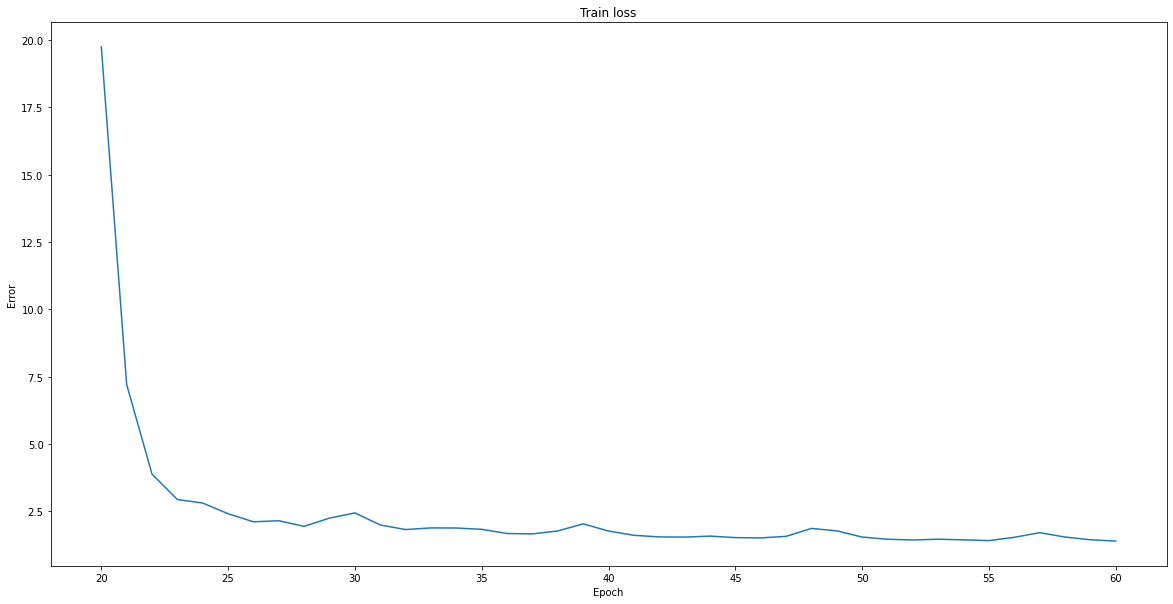

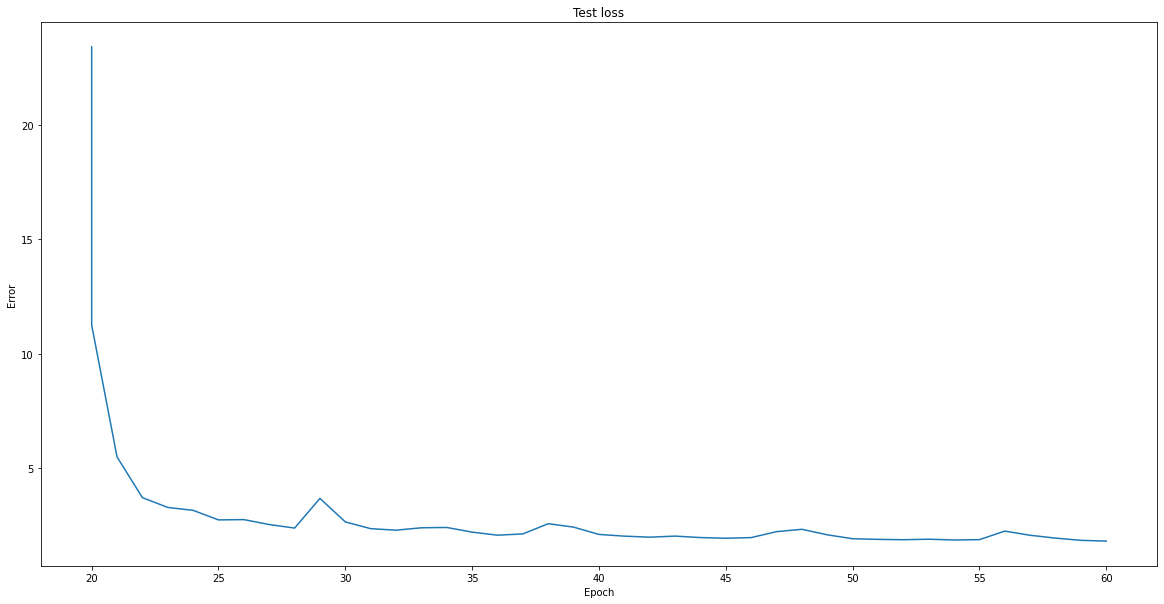

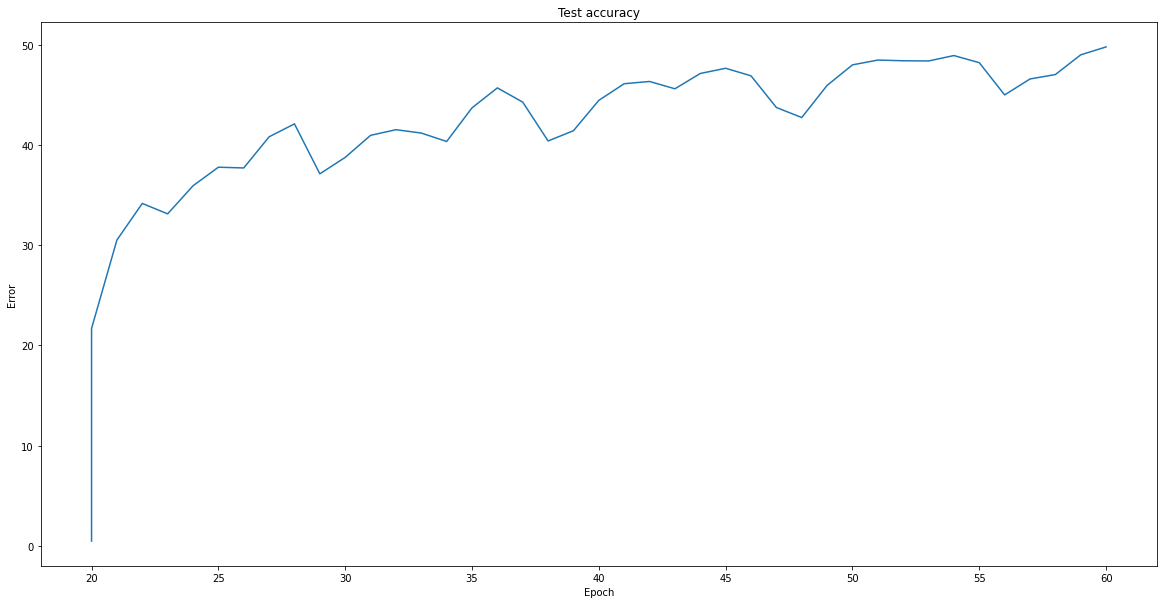

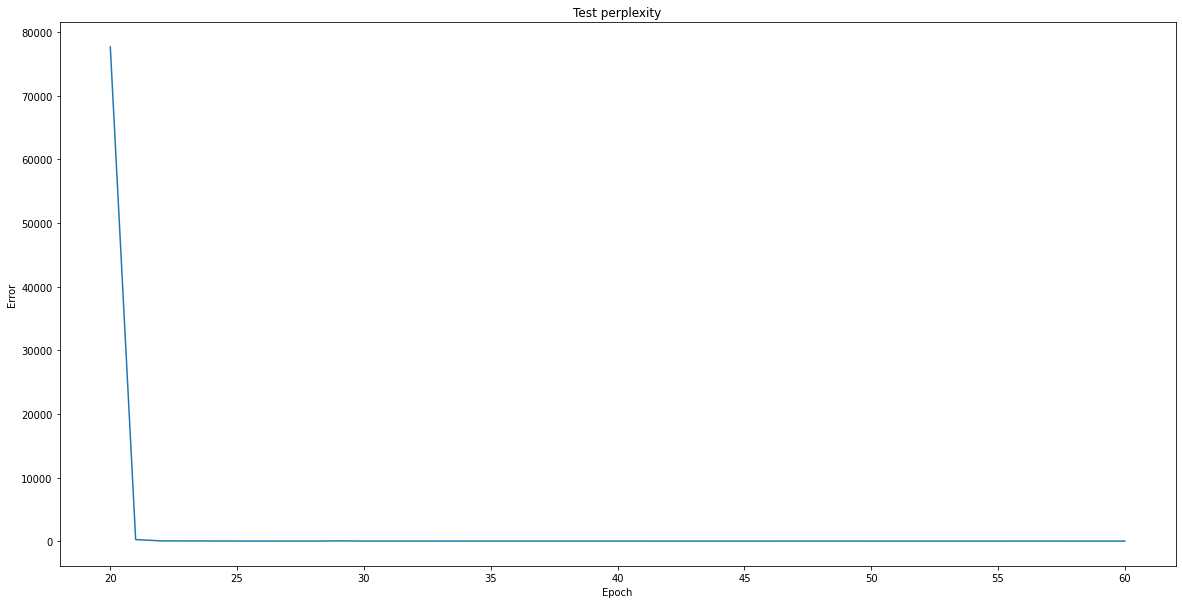

In [49]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 60
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log88.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'baskerville_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'baskerville_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')
    # start_epoch = 0

    train_losses, test_losses, test_accuracies, test_perplexities = pt_util.read_log(LOG_PATH, ([], [], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            test_perplexities.append((epoch, math.exp(test_loss)))
            print("perplexity: " + str(test_perplexities))

            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = ' Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.'
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 33)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        ep, val = zip(*test_perplexities)
        pt_util.plot(ep, val, 'Test perplexity', 'Epoch', 'Error')

        return model, vocab, device

final_model, vocab, device = main()

Part 8 number 3:

In [ ]:

TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.mid_size = int((feature_size - vocab_size) / 2)
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        self.linear_pass = nn.Linear(self.feature_size, self.feature_size)
        self.lstm = nn.LSTM(self.feature_size, self.feature_size, num_layers=2, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        # x = self.linear_pass(x)
        # x = F.relu(x)
        # x = self.linear_pass(x)
        # x, hidden_state = self.gru(x, hidden_state)
        x, hidden_state = self.lstm(x, hidden_state)
        # x, hidden_state = self.lstm(x, hidden_state)
        # x = self.linear_pass(x)
        # x, hidden_state = self.gru2(x)
        x = self.decoder(x)
        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

Using device cuda
num workers: 2
Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	D]êêêêê’’’ JJKvc5uP]hEêz.zWK5’rk[rc”n[7MT[Jhk’OkIn7#’’’’’’’’E]zz‘tv.'c)﻿)KKKKtD nKTTnEê)““nknH88c7’ê




  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 16.7589, Accuracy: 1480/76800 (2%)



 25%|██▌       | 3/12 [00:00<00:01,  5.86it/s]

Train Epoch: 0 [0/3072 (0%)]	Loss: 16.448673


100%|██████████| 12/12 [00:01<00:00, 10.63it/s]

Train Epoch: 0 [2560/3072 (83%)]	Loss: 11.682263


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	twJ     oeiiee aooe , aneestywhes iogld ’s’’.aatec”#I      aaa”#‘ns sn)   twhssksdjid ad  det lndear



Test set: Average loss: 10.5992, Accuracy: 19789/76800 (26%)

Saved /content/checkpoints/000.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. #ne.”                                                                                                                                                                                                  
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. #nedy on loed.”  

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.#nedy.”                                                                                                                                                                                                 



 17%|█▋        | 2/12 [00:00<00:01,  5.23it/s]

Train Epoch: 1 [0/3072 (0%)]	Loss: 9.997840


100%|██████████| 12/12 [00:01<00:00, 10.35it/s]

Train Epoch: 1 [2560/3072 (83%)]	Loss: 5.114412


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	Gf      aac T. taan  ei errd ther Ioandd.k   trre ”        roo Hunr rf) u..fas ff ka eif eret  sd li



Test set: Average loss: 5.5825, Accuracy: 24771/76800 (32%)

Saved /content/checkpoints/001.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.         “Whay sholl, susir, fror.”       “Whallon.        “BœMor pron2.”      “Nooor,        Iswe sholdes, sime in dircead to        hend in gar fror.”       “Whallon.        “BœMor pron2.”      “Noo
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.         “Whaly nar

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.        “Noow dacre to        ofet cusenince-if rof fetelet wither in         his deallon.         “Buske?”       “ifes ifes ifes bime ifes felifet wen          his sifeseenife in dima froor crry mir,



 25%|██▌       | 3/12 [00:00<00:01,  5.69it/s]

Train Epoch: 2 [0/3072 (0%)]	Loss: 4.792214


100%|██████████| 12/12 [00:01<00:00, 10.45it/s]

Train Epoch: 2 [2560/3072 (83%)]	Loss: 3.164151


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	 d      eokitd  oine eo ennd nhet Iaatdfuk    or  ”H     œœymi Bontenna u  uhs fnttisiwf ana  an  ah



Test set: Average loss: 3.6232, Accuracy: 27542/76800 (36%)

Saved /content/checkpoints/002.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. I has a       you wille of the have has in       himappicated a by had day which have had        had a       up       of the has in      himappicated a by had day which have had        had a       up
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.       œodod, fan y

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.on       himamis alther, with hae howelll to deod the husglestsm. A       loook cond. But supoon fing      mookince tose of theet, man ne inat, in hrowe odod a        know.”        “Has faly wihhhrow?



 25%|██▌       | 3/12 [00:00<00:01,  5.65it/s]

Train Epoch: 3 [0/3072 (0%)]	Loss: 2.969959


100%|██████████| 12/12 [00:01<00:00, 10.50it/s]

Train Epoch: 3 [2560/3072 (83%)]	Loss: 2.375006


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	’d     “oenitt taane ev entd thet tear sum   oan         ““e.. Tentencaoneeths an ti ehf eee  and ti



Test set: Average loss: 2.8963, Accuracy: 30020/76800 (39%)

Saved /content/checkpoints/003.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.         “Mr. Whis he hen a been the presse man whe here cane an        weren an ever and         wenthere fore an a leat the sure man whe here an a clear there an         werent         cannerse wher
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.         “Why him w

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.       “Ye mea in      whes have not         eveen the sup, tee neceven         and everpose fother the spen a gess cons tle carte they donver whind. “There of an bearfined hing dircable abland a bral



 25%|██▌       | 3/12 [00:00<00:01,  5.60it/s]

Train Epoch: 4 [0/3072 (0%)]	Loss: 2.303206


100%|██████████| 12/12 [00:01<00:00, 10.47it/s]

Train Epoch: 4 [2560/3072 (83%)]	Loss: 2.288140


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	 b      ooz?cg hoon   o innd whrs ioss sus   ooce          o.. Tonrnnsyou  fis  f hi  wf icu   nd hi



Test set: Average loss: 2.9937, Accuracy: 28355/76800 (37%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The moor, which has sir, is        is or is or is orsiour firs if is in mor.          unance with sicicable fas in much my spicicable firis if in my         cours of is is is is oris or is orsiour fi
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.            “You ampay as        in much sin as by my 

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.You go you of will I have      hros?”       “Yous has itic I ficulitions of is thas viriHow good do. That is of only vitos; fance is of a posioppopicied Holmos ir,        an I has? roubl nords of Sir 



 17%|█▋        | 2/12 [00:00<00:01,  5.49it/s]

Train Epoch: 5 [0/3072 (0%)]	Loss: 2.376353


100%|██████████| 12/12 [00:01<00:00, 10.44it/s]


Train Epoch: 5 [2560/3072 (83%)]	Loss: 2.276810
Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	 o      iezatg taene et entd thet weasdsusa  trten         y.t Tondensyons tas  tdta ewf eee   nd si



Test set: Average loss: 2.7987, Accuracy: 30629/76800 (40%)

Saved /content/checkpoints/005.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.              men Dr. Morter.              meG, Dr. Mort. The was         metterng was          methen a some to leas had          pleack         face was        meland some to leather was         met
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was s

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.           Henry over your      Henrys to peelcet was very the was dit. I ame to alle to cleame, the was a was supen the tole me tole muse?”          be lad officenr. I was ame to heavile. Hall       



 25%|██▌       | 3/12 [00:00<00:01,  5.54it/s]

Train Epoch: 6 [0/3072 (0%)]	Loss: 2.223830


100%|██████████| 12/12 [00:01<00:00, 10.47it/s]

Train Epoch: 6 [2560/3072 (83%)]	Loss: 1.929788


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	 o      ein?ng toeue  t entd toet teaddgem   ooce        ““y.. Tontenfyou  fhs ft te ehf ice  and ti



Test set: Average loss: 2.4222, Accuracy: 32693/76800 (43%)

Saved /content/checkpoints/006.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The we so like with the strange of the some to of the some to of the some to of the some to of the some to of the some to of the some to of the some to of the some to of the some to of the some to of
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The in took       

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.And whe to ldere for ther comess fould rubpe whe to wan I wauts the more ot gree mil.       “The wsily was my ble the me ville to be cright ware milly dextraly. “Welowlkend to which he hould sour sje 



 25%|██▌       | 3/12 [00:00<00:01,  5.56it/s]

Train Epoch: 7 [0/3072 (0%)]	Loss: 1.894807


100%|██████████| 12/12 [00:01<00:00, 10.53it/s]

Train Epoch: 7 [2560/3072 (83%)]	Loss: 2.267013


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	ii      ritatg truwstttttttd thet tetrdhut d trted I      “y.t Torrrtryond,ths tt ti ttt aeut trd sr



Test set: Average loss: 2.8424, Accuracy: 28861/76800 (38%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. I have the to the took the took the took the took the took the took the took the took the took the took the took the took the took the took the took the took the took the took the took the took the t
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. Thet,      the tlet-tiI’s clurstaid he, is to the toe

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.      mattet, soncve?”       “Watte, tow?”        “I how the togted, whiche hubte, yoursh, the you, sit, with dright. I dris, martionss, the was othe ust, this tookecting yone. I ward sugh to heve by 



 17%|█▋        | 2/12 [00:00<00:01,  5.39it/s]

Train Epoch: 8 [0/3072 (0%)]	Loss: 2.283864


100%|██████████| 12/12 [00:01<00:00, 10.44it/s]

Train Epoch: 8 [2560/3072 (83%)]	Loss: 1.964298


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        eei?ng baene eh engd thet hearghet   tece          y.t Tortetgyone has bn te ehf ice  bnd ti



Test set: Average loss: 2.4275, Accuracy: 31895/76800 (42%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The mare          one has be a gairst that the shought one a be sure fore he has be a gairst one a be surpers upon the moore he has be a gairst one a be surpers upon the moore he has be a gairst one 
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The       has goner, and, re latson, but a knone’t ha

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.I have re heard one hat is pererstionperes. The se a grefs the swible gre alles. The was a explexed so mider,       un blambers of ear he shat pores shouldy upon leathome       I agaid examill that he



 17%|█▋        | 2/12 [00:00<00:01,  5.35it/s]

Train Epoch: 9 [0/3072 (0%)]	Loss: 1.902327


100%|██████████| 12/12 [00:01<00:00, 10.27it/s]

Train Epoch: 9 [2560/3072 (83%)]	Loss: 1.762699


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        een?ng aoane vanennd ahet Ieardhes   aete         “y.t Tontenaaon  ahs bt ti eaf ieu  and ai



Test set: Average loss: 2.2272, Accuracy: 34050/76800 (44%)

Saved /content/checkpoints/009.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The man we has be are are are are are are and and and were and and a was a were and and a was a were and and a was a were and and a was a were and and a was a were and and a was a were and and a was 
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. I kindowning pitio

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.An in every man, ander a grand far lad, wer      “Capy that black were fard an nesservil life that evened s!” I      prievend ang, and surned could not coldnger. Shent conlyl darrdied againg anat, but



 25%|██▌       | 3/12 [00:00<00:01,  5.58it/s]

Train Epoch: 10 [0/3072 (0%)]	Loss: 1.733767


100%|██████████| 12/12 [00:01<00:00, 10.57it/s]

Train Epoch: 10 [2560/3072 (83%)]	Loss: 2.092172


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        eet?ng  aane    ennd  het  eatdhet d  anen         y.. Hattetfyond ahs  f  i eff ice  and  i



Test set: Average loss: 2.4983, Accuracy: 32315/76800 (42%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.             “Why had say                         enausable                             leand a                    leand a say                       enaue as a say face which               in my deat 
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.        The         and         a casas fate        ba

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.       He facce in         fring my lace ind Swhich        We claced dic find My  diden fal a say       the runal up himh faiusa.           “In in which          a cinitling catix             deating 



 25%|██▌       | 3/12 [00:00<00:01,  5.37it/s]

Train Epoch: 11 [0/3072 (0%)]	Loss: 2.015552


100%|██████████| 12/12 [00:01<00:00, 10.52it/s]

Train Epoch: 11 [2560/3072 (83%)]	Loss: 1.804732


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        eii?ng  oane    enn   het  ear hes d oece         “y.. Torrrnfyon ifis if  i eif ice   nd  i



Test set: Average loss: 2.3171, Accuracy: 32951/76800 (43%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The man        in in        in on        in man which         in man on       finded with is        in of his finded with is        in of his finded with is        in of his finded with is        in 
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. Sir       Hurried Hall man      arrisfere frien my sm

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.Wishor’s a gened of find out have fried my       criuse un night is your       frisindersounged of in      bet within find, the the       cridel firstnsifing can on which he dexpain          fir. I   



 17%|█▋        | 2/12 [00:00<00:01,  5.21it/s]

Train Epoch: 12 [0/3072 (0%)]	Loss: 1.817651


100%|██████████| 12/12 [00:01<00:00, 10.28it/s]

Train Epoch: 12 [2560/3072 (83%)]	Loss: 1.791837


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        eiiing tooni  t innt toet wetddhut d toce          y.t Toftrlfyonditii in ti iff  cu   nd wi



Test set: Average loss: 2.5179, Accuracy: 32462/76800 (42%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. This           in the for to the                light of the                 light of the                light of the                light of the                light of the                light of t
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. A Rond te        tow with tookn wight       thing to 

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.“Tho be entwing for two gottly with usiting of        Sir Charld muctly convick.’. It sin one confor of ming my dealffors himm. This         intown to          must befor-blong neve his          if th



 25%|██▌       | 3/12 [00:00<00:01,  5.58it/s]

Train Epoch: 13 [0/3072 (0%)]	Loss: 2.047037


100%|██████████| 12/12 [00:01<00:00, 10.42it/s]

Train Epoch: 13 [2560/3072 (83%)]	Loss: 2.026635


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	oo      oonong ooooo vo onnd ooat Ioas hus d orre         “y.o Tofrslfoon  ooy ot oi .wf icu   nd ai



Test set: Average loss: 2.6092, Accuracy: 30863/76800 (40%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The my my from word of the           look of this or, word of this or, word of this or, word of the            look of this or, word of this or, word of this or, word of the            look of this o
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. From I rounck of Barrymore. runk or oving my wor, its

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.The muser,           ‘oord overy of my looked      it. Ther is or,      ‘roordow.”         “Whatsoo, his or, of own or of this noverstsoook of this of       on his orkown of the        look own or of 



 17%|█▋        | 2/12 [00:00<00:01,  5.09it/s]

Train Epoch: 14 [0/3072 (0%)]	Loss: 2.126900


100%|██████████| 12/12 [00:01<00:00, 10.08it/s]

Train Epoch: 14 [2560/3072 (83%)]	Loss: 1.782454


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	 i      eit?ng hoooe v  entd that hear het d tete         “y.. Hortrlfooneiihs it ti ehf ece  and hi



Test set: Average loss: 2.2144, Accuracy: 34048/76800 (44%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. I        to to see to see had to be a strage him to see me had be a could reard he had reard her had reard her had reard her had reard her had reard her had reard her had reard her had reard her had 
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. I comments burring Somet onar me       stoldied to st

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.I flusince of for poites shapes in       eThims grage it spopession or which Hugh, so do lookder a his poriton,       elight endurneside not a ractsomore him upon old       foom more nwardred would de



 17%|█▋        | 2/12 [00:00<00:01,  5.28it/s]

Train Epoch: 15 [0/3072 (0%)]	Loss: 1.740076


100%|██████████| 12/12 [00:01<00:00, 10.23it/s]

Train Epoch: 15 [2560/3072 (83%)]	Loss: 1.593443


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        riw?ng taeue vt ennd thet hegrdhet d tene          y.. Tortrtfyond tes tn tereff ice  and ht



Test set: Average loss: 2.0529, Accuracy: 35404/76800 (46%)

Saved /content/checkpoints/015.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The moor, and I am a was the reards of the                                 light of a pinter of the brother face when he were been                                            eling and hower on the mo
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. For am grear, they

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.Whoo?’”        “Exackly, two in the but must      thrught in a he a frinng solong wairderst, for when I had ofun’t        evien.”       “This Charrof it,       afterned      folostimer. There twere hi



 25%|██▌       | 3/12 [00:00<00:01,  5.28it/s]

Train Epoch: 16 [0/3072 (0%)]	Loss: 1.595977


100%|██████████| 12/12 [00:01<00:00, 10.34it/s]

Train Epoch: 16 [2560/3072 (83%)]	Loss: 1.536991


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        een?ng hreue  tnennd thet heasdhes d toce         “y.. “orrrtryons ths hn terehf ece   nd hi



Test set: Average loss: 2.0237, Accuracy: 35721/76800 (47%)

Saved /content/checkpoints/016.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. There were some the rears of here where the reards of the rears of here where the reards of the rears of here where the reards of the rears of here where the reards of the rears of here where the rea
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. Sent place.       

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.       “But there you, hilld when Berryop there he. “If hindilys. What were      runt not were were ben of I dount, were down      and by is years he.”        Besk, which fidern jeTs,     soultly cabl



 17%|█▋        | 2/12 [00:00<00:01,  5.30it/s]

Train Epoch: 17 [0/3072 (0%)]	Loss: 1.567999


100%|██████████| 12/12 [00:01<00:00, 10.20it/s]

Train Epoch: 17 [2560/3072 (83%)]	Loss: 1.544601


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        rin ng traue  tnrnnd thet heasdhes d trce         “y.. “ostalfyond ths tn ter.tf ice   nd wi



Test set: Average loss: 2.0319, Accuracy: 35618/76800 (46%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. There is                                         las a fring in the right                                                                              “aing which he here broked with the recould not 
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.”       “Thered is       and not fright be        tirr

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.        “Her your oncer, unot        them, in/questimes        the ridge?”         I cut a mage her is prist betwered to his arred! I weverlooub just thet is       convicle.       “Where’s are the gro



 25%|██▌       | 3/12 [00:00<00:01,  5.51it/s]

Train Epoch: 18 [0/3072 (0%)]	Loss: 1.584383


100%|██████████| 12/12 [00:01<00:00, 10.52it/s]

Train Epoch: 18 [2560/3072 (83%)]	Loss: 1.539382


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        ein ng toooe vtnennd thet woas hes d tote         “y.. “ostsnfyons ths tt tir.tt  ce   nd wi



Test set: Average loss: 2.0209, Accuracy: 35844/76800 (47%)

Saved /content/checkpoints/018.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. There was                                           las a                                                las a from this                 “I as some thing thing thing thing thing thing thing thing thi
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. Whe runtins the lu

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.        “Well—whys the sign works. And him       his train billing as by eexpeding do which was be upon thin back with an is my shiser. “I some      presues the dring.”         “This briking, that was



 25%|██▌       | 3/12 [00:00<00:01,  5.60it/s]

Train Epoch: 19 [0/3072 (0%)]	Loss: 1.568224


100%|██████████| 12/12 [00:01<00:00, 10.58it/s]

Train Epoch: 19 [2560/3072 (83%)]	Loss: 1.754176


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	 a    aaaanacg aaauedvanennd ahet Iaasdhesad,aace        ““y.. Hassasaaongeahs af aareaf ice  and ai



Test set: Average loss: 2.3342, Accuracy: 33069/76800 (43%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. There as a say as as surprised as a shall as a said as a shall as a said as a shall as a said as a shall as a said as a shall as a said as a shall as a said as a shall as a said as a shall as a said 
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. I mayse eramserad as as yas shappase, and which as I 

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.Then upon whach, chase a beriadlay, a nexised ayse. These ared a such as a smalse, assid had, asgars a is sprac1       shapepay, aface, as has have apedar anarad as whan as askervile ganare, and a las



 25%|██▌       | 3/12 [00:00<00:01,  5.60it/s]

Train Epoch: 20 [0/3072 (0%)]	Loss: 1.877405


100%|██████████| 12/12 [00:01<00:00, 10.41it/s]

Train Epoch: 20 [2560/3072 (83%)]	Loss: 1.743751


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        eining taawedvtnennd thet heasdhes d oece         “y.. Tousalfyond eis an  e etf ece  tnd Ii



Test set: Average loss: 2.0964, Accuracy: 35349/76800 (46%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The man one of his        one of the can one of the campleton,         his exculd not        one of the moor. I have seen        of the man of his        one of the can one of the campleton,         
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.”        “Well, he in       Challe gre.”        “Speon

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.A      Mr. But      over pried with        the reing 4xtiek-savien in the        Dr. Ollowing on evide. Tho him hed read round       grainate wills wildway.”       “Good new ofld use over that mind wa



 25%|██▌       | 3/12 [00:00<00:01,  5.57it/s]

Train Epoch: 21 [0/3072 (0%)]	Loss: 1.650349


100%|██████████| 12/12 [00:01<00:00, 10.61it/s]

Train Epoch: 21 [2560/3072 (83%)]	Loss: 1.613489


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        riw ng toowe   nennd that  oatdhut d toce          y.. Hortatfyons fis  n  i  ff ice   nd  i



Test set: Average loss: 2.0438, Accuracy: 35482/76800 (46%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The moor two on the                                                                                          lace of his                                                                               
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. This in          owner.       “very rut not of Basker

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.This upon the untion from alway, if he word rusen frannect      Barry of Barsly of whin finnight        tip, und, thow_ for         troubly durrising for two know much one whet in Dr.       Mr. Holmes



 17%|█▋        | 2/12 [00:00<00:01,  5.06it/s]

Train Epoch: 22 [0/3072 (0%)]	Loss: 1.596504


100%|██████████| 12/12 [00:01<00:00, 10.17it/s]

Train Epoch: 22 [2560/3072 (83%)]	Loss: 2.127657


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	ii      oiiing ioeut vitentt ioet Iegrthut d yece         “yii Bottetfyongiiis it io eif ice  ini ii



Test set: Average loss: 2.6336, Accuracy: 30858/76800 (40%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The                                                                                                                                                                                           a light o
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.”          Dr. Mortimer leanipiting you wild it it ini

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.       “It themer ininininition.”        A were initing-iting to repinininitiation Mrire.”        “I givinigininginingizing outt,        itir diriging of to to be         of hgainig.”        “You the 



 17%|█▋        | 2/12 [00:00<00:01,  5.35it/s]

Train Epoch: 23 [0/3072 (0%)]	Loss: 2.154196


100%|██████████| 12/12 [00:01<00:00, 10.41it/s]

Train Epoch: 23 [2560/3072 (83%)]	Loss: 1.690497


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        eatang ireoe  tnennd toet Ieasdhes d,tace         “y.. “outatfyons ihs  n ti  ff eee   nd si



Test set: Average loss: 2.1403, Accuracy: 35145/76800 (46%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The from he him he heart of the                                                                                                                             leargened of the                           
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. Thereful undrow that confiest       fear of fretence 

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. Trately our mans before       to loker        dursupect freem an         him mean which death he trat you Lears from one his of came his gentoat! Why open while xinfited      morewars apperefe-pectam



 25%|██▌       | 3/12 [00:00<00:01,  5.47it/s]

Train Epoch: 24 [0/3072 (0%)]	Loss: 1.660701


100%|██████████| 12/12 [00:01<00:00, 10.45it/s]

Train Epoch: 24 [2560/3072 (83%)]	Loss: 1.510722


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        eiw ng treue vtnennd thet teardhes d trce         “y.. Bortatfyond ahs an te eff ice  and tr



Test set: Average loss: 1.9433, Accuracy: 37035/76800 (48%)

Saved /content/checkpoints/024.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The man was a man was a repress at the         presen and were had reporting to                                                                                                                        
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.        “Goundervon

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.She that were, Basker,       as I shumm!”        not came.”       “How you very much hories and forms!”        “And which untreed to his good.        What However that to brout on may     courly of in



 17%|█▋        | 2/12 [00:00<00:01,  5.29it/s]

Train Epoch: 25 [0/3072 (0%)]	Loss: 1.492550


100%|██████████| 12/12 [00:01<00:00, 10.24it/s]

Train Epoch: 25 [2560/3072 (83%)]	Loss: 1.442208


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        eiwnng aaeue  tnennd thet heasdhus d tace         “y.. Horgatfyons fhs an ti eff ice  and hi



Test set: Average loss: 1.8559, Accuracy: 37952/76800 (49%)

Saved /content/checkpoints/025.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The man was a crimparing and which has been and and we were the reaturned and we were the reaturned and we were the reaturned and we were the reaturned and we were the reaturned and we were the reatu
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.”        I could no

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.This great ver, poing with grove the you on that doo racht wheire would runkne without of. me,        well you voical very in down but you will positions. The wolld ong that the ldenan. Someth in you 



 17%|█▋        | 2/12 [00:00<00:01,  5.26it/s]

Train Epoch: 26 [0/3072 (0%)]	Loss: 1.425162


100%|██████████| 12/12 [00:01<00:00, 10.20it/s]

Train Epoch: 26 [2560/3072 (83%)]	Loss: 1.416368


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        einnng taaue  tnennd thet heasdhas d tace         “y.. “outatfyons fhs an ti etf ice  and hi



Test set: Average loss: 1.8371, Accuracy: 38280/76800 (50%)

Saved /content/checkpoints/026.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The man who was a surprise                                                                                                                                    a laffairs and                           
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. I       as       u

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.They runt, what       mean said down that we has exit inat enession his œood, as I have some in ana word-ritou London, sirve, thatsy saw everypont       the maring, his eight of as vourry, hurneatural



 17%|█▋        | 2/12 [00:00<00:01,  5.50it/s]

Train Epoch: 27 [0/3072 (0%)]	Loss: 1.399360


100%|██████████| 12/12 [00:01<00:00, 10.26it/s]

Train Epoch: 27 [2560/3072 (83%)]	Loss: 1.423234


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        eiwnng taeue  tnennd thet teasthas d tate         “y.. Bautatfyons ths tt ti  tf ice  tnd ti



Test set: Average loss: 1.8511, Accuracy: 37950/76800 (49%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The man which has been the                                                                                                                                                                             
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The       atter was Mr. Hallf, shast!”       “A dival

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. Jo see       his thoall.”       The by on seems this mettimes for you of the facts we can evicle it           pot it melang that catman’s true this intedmastrage.”        Dr. “Why thrundon’t knwhere 



 17%|█▋        | 2/12 [00:00<00:01,  5.25it/s]

Train Epoch: 28 [0/3072 (0%)]	Loss: 1.411368


100%|██████████| 12/12 [00:01<00:00, 10.22it/s]

Train Epoch: 28 [2560/3072 (83%)]	Loss: 1.489704


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        ritnng wreue  tnentd whet tettthet d uate         “y.t “ottattyons fht tt ti  ff ice  bnd wi



Test set: Average loss: 1.9414, Accuracy: 36200/76800 (47%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The matter which he                                                                                                                 laight for the                                                     
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.      “It sight          you waited him two go that th

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.       This breat      the venigathte for murtes. The      datest’s of sispirtaties convest it is one the worland whete sequat my lite fatelt you never the brathought him upon this myspleate waite tha



 25%|██▌       | 3/12 [00:00<00:01,  5.35it/s]

Train Epoch: 29 [0/3072 (0%)]	Loss: 1.503277


100%|██████████| 12/12 [00:01<00:00, 10.37it/s]

Train Epoch: 29 [2560/3072 (83%)]	Loss: 1.492443


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	 t      eewnng ooece  tnennd ohet hettdhec d oece        ““y.t “ouralfyons oer tt te eff ice  bnd wi



Test set: Average loss: 1.9095, Accuracy: 37366/76800 (49%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The moor of the                                                                                                                                                                                        
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.”        “There wre the refuller upon wheir occutse tr

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.And you ir returet. Wever),     stravele for us. Lothre or at comonet—the wonext looking of the facked him a came       morely to the         coverthey seems on ever the good of your other much I     



 17%|█▋        | 2/12 [00:00<00:01,  5.24it/s]

Train Epoch: 30 [0/3072 (0%)]	Loss: 1.478755


100%|██████████| 12/12 [00:01<00:00, 10.18it/s]

Train Epoch: 30 [2560/3072 (83%)]	Loss: 1.469805


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        oawnng aaecs  anennd ahet Ieasdhas d aace         “y.. Boutatfyons oes tt te eaf  ce  and ai



Test set: Average loss: 1.9173, Accuracy: 37067/76800 (48%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The matter was        one of a cassome of a cassome of a cass of a cassure of a cassome of a cassome of a cass of a cassure of a cassome of a cassome of a cass of a cassure of a cassome of a cassome 
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.”         “In as you the       toold possibiling aken 

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.        “But theer the once a ragen from it you to facte. And pacen to the man to lean! spokerland was strapced us or vileral, unlow, my bens body told will ben facts, windown to the gat the ot that t



 17%|█▋        | 2/12 [00:00<00:01,  5.14it/s]

Train Epoch: 31 [0/3072 (0%)]	Loss: 1.473920


100%|██████████| 12/12 [00:01<00:00, 10.11it/s]

Train Epoch: 31 [2560/3072 (83%)]	Loss: 1.418086


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        eennng aaeue  onennd toet weasdhas d oace         “y.. “outalfyons oas an  e eaf ice  and wi



Test set: Average loss: 1.8530, Accuracy: 37776/76800 (49%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The man was a conce of the moor. The man was a conce of the moor. The man was a conce of the moor. The man was a conce of the moor. The man was a conce of the moor. The man was a conce of the moor. T
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.       “To for race how ville our who like        as e

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.        “Twords and fiend a much and how help good toold aways a head to be window my dive head of it but       with hossible man a chapleance of your        lightes, and wear  to leave you out       



 17%|█▋        | 2/12 [00:00<00:01,  5.19it/s]

Train Epoch: 32 [0/3072 (0%)]	Loss: 1.418738


100%|██████████| 12/12 [00:01<00:00, 10.19it/s]

Train Epoch: 32 [2560/3072 (83%)]	Loss: 1.404714


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        eennng aaeue  anennd  oat weasdhas d uace         “y.. Hautalfyons oes an  e eaf ice  and ai



Test set: Average loss: 1.8466, Accuracy: 37904/76800 (49%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The man was a compan and all that in                                                                                                                                                                   
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. To my        anating       at it saw to be Statell.” 

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. I knew perhaps their that could and to be latter       Re oppend of the night         a costand that you are nevone zeally faNo, no,        Sir Henry’s gatme, have Cuall you dea time fatural. Sir Cha



 17%|█▋        | 2/12 [00:00<00:01,  5.21it/s]

Train Epoch: 33 [0/3072 (0%)]	Loss: 1.415622


100%|██████████| 12/12 [00:01<00:00, 10.10it/s]

Train Epoch: 33 [2560/3072 (83%)]	Loss: 1.403644


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        eannng ooose  onennd that Ieasdhas d oace         “y.. “outalfyons ohs on ti  af ice  and wi



Test set: Average loss: 1.8319, Accuracy: 38107/76800 (50%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The man who will be a suppose of the                                                                                                                                                                   
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.”       “That very you vions on known rath. Did       

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.This butle with ficall upon the fold man who gave the something look came that I should would that I had passe, Mr. That my sholimes dravien. You know, that least         which I begansom, but       M



 17%|█▋        | 2/12 [00:00<00:01,  5.19it/s]

Train Epoch: 34 [0/3072 (0%)]	Loss: 1.391029


100%|██████████| 12/12 [00:01<00:00, 10.33it/s]

Train Epoch: 34 [2560/3072 (83%)]	Loss: 1.365867


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        eennng aaeue  tnennd thet heasdhas d tace         “y.. Hautanfyons fhs an  i eaf  ce  and wi



Test set: Average loss: 1.8027, Accuracy: 38586/76800 (50%)

Saved /content/checkpoints/034.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The man what we were to                                                                                                                                                                                
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. There is Mrscifier

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.         “Why should name himself.          man thinknew by you have been that       unchat was so a brat anone        think may what a chance should and andrawn of           if Dr. Mor, and on, and h



 17%|█▋        | 2/12 [00:00<00:01,  5.27it/s]

Train Epoch: 35 [0/3072 (0%)]	Loss: 1.364966


100%|██████████| 12/12 [00:01<00:00, 10.40it/s]

Train Epoch: 35 [2560/3072 (83%)]	Loss: 1.376735


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        eannng araue  anennd thet haasdhas d aace         “y.. Hautanfyons fhs an  e eaf  ce  and ai



Test set: Average loss: 1.8132, Accuracy: 38382/76800 (50%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The man who was                                                                                                                                                                                        
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. There is expeasange. Shere,       an you man what be 

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.Bearly at me.”        “Dive you wind happy who have paped broak his eas!       ‘Good;be man undence fat I      openin and acrate crat as not seen; and ready face when has been          a cry—ing him w



 17%|█▋        | 2/12 [00:00<00:02,  4.93it/s]

Train Epoch: 36 [0/3072 (0%)]	Loss: 1.379726


100%|██████████| 12/12 [00:01<00:00, 10.01it/s]

Train Epoch: 36 [2560/3072 (83%)]	Loss: 1.366550


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        eennng aaaue  anennd thet weasdhas d tace         “y.. Bouranfyond fhs an  e eaf ice  and ai



Test set: Average loss: 1.7926, Accuracy: 38699/76800 (50%)

Saved /content/checkpoints/036.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The man who was                                                                                                                                                                                        
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. down the sair.    

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.        “I had       all the lead to you to getat as shep-poke of in the reason vilil with the year man]      of the frox-poortan to an in in to        unall.”        Staple, solvelone,       a Watson



 17%|█▋        | 2/12 [00:00<00:01,  5.19it/s]

Train Epoch: 37 [0/3072 (0%)]	Loss: 1.358065


100%|██████████| 12/12 [00:01<00:00, 10.03it/s]

Train Epoch: 37 [2560/3072 (83%)]	Loss: 1.356633


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        eennng treue  tnennd that teasdhas d tace         “y.. Hauranfyons ahs an ti eaf ice  and ai



Test set: Average loss: 1.7777, Accuracy: 38944/76800 (51%)

Saved /content/checkpoints/037.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The man who was a surprise                                                                                                                                                                             
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. I tumaker andian w

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.That and wheen stair       hain,       answered and man appaining which Holmemngs to from metil he brough in night,        but over traig? ‘rymou, and agains. Lon courner cand a can       grain franan



 25%|██▌       | 3/12 [00:00<00:01,  5.28it/s]

Train Epoch: 38 [0/3072 (0%)]	Loss: 1.343038


100%|██████████| 12/12 [00:01<00:00, 10.28it/s]

Train Epoch: 38 [2560/3072 (83%)]	Loss: 1.329835


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        eennng taese  tnennd thet heasdhas d tace         “y.. Hauta fyons fhs an te eaf ice  and ai



Test set: Average loss: 1.7499, Accuracy: 39353/76800 (51%)

Saved /content/checkpoints/038.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The man who was a brought that the was a man what we were to                                                                                                                                           
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. But this he would 

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.       The an Momerly folland allow the face which mate wereless you from one so what I have huse faran man of       terros. There against reson London empt why he was from      Hern of dauseful to yo



 17%|█▋        | 2/12 [00:00<00:01,  5.03it/s]

Train Epoch: 39 [0/3072 (0%)]	Loss: 1.315531


100%|██████████| 12/12 [00:01<00:00, 10.11it/s]

Train Epoch: 39 [2560/3072 (83%)]	Loss: 1.316301


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        eennng trese  tnennd thet teasdhas d tace         “y.. Hauta fyons ohs an ti eaf ice  and wi



Test set: Average loss: 1.7383, Accuracy: 39519/76800 (51%)

Saved /content/checkpoints/039.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The man who was the                                                                                                                                                                                    
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.”       The and in 

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.The matter!       up that in my passon but siring.”        “But I lady see       Roder from there is not          part, few farm examinê       her. Her you can once me      broken Regin       chape. I



 25%|██▌       | 3/12 [00:00<00:01,  5.39it/s]

Train Epoch: 40 [0/3072 (0%)]	Loss: 1.305667


100%|██████████| 12/12 [00:01<00:00, 10.24it/s]

Train Epoch: 40 [2560/3072 (83%)]	Loss: 1.309303


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        eennng trese  tnennd thet teasdhas d tace         “y.. Hautanfyons ohs an ti eff ice  and wi



Test set: Average loss: 1.7317, Accuracy: 39651/76800 (52%)

Saved /content/checkpoints/040.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The man who was the still we have so be a                                                                                                                                                              
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.       “Do not to  

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.         “Waturatly. I suppossibilision acturain, wit’s that he was alrand that was outelty were        for before.”       He had on ear that his handsened it an onely out fiving with       convestive



 17%|█▋        | 2/12 [00:00<00:01,  5.29it/s]

Train Epoch: 41 [0/3072 (0%)]	Loss: 1.298508


100%|██████████| 12/12 [00:01<00:00, 10.14it/s]

Train Epoch: 41 [2560/3072 (83%)]	Loss: 1.315035


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        eennng trese  tnennd thet weasdhas d uace         “y.. Hautanfyons ohs an  i eff ice  and wi



Test set: Average loss: 1.7333, Accuracy: 39568/76800 (52%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The man who was still in a very                                                                                                                                                                        
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. Twiself.       It was lone        anaretwen Rogican c

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.      It irse     man, when       square only over that       us the stire.”         “But beyond what you to repleaced of that ting everning to the cuntreed thir Froblazd awal, no down in on me.      



 17%|█▋        | 2/12 [00:00<00:01,  5.16it/s]

Train Epoch: 42 [0/3072 (0%)]	Loss: 1.299631


100%|██████████| 12/12 [00:01<00:00, 10.18it/s]

Train Epoch: 42 [2560/3072 (83%)]	Loss: 1.361122


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        eennng arese  anennd  het heandhas d aane         “y.. Hautanfyond aes an  e eaf  ce  and ai



Test set: Average loss: 1.7981, Accuracy: 38565/76800 (50%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The man was a                                                                                                                                                                                          
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. It was are any man on to        hair reach I thin gat

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.       “I ranzed the ‘more a man unhat. He is a man wardrawled       byy wan to least       disage, but there and and was weren a fring man’s catuall typ, then, jow, Watson and       all the toes     



 25%|██▌       | 3/12 [00:00<00:01,  5.43it/s]

Train Epoch: 43 [0/3072 (0%)]	Loss: 1.360648


100%|██████████| 12/12 [00:01<00:00, 10.43it/s]

Train Epoch: 43 [2560/3072 (83%)]	Loss: 1.373273


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	 i      eannng toose  tnennd thet weasdhas d tace        ““y.. Hausalfyond fis an tia ff ici  and wi



Test set: Average loss: 1.8017, Accuracy: 38445/76800 (50%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.”        “I have seen a facts which had supperance of the stranged with a singled with the stranged with a singled with the stranged with a singled with the stranged with a singled with the stranged w
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.”        “Thell, whey heaster if this cigach with the 

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.        “They was shat flow that it may eayes, sirge.”        My find.”        “I thind in the last evening them, there?” said if he is a duectiong atte and lawy eather flight, and Shat a was rathls c



 17%|█▋        | 2/12 [00:00<00:01,  5.02it/s]

Train Epoch: 44 [0/3072 (0%)]	Loss: 1.362966


100%|██████████| 12/12 [00:01<00:00,  9.91it/s]

Train Epoch: 44 [2560/3072 (83%)]	Loss: 1.371891


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        rannng trase aanennd thet haasdhas d aace         “y.. Haura fyons ahs an teaeaf  ce  and ai



Test set: Average loss: 1.8026, Accuracy: 38659/76800 (50%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The man when he was a last                                                                                                                                                                             
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The heare in the man appla£anciely and until he      

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.I was nother sillatien frshere ame be absent that I shee all raise neath.”         “The a@ches Grod’t xackly as rare a braw, gracketrate all. I suspeal my last I ear mest say. To dong        starmed w



 25%|██▌       | 3/12 [00:00<00:01,  5.40it/s]

Train Epoch: 45 [0/3072 (0%)]	Loss: 1.357074


100%|██████████| 12/12 [00:01<00:00, 10.42it/s]

Train Epoch: 45 [2560/3072 (83%)]	Loss: 1.326125


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        eennng toese  tnennd thet heasdhas d trce         “y.. Heuta fyons fhs  n te eff  ce  bnd wi



Test set: Average loss: 1.7667, Accuracy: 39404/76800 (51%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The man when he were                                                                                                                                                                                   
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The whenere you take me a grat Sir Henry means, I hav

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.        “And deavone it, rements which lad me her ville any where if you trest         Stapleton. Menire, but your helping me to here        when when the whole countressed        from in you pression



 17%|█▋        | 2/12 [00:00<00:01,  5.27it/s]

Train Epoch: 46 [0/3072 (0%)]	Loss: 1.325976


100%|██████████| 12/12 [00:01<00:00, 10.14it/s]

Train Epoch: 46 [2560/3072 (83%)]	Loss: 1.292347


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        eennng toose  tnennd thet toasdhas d trce         “y.. Houta fyons ths tn tireff ice  and wi



Test set: Average loss: 1.7328, Accuracy: 39470/76800 (51%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. There is a should be strange the strange which                                                                                                                                                         
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.”          “I must don, straight in pinhey       every

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.Then endly undont if do him day to get a strame from whele I had not       must you know which I holdsured        high lfeshed in       white occerted with thing matter.”        “You pitly before end 



 17%|█▋        | 2/12 [00:00<00:01,  5.11it/s]

Train Epoch: 47 [0/3072 (0%)]	Loss: 1.285846


100%|██████████| 12/12 [00:01<00:00, 10.05it/s]

Train Epoch: 47 [2560/3072 (83%)]	Loss: 1.284541


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        einnng tooue  tnennd toat toasdhas d tace         “o.. Houra fyons ohs an tireff ice  and wi



Test set: Average loss: 1.7459, Accuracy: 39039/76800 (51%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The man who was some to in this                                                                                                                                                                        
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.”        The Prunknced which he did hever of        vi

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.There is voical and what my Sir conding        to four evenifing voice and Roding to home which       had before, but in to non, “It in answered, and whet       when Mortice to find of not difference 



 17%|█▋        | 2/12 [00:00<00:01,  5.19it/s]

Train Epoch: 48 [0/3072 (0%)]	Loss: 1.300282


100%|██████████| 12/12 [00:01<00:00, 10.05it/s]

Train Epoch: 48 [2560/3072 (83%)]	Loss: 1.319213


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	 a      eewnng tooue  onennd toet woasdhas d toce         “o.. Houra fyons ahs an ai eaf  ce  and wi



Test set: Average loss: 1.7812, Accuracy: 38859/76800 (51%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The man would be a compan in a conce of the moor. The face when he was a surprise a man of a conce of the moor. The face when he was a surprise a man of a conce of the moor. The face when he was a su
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The mash almost had folmone. Tho!”        “Why shoons

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.One whoman who had screal upon the inly cortain. The Holmes are of slvery naturals and a place about in which he would have a man who words up by his he       wass, and to ou, a man, as I doo. Lond of



 17%|█▋        | 2/12 [00:00<00:01,  5.29it/s]

Train Epoch: 49 [0/3072 (0%)]	Loss: 1.340555


100%|██████████| 12/12 [00:01<00:00, 10.14it/s]

Train Epoch: 49 [2560/3072 (83%)]	Loss: 1.346710


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        eennng toeue etnennd thet weasdhas d uace         “y.. Hauralfyons ahs an te eff  ce  and hi



Test set: Average loss: 1.7711, Accuracy: 39216/76800 (51%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The man when he was a fare a small come from the conviction of the conviction of the conviction of the conviction of the conviction of the conviction of the conviction of the conviction of the convic
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. I was a few          some down backben of a named, mi

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.      Hever me behind head of the facew, but I you do do you, see cleance being in then hemake, I away very were betlemen would have ground eautily. Wer’ Morther meas a gleaved me which I said Basker.



 25%|██▌       | 3/12 [00:00<00:01,  5.37it/s]

Train Epoch: 50 [0/3072 (0%)]	Loss: 1.320356


100%|██████████| 12/12 [00:01<00:00, 10.41it/s]

Train Epoch: 50 [2560/3072 (83%)]	Loss: 1.278705


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        eewnng toese  tnennd thet teasthas d tace         “y.. Haura fyons fhs tn tereff  ce  and wi



Test set: Average loss: 1.7134, Accuracy: 39810/76800 (52%)

Saved /content/checkpoints/050.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The man who was the truth in the could not help to the farther to be from the convict of the convict of the convict of the convict of the convict of the convict of the convict of the convict of the c
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.”       “But fix. B

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.        And that you had heart. I then was he wright incond, for I two conted—to'hic mas, being sto, sir, but       I go to tell me them,      but have was birst. Hered my over to phassureft your from



 17%|█▋        | 2/12 [00:00<00:01,  5.20it/s]

Train Epoch: 51 [0/3072 (0%)]	Loss: 1.268675


100%|██████████| 12/12 [00:01<00:00,  9.98it/s]

Train Epoch: 51 [2560/3072 (83%)]	Loss: 1.266783


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	 i      eennng trese  tnennd thet teasdhas d tate         “y.. Haura fyons fhs an te eff  ce  and wi



Test set: Average loss: 1.6913, Accuracy: 40230/76800 (52%)

Saved /content/checkpoints/051.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The man who was the trail we were to the facts of the moor. The face when he was a brought the state which had been the strange that the was a really from the convict of the convict of the convict of
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.”       The are the

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.        It consitate for just always face as to crioush eiter if you reolcies friend with solid of the      bround, if I confided up upon young. I turned that we have been a time time       off. Nor l



 17%|█▋        | 2/12 [00:00<00:01,  5.18it/s]

Train Epoch: 52 [0/3072 (0%)]	Loss: 1.245978


100%|██████████| 12/12 [00:01<00:00, 10.02it/s]

Train Epoch: 52 [2560/3072 (83%)]	Loss: 1.255827


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        eennng toose  tnennd thet teasdhas d tuce         “y.. Haura fyons fhs an ti eff ice  and hi



Test set: Average loss: 1.6824, Accuracy: 40349/76800 (53%)

Saved /content/checkpoints/052.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The man who was the truth in the darkness and we were the read and we were the read and we were the read and we were the read and we were the read and we were the read and we were the read and we wer
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.”         “Then way

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.Sir Hall       present takes me?”         “Nold you keep a with he write together with      the case of once which was       through him. Chat a stopped user a pripty for you see we rong an under sta?



 25%|██▌       | 3/12 [00:00<00:01,  5.23it/s]

Train Epoch: 53 [0/3072 (0%)]	Loss: 1.236940


100%|██████████| 12/12 [00:01<00:00, 10.10it/s]

Train Epoch: 53 [2560/3072 (83%)]	Loss: 1.250042


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        eennng trese  tnennd thet heasdhas d tace         “y.. Haura fyons fhs an tereff  ce  and wi



Test set: Average loss: 1.6848, Accuracy: 40230/76800 (52%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The man who was she was a surprise        man what we had a companion of the convict of the convict of the convict of the convict of the convict of the convict of the convict of the convict of the co
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. Then together, the runtil especial was       his like

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.Sir Charled earm. The together, was compleing upon of his       upon ask he     had ablexantly do. “Surely occurseted a were plane, are near evile        feat Prockscrussed me. “Hack away by we had a 



 17%|█▋        | 2/12 [00:00<00:01,  5.32it/s]

Train Epoch: 54 [0/3072 (0%)]	Loss: 1.236368


100%|██████████| 12/12 [00:01<00:00, 10.22it/s]

Train Epoch: 54 [2560/3072 (83%)]	Loss: 1.239689


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        eennng trose  tnennd thet teasdhas d tace         “y.. Haura fyons ohs an ti  ff  ce  and wi



Test set: Average loss: 1.6754, Accuracy: 40429/76800 (53%)

Saved /content/checkpoints/054.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The man who was shall was a surprise        man who was shall was a surprise and some which I had seen the moor. The face which had suppersulated me an one of the                                     
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.”       “My hoppe? 

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.The two, you call the time from my mindicate in the doorland have       that was a man as face of the provantliking for mun uptter grater he but suppressmalic frong       rathat was meanly chance of  



 25%|██▌       | 3/12 [00:00<00:01,  5.51it/s]

Train Epoch: 55 [0/3072 (0%)]	Loss: 1.228332


100%|██████████| 12/12 [00:01<00:00, 10.34it/s]

Train Epoch: 55 [2560/3072 (83%)]	Loss: 1.233127


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        eennng treue  tnennd thet heasdhas d tace         “y.. Haura fyons fhs an te  ff  ce  and wi



Test set: Average loss: 1.6732, Accuracy: 40419/76800 (53%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The man who was shall was a very                                                                                                                                                                       
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.”        “Why, you weadse throught the glapper and pra

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.I have now itgerer, bring his silen as retain laterger from the matter       Henry dany chase ir, deach I very plack by the confidenat intonion, the were in instritute hill, which we had come of the d



 25%|██▌       | 3/12 [00:00<00:01,  5.51it/s]

Train Epoch: 56 [0/3072 (0%)]	Loss: 1.224360


100%|██████████| 12/12 [00:01<00:00, 10.27it/s]

Train Epoch: 56 [2560/3072 (83%)]	Loss: 1.236709


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        eennng treue  tnennd thet heasdhas d tace         “y.. Haura fyons fhs an te  af  ce  and wi



Test set: Average loss: 1.6789, Accuracy: 40293/76800 (52%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The man who was shall was a very                                                                                                                                                                       
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.”        “BESth, which barraned a gainst memen and we 

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.In even         from is in dears again to that attent but why first        and made up in the boy’ Halled over ite night as we were to your      faces,        apair frehas, and was face aturand, reaso



 17%|█▋        | 2/12 [00:00<00:01,  5.25it/s]

Train Epoch: 57 [0/3072 (0%)]	Loss: 1.227480


100%|██████████| 12/12 [00:01<00:00,  9.96it/s]

Train Epoch: 57 [2560/3072 (83%)]	Loss: 1.234403


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        eennng taoue  tnennd thet teasdhas d tace         “y.. Haura fyons fhs an ti  ff  ce  and wi



Test set: Average loss: 1.6721, Accuracy: 40377/76800 (53%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The man who was shall was a very remained that he was a small convict of the convict of the convict of the convict of the convict of the convict of the convict of the convict of the convict of the co
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. That a deal        Cacts my frieve naturet in       h

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.        “The* has of the mooke, hour, but you prepeed to pen My        attondury amain. Do Mis was your ghat ask a befate him. Stapleton was mask prope of tresponside asamed Mr. Barrymore until when h



 25%|██▌       | 3/12 [00:00<00:01,  5.61it/s]

Train Epoch: 58 [0/3072 (0%)]	Loss: 1.220533


100%|██████████| 12/12 [00:01<00:00, 10.32it/s]

Train Epoch: 58 [2560/3072 (83%)]	Loss: 1.226785


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        eennng toose  tnennd thet teasdhas d tuce         “y.. Haura fyons ohs an ti  ff  ce  and wi



Test set: Average loss: 1.6653, Accuracy: 40532/76800 (53%)

Saved /content/checkpoints/058.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The man who was stailing from the convict of the convict of the convict of the convict of the convict of the convict of the convict of the convict of the convict of the convict of the convict of the 
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.”        It round t

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.       Aqut, and there do you legend?”        “Good down with reason facendat. We was alore to remard face.        he had no your stpress it into a was probacid tumbarked with this        impor. I hav



 17%|█▋        | 2/12 [00:00<00:01,  5.33it/s]

Train Epoch: 59 [0/3072 (0%)]	Loss: 1.215733


100%|██████████| 12/12 [00:01<00:00,  9.92it/s]

Train Epoch: 59 [2560/3072 (83%)]	Loss: 1.268931


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        eewnng wooue  onennd woet oofsdhas d ouce         “o.. Houra oyons oos  n  e  ff  ce  and wi



Test set: Average loss: 1.7558, Accuracy: 38896/76800 (51%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The man would be to see he had of the face of the moor. The face when he would be so help to help would not         be allowed to me to go out of the                                                  
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. I        agwain boy door. To runn of         Godge of

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.And had of you head of the togo of our wo.”        There Hall an a very would  upon my simp(in to the could held ow in would by Baskervill—able, but          would not be would worldge was       voice



 25%|██▌       | 3/12 [00:00<00:01,  5.30it/s]

Train Epoch: 60 [0/3072 (0%)]	Loss: 1.305259


100%|██████████| 12/12 [00:01<00:00, 10.07it/s]

Train Epoch: 60 [2560/3072 (83%)]	Loss: 1.293920


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        einnng taese  tnennd thet heasdhas d tuce         “y.. Harra fyons  hs  n  er ff  ce  and ti



Test set: Average loss: 1.7489, Accuracy: 39638/76800 (52%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.        “I have no doubt that the was he really that he was he really that he was he really that he was he really that he was he really that he was he really that he was he really that he was he reall
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.       cruse you muchability of        openizal reade 

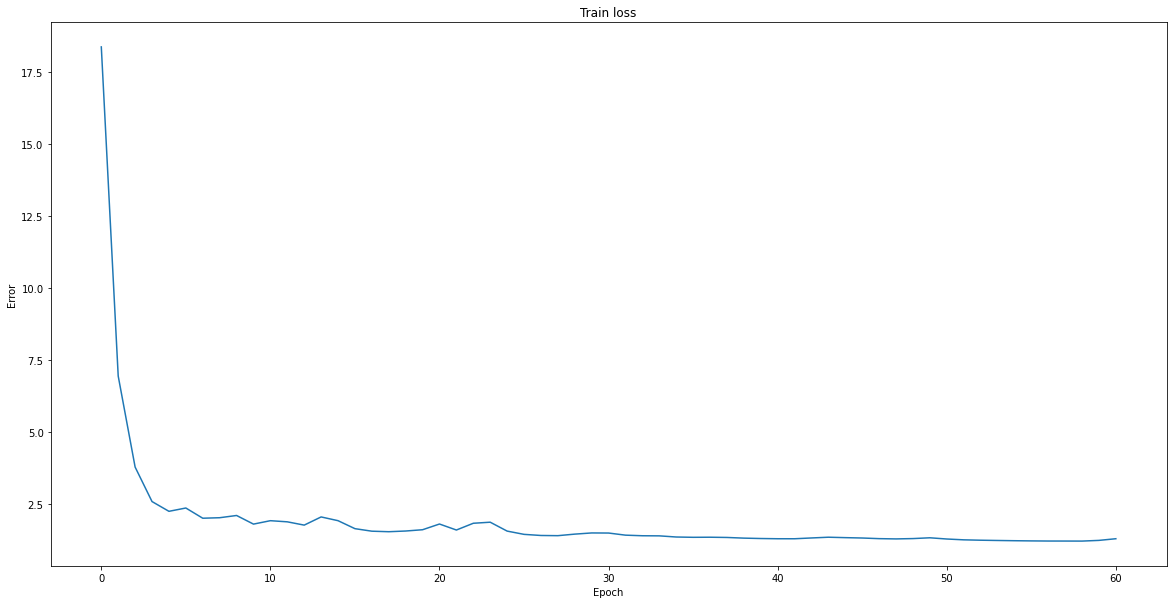

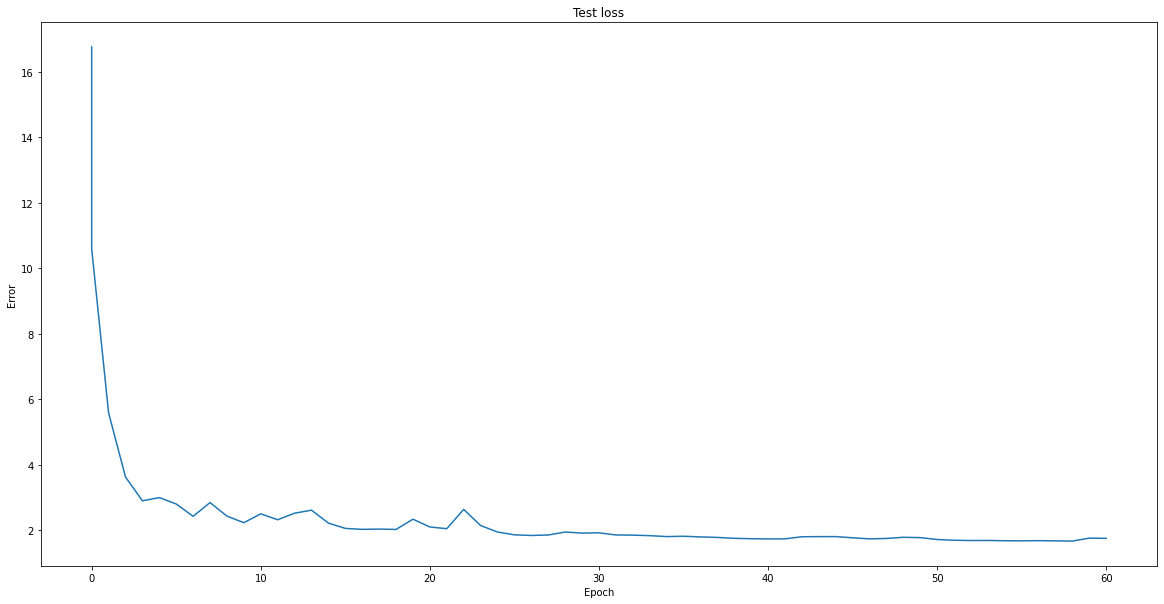

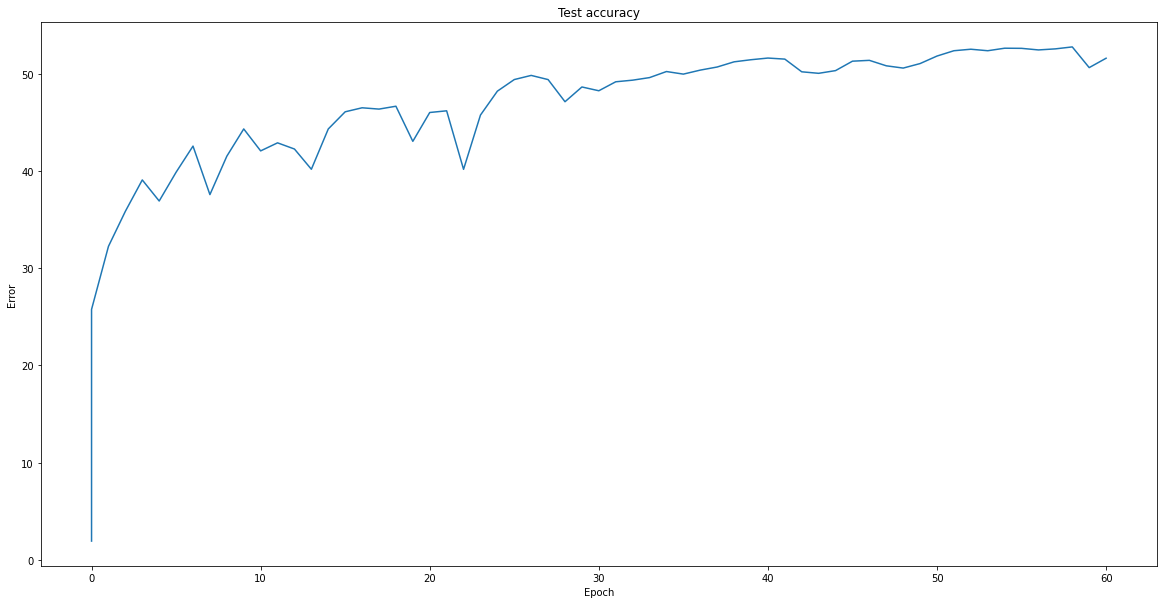

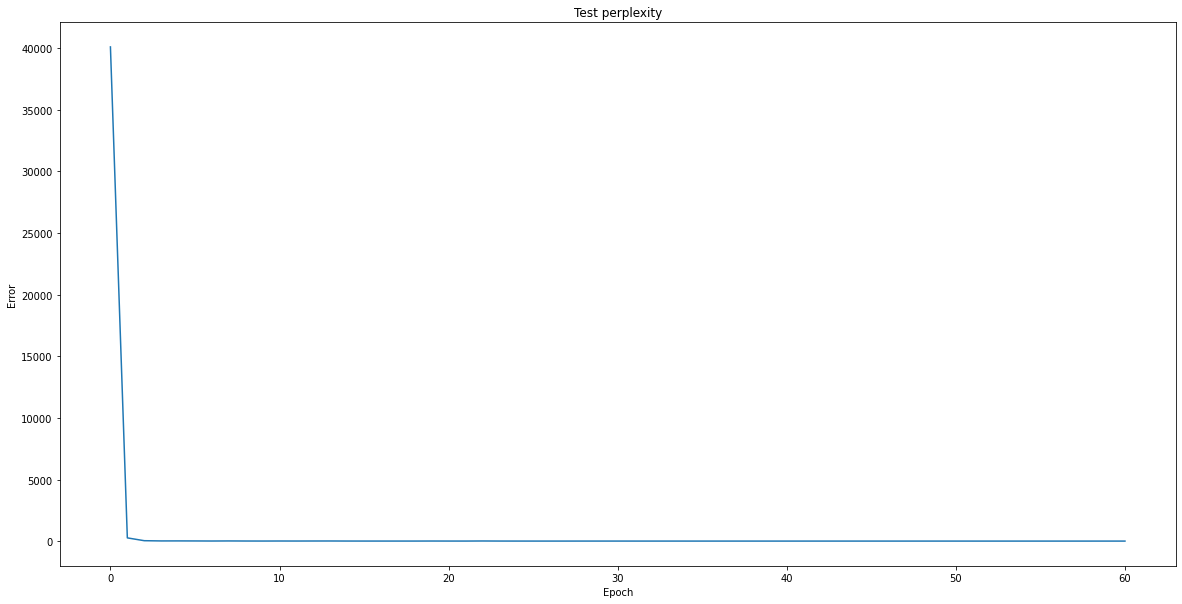

In [50]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 60
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log89.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'baskerville_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'baskerville_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    # start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')
    start_epoch = 0

    train_losses, test_losses, test_accuracies, test_perplexities = pt_util.read_log(LOG_PATH, ([], [], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))

            test_perplexities.append((epoch, math.exp(test_loss)))

            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies, test_perplexities))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = ' Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.'
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 34)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        ep, val = zip(*test_perplexities)
        pt_util.plot(ep, val, 'Test perplexity', 'Epoch', 'Error')

        return model, vocab, device

final_model, vocab, device = main()

part 8 number 3: 


In [51]:

TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.mid_size = int((feature_size - vocab_size) / 2)
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size*2)
        self.gru = nn.GRU(self.feature_size*2, self.feature_size*2, batch_first=True)
        self.linear_pass = nn.Linear(self.feature_size*2, self.feature_size*2)
        self.lstm = nn.LSTM(self.feature_size, self.feature_size, num_layers=2, batch_first=True)
        self.decoder = nn.Linear(self.feature_size*2, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        # x = self.linear_pass(x)
        # x = F.relu(x)
        # x = self.linear_pass(x)
        x, hidden_state = self.gru(x, hidden_state)
        # x, hidden_state = self.lstm(x, hidden_state)
        # x, hidden_state = self.lstm(x, hidden_state)
        # x = self.linear_pass(x)
        # x, hidden_state = self.gru2(x)
        x = self.decoder(x)
        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

Using device cuda
num workers: 2
Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	(RRbbbbb66OQxQlRX?fa-_O$8!yiFQepUX$?/U@qqUQ@FQQ7Rv@QQQQQQQQ/ ;;bKX@@$OK?fQaRQQ(b73Qp/ssRLLLXB.$$QFQ3




  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 21.5716, Accuracy: 401/76800 (1%)



  8%|▊         | 1/12 [00:00<00:04,  2.68it/s]

Train Epoch: 0 [0/3072 (0%)]	Loss: 21.846092


100%|██████████| 12/12 [00:03<00:00,  3.62it/s]

Train Epoch: 0 [2560/3072 (83%)]	Loss: 27.580000


100%|██████████| 12/12 [00:03<00:00,  3.25it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	.h      oyyaRgeaoel.. tc nsdaaher uosskp’ti,atos p”f       oy.”Sokt ttp b .airkttgpes yn  sht fndawr



Test set: Average loss: 25.3156, Accuracy: 21261/76800 (28%)

Saved /content/checkpoints/000.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. AndarRway the hesss, andarRway the hen on ar the hen on ar the hen on ar the hen on ar the hen on ar the hen on ar the hen on ar the hen on ar the hen on ar the hen on ar the hen on ar the hen on ar 
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. AndarRwas the hes

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.An’sust, andarRwat the hesss, andarRwas the hen your andarRwas the hen?”                                                       “W’ss.” “WX’ss.” The hessust andarRway the hen on ar the hen on ar the he



  8%|▊         | 1/12 [00:00<00:04,  2.27it/s]

Train Epoch: 1 [0/3072 (0%)]	Loss: 23.622793


100%|██████████| 12/12 [00:03<00:00,  3.60it/s]

Train Epoch: 1 [2560/3072 (83%)]	Loss: 10.318838


100%|██████████| 12/12 [00:03<00:00,  3.17it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	.o   iiioiyyfd,faa’t, anabrd uhet fearytccl  ulles T    “““p.e “oktenfo betfir  f aaa  f  sk  a doui



Test set: Average loss: 11.0930, Accuracy: 24403/76800 (32%)

Saved /content/checkpoints/001.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.      “Yould wiffre hadon a                         fre             willes ando wiffre            of lookedr is a               traplestance, lok in          atstrance trealliffr. Ther here          m
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. “Ther       of th

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.     “ulJ Dook in        awas     andecolmor tok in            the low in             the the logth in          the the the log’s a             trangestanceks?        in         It was      ajaplapple



  8%|▊         | 1/12 [00:00<00:04,  2.31it/s]

Train Epoch: 2 [0/3072 (0%)]	Loss: 9.233407


100%|██████████| 12/12 [00:03<00:00,  3.56it/s]

Train Epoch: 2 [2560/3072 (83%)]	Loss: 5.598110


100%|██████████| 12/12 [00:03<00:00,  3.18it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	 f    ccr:nyss haese ratelle hhet leastsesb  tetee “       r.e BomtelynBne mhs IfdIe ,lf fse  I d  i



Test set: Average loss: 6.6505, Accuracy: 27674/76800 (36%)

Saved /content/checkpoints/002.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. “Yesed, beneeneeeneeeneed, beneeneed, beneeneed, beneeneed, beneed evend deened, beneed evend deeneed, beneed eveVbs at the sterblear one of eneess no he sedress I has I have selements.”         “The
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. “Yess’s put he who

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.        “What selfaid we sele telthis mappleasmenting he grometh’s we so                 hirly his the mirst therr. Barrystrorbleast onelest strangneet        mepress his leasst noness oness leass. I 



  8%|▊         | 1/12 [00:00<00:04,  2.39it/s]

Train Epoch: 3 [0/3072 (0%)]	Loss: 5.130012


 92%|█████████▏| 11/12 [00:03<00:00,  3.15it/s]

Train Epoch: 3 [2560/3072 (83%)]	Loss: 4.748043


100%|██████████| 12/12 [00:03<00:00,  3.17it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	 i    iiriritd ioioedffttltd hhet iettdleg d hrtel W       r.e Yotttlwyodd oht itdie ilt idt. Ind Io



Test set: Average loss: 6.8183, Accuracy: 27360/76800 (36%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. Whe hill blook-looked hid doriting ither itterition with briting itriting itrobbbbbriting itriting itrutterition with briting itriting itriting it?”        “Ible ither litteffor or which I he hill bl
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The itter litturned oplitted for I he littefffir!” Ho

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.The litteffirew oppity with cover litted forther opper hid dition for itted itted frothing it?”        “Therioll itturniew ittwor of itting of it with cout offid deepir fror I hilind doriting of it.” 



  8%|▊         | 1/12 [00:00<00:04,  2.25it/s]

Train Epoch: 4 [0/3072 (0%)]	Loss: 5.298176


 92%|█████████▏| 11/12 [00:03<00:00,  3.12it/s]

Train Epoch: 4 [2560/3072 (83%)]	Loss: 4.143987


100%|██████████| 12/12 [00:03<00:00,  3.13it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	eh    iirizssd wriss  awrlltlhhet Ietrdsedsd haten”        e.e HaysszWyondimhssatfteveaf .se  bndssi



Test set: Average loss: 5.2919, Accuracy: 27345/76800 (36%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. HenDr. What’s pardser ands here wasshow why here was I dreds bysone affaffee’s achboulted. And yead show was aways head,” said here was ands here wasshow was here was all Dr. Mor was here manklands, 
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. HenDr. What of Sir Henry’s papsed thered liting in th

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.       “Ife, Dr. Mor hadvalled giventying was pardser ands ranklands, but byspon head, officted. Sir Henry—hre which hered liting inutist byson. Hen you was a cratis?”        “You wass head,” said Hen



  8%|▊         | 1/12 [00:00<00:04,  2.32it/s]

Train Epoch: 5 [0/3072 (0%)]	Loss: 3.880340


 92%|█████████▏| 11/12 [00:03<00:00,  3.11it/s]

Train Epoch: 5 [2560/3072 (83%)]	Loss: 3.186053


100%|██████████| 12/12 [00:03<00:00,  3.11it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	ss      eer ng hoess  wlrndd bhet iosrdheg,d hlcel “       e.. Hotgerwoondinhs df ter,ll  dt  bnd di



Test set: Average loss: 4.3001, Accuracy: 32053/76800 (42%)

Saved /content/checkpoints/005.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The time comple comple our prity in plement indown the not lood lowed hower looked         hold be could however been the not lose the look some from her looked          old be comple our of his dres
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.          depsaid v

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.There culick Holmes not pleas if give you will from       me the the is not her look      ficition his long recople sir. Sher exple to some told been mind upon the tillittle tel plemenong exclossion o



  8%|▊         | 1/12 [00:00<00:04,  2.26it/s]

Train Epoch: 6 [0/3072 (0%)]	Loss: 3.015623


 92%|█████████▏| 11/12 [00:03<00:00,  3.01it/s]

Train Epoch: 6 [2560/3072 (83%)]	Loss: 3.382019


100%|██████████| 12/12 [00:03<00:00,  3.05it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	t       eicasgsahess vwwawsdeihat aiattlegaa arcel”M       y.t HatsstWyondtahs at ai ,wr ede  bnd di



Test set: Average loss: 4.4905, Accuracy: 29336/76800 (38%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The was and intented as as a stated as as a stated as as a shat was alwars and intentled a stated as as a shat was alwars and intentled a stated asarat was alwardinging, brilded and dideddled didentl
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The was and Sir Henry, which he was ass and infelded 

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.The was a light was anatent ass affe, and did death             of his         his stated a Sir Henry, which he was shat devidentled as affevile his he wast alwars and friendedid feat is and neat ach 



  8%|▊         | 1/12 [00:00<00:04,  2.27it/s]

Train Epoch: 7 [0/3072 (0%)]	Loss: 3.215632


 92%|█████████▏| 11/12 [00:03<00:00,  3.03it/s]

Train Epoch: 7 [2560/3072 (83%)]	Loss: 2.608422


100%|██████████| 12/12 [00:03<00:00,  3.07it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	 h     ieewssg faece  wwrwndethet Ieastsegsv henel        “y.. TeyrelWyondiohs an yil,lf  da  and si



Test set: Average loss: 3.7371, Accuracy: 32649/76800 (43%)

Saved /content/checkpoints/007.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. “This you seement      of these of these of Sir Chappertable to Sir Henry. This his his held get that was his his his his his his his held gentlead not Sir Henry. This his his held get that was calle
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The was stopened t

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.      “Thishy sist-opened middent might blanded get to see in his held       Cur-speck as his he hille tornesting Sir Chappears. This        see my nerople of Sir       Henry’s so go whill-for who we 



  8%|▊         | 1/12 [00:00<00:04,  2.33it/s]

Train Epoch: 8 [0/3072 (0%)]	Loss: 2.497330


 92%|█████████▏| 11/12 [00:03<00:00,  3.02it/s]

Train Epoch: 8 [2560/3072 (83%)]	Loss: 2.330463


100%|██████████| 12/12 [00:03<00:00,  3.05it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	 h      ren ng wrec   wnennd whet teaschag,d tenel “       y.. HyutalWyond ohl tn ti  if  du  tnd wi



Test set: Average loss: 3.3961, Accuracy: 33635/76800 (44%)

Saved /content/checkpoints/008.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.         “There intense throw what the not from the report when gentlemn’s what we hard help had         we shrudden from the the dred from the not from the report when gentlemn’s what we hard help ha
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.         “That is o

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.“It into the sting some the grenamenting byou proffictured that        shock not crefured from two hingus curtic shed going of only den’s had not         very        rephes the scuppaint. “There incre



  8%|▊         | 1/12 [00:00<00:04,  2.29it/s]

Train Epoch: 9 [0/3072 (0%)]	Loss: 2.263817


 92%|█████████▏| 11/12 [00:03<00:00,  3.04it/s]

Train Epoch: 9 [2560/3072 (83%)]	Loss: 2.808063


100%|██████████| 12/12 [00:03<00:00,  3.06it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	 s      eew n  weess  vnensd bhet eeas sessv srcel         ees  eusersyond uhs sn  e eew  de  bn  si



Test set: Average loss: 4.2304, Accuracy: 32269/76800 (42%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.                                   “A deeps she he she he she he he us bus she he she he he us bus she he she he he us bus she he she he he us bus she he she he he us bus she he she he he us bus she h
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.                                    Adre streep us fro

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.                            “The men yone she she bushed she my refreen us knew in he he a                                     in mys sming he she dear us breasureeper my she freen in when            



  8%|▊         | 1/12 [00:00<00:04,  2.22it/s]

Train Epoch: 10 [0/3072 (0%)]	Loss: 3.168645


 92%|█████████▏| 11/12 [00:03<00:00,  3.04it/s]

Train Epoch: 10 [2560/3072 (83%)]	Loss: 2.514324


100%|██████████| 12/12 [00:03<00:00,  3.06it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	 i      rinnsg trese  aneund thet teas hagBd hace          y.t HauratWyone aiy at ti eap ive  and ii



Test set: Average loss: 3.4748, Accuracy: 34052/76800 (44%)

Saved /content/checkpoints/010.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. There a                  smally tim our neexplaned an expened an exach it is neam new upon the time that the coned him an expened him an exped him an exped him an exped in the coned him an expened hi
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. Sir        were an

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.That chance latter you ne have neexped in              litten man exach is           in miness and any waitive you much it is to convicticulatity five you neexplaned am at it        unitil was in the 



  8%|▊         | 1/12 [00:00<00:04,  2.22it/s]

Train Epoch: 11 [0/3072 (0%)]	Loss: 2.387996


 92%|█████████▏| 11/12 [00:03<00:00,  3.06it/s]

Train Epoch: 11 [2560/3072 (83%)]	Loss: 2.099069


100%|██████████| 12/12 [00:03<00:00,  3.09it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	 h      een sg feece  gnendd bhet heasssegld oecel”B       y.. TyutalWyons ahl at ai  lb  ce  and Ii



Test set: Average loss: 3.0411, Accuracy: 34691/76800 (45%)

Saved /content/checkpoints/011.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The face on the         lady’s face on the          was and difficultic showed         him the          pich is into the land he was a showed leand one one only have had be the          pich is into 
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. This move eyes’smo

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.She       maypear loneTbout home, and it is mount of come one hut, irn in the dring the largive      showed littent      then said Down on only a but clement        him have had give had         ne ke



  8%|▊         | 1/12 [00:00<00:04,  2.30it/s]

Train Epoch: 12 [0/3072 (0%)]	Loss: 2.013529


 92%|█████████▏| 11/12 [00:03<00:00,  3.09it/s]

Train Epoch: 12 [2560/3072 (83%)]	Loss: 2.173920


100%|██████████| 12/12 [00:03<00:00,  3.10it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	 o      eaw sg wrese .anrnnd bhet hear hacad heces”I       y.. HaurapWyondiaat at aiaaab  ca, and ii



Test set: Average loss: 3.1329, Accuracy: 34045/76800 (44%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. I am face an in his and had had before and had han drawn had had before and he had cearan in his and had hard hard hard han drive nexperaced in in his and had before an in his and had han an in his a
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. Theck-position a surprison enol an in me of an in    

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.Theread ran evil habine was cery any of an imagine middly had speatch a shead wait and had ranglemen brough about the peforame, phich an an had faceivate drive and it a pracey face?”         “Exact.” 



  8%|▊         | 1/12 [00:00<00:04,  2.29it/s]

Train Epoch: 13 [0/3072 (0%)]	Loss: 2.102415


 92%|█████████▏| 11/12 [00:03<00:00,  2.99it/s]

Train Epoch: 13 [2560/3072 (83%)]	Loss: 2.200363


100%|██████████| 12/12 [00:03<00:00,  3.04it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	 h    ssein sg fooss  wnrnnt,ohet heavsseg,d aecel B     MMr.. TatrelWyons.ohy af aer  f ive  and Ii



Test set: Average loss: 3.1325, Accuracy: 33259/76800 (43%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. There is and and prossess of the reparter of the worken the workness. There is and prossess, and her        shone, whole where in the her       such and her       such and her       such and her     
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The willifible and lefter uparde frient from the woul

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.There if he will beganDations. There with the in helive young mings always are that leffille which he heave that he head behing which countill you thoughthis frient meally some dater of it.’ Donothing



  8%|▊         | 1/12 [00:00<00:04,  2.26it/s]

Train Epoch: 14 [0/3072 (0%)]	Loss: 2.136907


 92%|█████████▏| 11/12 [00:03<00:00,  3.02it/s]

Train Epoch: 14 [2560/3072 (83%)]	Loss: 1.806496


100%|██████████| 12/12 [00:03<00:00,  3.02it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	 h      een sg saese  wnendd bhet haas lacsd tace          y.t HouralWoond ahs af  i   b ece  and Ii



Test set: Average loss: 2.8365, Accuracy: 35895/76800 (47%)

Saved /content/checkpoints/014.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.         “The man which change on his front of the            conce which ladre and his front of the            conce which ladre and his front of the           conce which ladre and his front of the 
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.         “And have 

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.Why had be stood out out out out out out one over to       stood him that first the        dollim. “The warried frend in if he lassy blanching so long down         gone what must on       could       



  8%|▊         | 1/12 [00:00<00:04,  2.22it/s]

Train Epoch: 15 [0/3072 (0%)]	Loss: 1.861166


 92%|█████████▏| 11/12 [00:03<00:00,  3.04it/s]

Train Epoch: 15 [2560/3072 (83%)]	Loss: 1.932240


100%|██████████| 12/12 [00:03<00:00,  3.05it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	hh     aoenssg arese nanrnrd ahet haasthag,d aacel”B      Hrrt Taurarbyonsiahs an aaalan  ce, and ai



Test set: Average loss: 3.0009, Accuracy: 31447/76800 (41%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.”         “There arerather rushed and and and and hards.”        “There arerater rushed and and and and hards.”        “There arerater rushed and and and and hards.”        “There arrangery and and an
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.”         I think that I consularned saw, any and dark

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.         I tok boot’s are areary’s natuready?”        “Tharley’s rosself.” He arrapersant, and paronarD. My arrappressary,” said Holmes.”         “Has!”       I ream      what,” said Holmesmary, and h



  8%|▊         | 1/12 [00:00<00:04,  2.21it/s]

Train Epoch: 16 [0/3072 (0%)]	Loss: 2.049237


 92%|█████████▏| 11/12 [00:03<00:00,  3.07it/s]

Train Epoch: 16 [2560/3072 (83%)]	Loss: 2.415063


100%|██████████| 12/12 [00:03<00:00,  3.07it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	       aeew sg woess etnenndebhet Ieevsjecel trrel        “re. Hoyr  Wyons.ahy assti elu eve  wndeIi



Test set: Average loss: 3.3372, Accuracy: 32687/76800 (43%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The may be to cons. The were        were to deeplement swere to        convere to cons. Londer the        which leefee’s shower to much          and were to deeplement fire were to deeple are to let 
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The qureepayed to let fectle mays beinge to be fir Ch

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.A ley, Mrishir creature your much       ab, Brother toppleement, which       creept one out onle        Holmes, which were     much conce of the       alereaded replemened beaunshir. Arism creept once



  8%|▊         | 1/12 [00:00<00:04,  2.32it/s]

Train Epoch: 17 [0/3072 (0%)]	Loss: 2.343544


 92%|█████████▏| 11/12 [00:03<00:00,  3.08it/s]

Train Epoch: 17 [2560/3072 (83%)]	Loss: 1.995177


100%|██████████| 12/12 [00:03<00:00,  3.10it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	 i      ranasg wrese ,wnennd whet ieassaacad taee  B      “r.. HyyralWyonsifas an ti ,ll ,ce  bnd wi



Test set: Average loss: 2.8399, Accuracy: 35028/76800 (46%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. But his face was sing Sir Charles was a say in think was in this in this in this in this in this in this in this in this in this in this in this in this in this in this in this in this in this in thi
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. Fire was stran. His non our may. Fire tween to be    

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.A Sir Charles, Watson, pleassange was a sine evidence the curan       tell may bas were       was singest.        “Three was ready, which I had three leanly which had amare, you have yellow her had th



  8%|▊         | 1/12 [00:00<00:04,  2.22it/s]

Train Epoch: 18 [0/3072 (0%)]	Loss: 1.881664


 92%|█████████▏| 11/12 [00:03<00:00,  3.03it/s]

Train Epoch: 18 [2560/3072 (83%)]	Loss: 1.764379


100%|██████████| 12/12 [00:03<00:00,  3.03it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        een sg waese swnennd bhet haasthag,d tacel        “ys. Haura gyons whs  n tia ab  de  wnd Ii



Test set: Average loss: 2.6798, Accuracy: 35862/76800 (47%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.        “Why, you do not        devident in the have had a running which have been           was in the had ranger and his farmed by had ranger and his farmed by had ranger and his faraped in his fara
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.        But have far a carry, I have dragged yedws kep

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.Why _Tis favaughilde are up        his franks        garet.       “That pairlance rarplared not examined his face was dreaw, ina warried in Londone rared with Sir Charles were dark valould have before



  8%|▊         | 1/12 [00:00<00:04,  2.32it/s]

Train Epoch: 19 [0/3072 (0%)]	Loss: 1.745972


 92%|█████████▏| 11/12 [00:03<00:00,  3.03it/s]

Train Epoch: 19 [2560/3072 (83%)]	Loss: 1.784688


100%|██████████| 12/12 [00:03<00:00,  3.06it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        eew sg waese vwnennd thet seastjaw,d tecel”A      “yet Tyura Lyons ths tt ae elb  ce  and Ii



Test set: Average loss: 2.5973, Accuracy: 36334/76800 (47%)

Saved /content/checkpoints/019.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The may before the may before the            which I had deated           were the letter still        persulted          where were the may before the may before the may before the            where 
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. Afresval ever yest

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.The family—and I was are         must it still opened the deather shruble family gonent of the may broweve the us.” He dare all get one your frely flushed with       freset      every us the dull rude



  8%|▊         | 1/12 [00:00<00:04,  2.31it/s]

Train Epoch: 20 [0/3072 (0%)]	Loss: 1.684846


 92%|█████████▏| 11/12 [00:03<00:00,  3.00it/s]

Train Epoch: 20 [2560/3072 (83%)]	Loss: 1.691367


100%|██████████| 12/12 [00:03<00:00,  3.04it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	 h      rewssg fresi vwneund thet haasshak,d taces”I      “y.. Hauralsyons tis afsai ,ap ,de  and Ii



Test set: Average loss: 2.6093, Accuracy: 35310/76800 (46%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.       “They’ll say the the say had the truth you the truth you the truth you the last had the truth you the truth you the farther as had had had before us. If you had had be the truth you the truth y
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. Why should had be truth, Saplet, address quite out, a

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.“I will       be the sir, and quive are the frace was at his frarymore.”        “No, say?”        “That is facep, and hard.”       “What’s his has how you cares with a creation.”        “The was are c



  8%|▊         | 1/12 [00:00<00:04,  2.31it/s]

Train Epoch: 21 [0/3072 (0%)]	Loss: 1.695228


 92%|█████████▏| 11/12 [00:03<00:00,  3.00it/s]

Train Epoch: 21 [2560/3072 (83%)]	Loss: 1.855288


100%|██████████| 12/12 [00:03<00:00,  3.02it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	tt     ueennng frest vwnenndebhet taasssak,d tere? A     ““yst HytragWyonstths tt aeietb eve  tnd si



Test set: Average loss: 2.7747, Accuracy: 34715/76800 (45%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The it is the preath you the lating upon the timer. The took are are that the cragery which they which held stranger that the baronet, but the which held stranger that they which held stealthy asked 
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The—power that you they which cragedy have peopleast 

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.The was that it in only agained of the windeeps, two graper that still beligh beporter answere the latter which they was them! Betinger to they which expreathrily rathrols. He wast, that it is think v



  8%|▊         | 1/12 [00:00<00:04,  2.29it/s]

Train Epoch: 22 [0/3072 (0%)]	Loss: 1.873795


 92%|█████████▏| 11/12 [00:03<00:00,  3.01it/s]

Train Epoch: 22 [2560/3072 (83%)]	Loss: 1.590739


100%|██████████| 12/12 [00:03<00:00,  3.04it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        een sg frese  tnennd ahet heas haw,d tace          yst Haura Lyons ths an  i  tb  ce  tnd ai



Test set: Average loss: 2.4984, Accuracy: 37332/76800 (49%)

Saved /content/checkpoints/022.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.         “Wit from the had         trail the far the far as the far the far the far as the far the far the far as the far the far the far the far as the far the far the far the far as the             
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.        Liff I fran

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.      I had before the        had in an        numble was are the stated Sir          neight, but I far as to      greaties face far aways that          from the may had       treast eye, sloat their 



  8%|▊         | 1/12 [00:00<00:05,  2.20it/s]

Train Epoch: 23 [0/3072 (0%)]	Loss: 1.622715


 92%|█████████▏| 11/12 [00:03<00:00,  3.00it/s]

Train Epoch: 23 [2560/3072 (83%)]	Loss: 1.660392


100%|██████████| 12/12 [00:03<00:00,  3.03it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	 t      rew sg frosed tnrnnd ahet haasthaw,d trce?”I     HHyst Tasta Lyons ths an aar au  ce  bnd ai



Test set: Average loss: 2.5177, Accuracy: 35722/76800 (47%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The far and and has need saw have are are are are are are are not for the last news which has arrivating upon the has and and hardry has need so doubt and have are are the road and hardry has need so
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The you arraptrobabily alone, whone you angleman the 

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.They should say that who have and out her face, Sir Henry? Any, the last names arry any agains aright and hard and arapting bank?”        “yone anything us the strage.”       Sir Henry, whill the fall



  8%|▊         | 1/12 [00:00<00:04,  2.33it/s]

Train Epoch: 24 [0/3072 (0%)]	Loss: 1.658190


 92%|█████████▏| 11/12 [00:03<00:00,  3.05it/s]

Train Epoch: 24 [2560/3072 (83%)]	Loss: 1.599521


100%|██████████| 12/12 [00:03<00:00,  3.08it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        eew ng frose vwnennd thet tefsthaw,d trce  “     ““yi. Haura Lyons,fhs tn  i  tb ,ve  wnd Ii



Test set: Average loss: 2.4086, Accuracy: 37396/76800 (49%)

Saved /content/checkpoints/024.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The fair Charles Baskerville Hall of his father             was never that the falley,            but in the pressed that the falley,              was that we had report the falley,            but in
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. And as telegreople

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.They one which latter late moor, now that I have tree valone. Threed       she maid he, “I would swe pired to be great         every rung him that was flany had streep remain and hope thank hope of ho



  8%|▊         | 1/12 [00:00<00:04,  2.24it/s]

Train Epoch: 25 [0/3072 (0%)]	Loss: 1.558655


 92%|█████████▏| 11/12 [00:03<00:00,  3.04it/s]

Train Epoch: 25 [2560/3072 (83%)]	Loss: 1.675654


100%|██████████| 12/12 [00:03<00:00,  3.05it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        rewnng faese ttneunt uhet haasthaw,d hate         “yst  auta Lyons fhs tt ti  tb  tt  bnd Ii



Test set: Average loss: 2.4999, Accuracy: 36833/76800 (48%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.        “We was it it it is nell you this name that he has before the                   was the time that he has the time that he has       the time that he has the                difficult friend his
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.         “What it it is nothing high it narration Dask

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.       “Watson,”        I repatch all b﻿ quit        a hair we gathe time thres         was the rude glack the           the can the         actiry timumus trift guit might splable this name an unfuil



  8%|▊         | 1/12 [00:00<00:04,  2.23it/s]

Train Epoch: 26 [0/3072 (0%)]	Loss: 1.665696


 92%|█████████▏| 11/12 [00:03<00:00,  3.06it/s]

Train Epoch: 26 [2560/3072 (83%)]	Loss: 1.523785


100%|██████████| 12/12 [00:03<00:00,  3.06it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	       ueen sg frose .wneund thet haas haw,d tacel        “yst HyuralLyons ahs at tir ab  ce  bnd Ii



Test set: Average loss: 2.3520, Accuracy: 37628/76800 (49%)

Saved /content/checkpoints/026.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.        “Well, I told us to have to him to him to him to him to have the time that he has he time that he has he time that he had before he time to him to him to him to him to him to him to him to him
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. It is voes for I t

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.Ohed that one will burned without for I druming us which I was      this clock Holmes handed rounded upon my from him nor       counts shot        confiden in the hut, and not go      lour of you in o



  8%|▊         | 1/12 [00:00<00:04,  2.30it/s]

Train Epoch: 27 [0/3072 (0%)]	Loss: 1.507343


 92%|█████████▏| 11/12 [00:03<00:00,  3.02it/s]

Train Epoch: 27 [2560/3072 (83%)]	Loss: 1.615571


100%|██████████| 12/12 [00:03<00:00,  3.05it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        eew sg trose twnrnnt thet haasthaw,d hace  “      “yst Hatta Lyons mhs tt ti  an  ce  and Ii



Test set: Average loss: 2.4273, Accuracy: 36937/76800 (48%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. This face was that was the              was the            watch which have his chill conce which has be confident it was the                watch flath not his face which have          distant on th
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.       Chapter Hall       patch late passh        Sir 

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.       I reat impation us with       with a trouble you       my frott on the contimate which chisfort rathre on the       latter is ville was that       the is back, which hat        chill chat it ca



  8%|▊         | 1/12 [00:00<00:04,  2.28it/s]

Train Epoch: 28 [0/3072 (0%)]	Loss: 1.598207


 92%|█████████▏| 11/12 [00:03<00:00,  3.04it/s]

Train Epoch: 28 [2560/3072 (83%)]	Loss: 1.616579


100%|██████████| 12/12 [00:03<00:00,  3.06it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        rew sg fretedvwnennd thet wets jaw,d trtel”“      “yse Hyura Lyonsiwhs tt tireln  ce  bnd hi



Test set: Average loss: 2.4809, Accuracy: 36052/76800 (47%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. And his        the man which I have not         expersand and his freen sitting so true of the time to the time to the hugh the but the trued but the trued but the street       me to the hugh but the
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.       Three ment so remare in leven to reque in them 

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.       “I know now they? A much herest evident it doubt which letterus it seemed there visit WasPr.         “Don’t know, yet ony I rememberlany has all his with of usity, I have timell to glas fored t



  8%|▊         | 1/12 [00:00<00:04,  2.23it/s]

Train Epoch: 29 [0/3072 (0%)]	Loss: 1.631779


 92%|█████████▏| 11/12 [00:03<00:00,  3.01it/s]

Train Epoch: 29 [2560/3072 (83%)]	Loss: 1.622525


100%|██████████| 12/12 [00:03<00:00,  3.03it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        ren sg foose vwneund thet toastjawed oacel “     ““y.. Toura ooons  hs  n tireab  ve  wnd hi



Test set: Average loss: 2.4079, Accuracy: 36916/76800 (48%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. There were       which I have not        out over help here were took us the whole      whole userved and here were took us from the hound of help his farmer hered         until not here were took us
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.”         “It showed         the door out.”        “Yo

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.        “But troble over the look with Sir Charles Berville         room London.”        “You not sobvious to be       troublineck with anything?”       Charless to heart.”        “Don’t know there?” 



  8%|▊         | 1/12 [00:00<00:04,  2.25it/s]

Train Epoch: 30 [0/3072 (0%)]	Loss: 1.567233


 92%|█████████▏| 11/12 [00:03<00:00,  3.04it/s]

Train Epoch: 30 [2560/3072 (83%)]	Loss: 1.571189


100%|██████████| 12/12 [00:03<00:00,  3.05it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        een sg foose  tnennd thet toas jawsd tace  “     ““yso Bysra Lyons fhs  n  i   f ede  snd hi



Test set: Average loss: 2.4162, Accuracy: 37350/76800 (49%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. But how do not                      which have sent          even far that the                         which have had not              even far the                          hotelthy you have not     
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. A       faturally that that no          run hound run

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.Did not         know us vising out in           friend How quit he had loss thing on which for his fave alrang        ord and drew his frayed not be only bving invisibly gos an ben from a go once had 



  8%|▊         | 1/12 [00:00<00:04,  2.27it/s]

Train Epoch: 31 [0/3072 (0%)]	Loss: 1.572582


 92%|█████████▏| 11/12 [00:03<00:00,  3.01it/s]

Train Epoch: 31 [2560/3072 (83%)]	Loss: 1.617043


100%|██████████| 12/12 [00:03<00:00,  3.05it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        eennng frese vwnennd thet heas hawed wece?”       “y.e HyuranLyons,whs  n  i   u  ce  wnd Ii



Test set: Average loss: 2.4201, Accuracy: 37099/76800 (48%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.        “I window, for I have not even he windown which I have not even he went I must even he were       here he windown which I had not even he went until I have not even he               glanced ou
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. Then young, glance occurred glanced by hill.       Th

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.The man’s       evidence of the farmer. He handle          menue blames not green        prent in      hand then well be not refore followed which       Timence you hat granklan! I begin       the mat



  8%|▊         | 1/12 [00:00<00:05,  2.18it/s]

Train Epoch: 32 [0/3072 (0%)]	Loss: 1.593759


 92%|█████████▏| 11/12 [00:03<00:00,  3.03it/s]

Train Epoch: 32 [2560/3072 (83%)]	Loss: 1.480682


100%|██████████| 12/12 [00:03<00:00,  3.04it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        rennsg frese vwnrrnd thet heaschaw,d tree,”A      “y.. Haura Lyons,ohs af ti  bb ,ce  and wi



Test set: Average loss: 2.2923, Accuracy: 37475/76800 (49%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. There is a clearned the tree than the         which had reason which had reason which had reason which had reason which had reason which had reason which had reason which had reason which had reason 
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. Thork a Withing orchamblet amblem’s ther, if she man 

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.         A last not for the manarms which came than the was busing which clears possible for have or him, Dr. What would had        be then I her. Pose oncuph. All that it she hands rose of Sir Charle



  8%|▊         | 1/12 [00:00<00:04,  2.28it/s]

Train Epoch: 33 [0/3072 (0%)]	Loss: 1.453705


 92%|█████████▏| 11/12 [00:03<00:00,  3.04it/s]

Train Epoch: 33 [2560/3072 (83%)]	Loss: 1.361076


100%|██████████| 12/12 [00:03<00:00,  3.06it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        eennng fhese vwneund thet heaschawed trcel “      “ys. Haura Lyons ohs tn ti   n  ce  wnd hi



Test set: Average loss: 2.1805, Accuracy: 38632/76800 (50%)

Saved /content/checkpoints/033.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. But he was on the man, which had cherfect from the         which had he had not          evidence which had he had not          evidence which had he had the the          which had he had not        
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. But I might by and

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.Don’t me humble had now the really promins him and left the ranced with mean.” I he had not know a news good followed had left by this back which had really our from mind. All in consciagely as of my 



  8%|▊         | 1/12 [00:00<00:04,  2.29it/s]

Train Epoch: 34 [0/3072 (0%)]	Loss: 1.360519


 92%|█████████▏| 11/12 [00:03<00:00,  3.08it/s]

Train Epoch: 34 [2560/3072 (83%)]	Loss: 1.313636


100%|██████████| 12/12 [00:03<00:00,  3.08it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        een ng frese vwneund hhet heaschawed hace?        “yse Haura Lyons mhs  n ti   u  ce  wnd hi



Test set: Average loss: 2.1133, Accuracy: 39317/76800 (51%)

Saved /content/checkpoints/034.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.        “It is not have had really had the road and he was not          expersant, and he has not         expersant, and he has not         expersant, and he has not          expersant, and he has not
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. And I has case tim

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.      I have the hiddly heard rosen and night have plain an in some are not        which      whichIs hotely steps are alths who had fled white,        perhaps sheet hair wentready hard! Sir Charles B



  8%|▊         | 1/12 [00:00<00:04,  2.32it/s]

Train Epoch: 35 [0/3072 (0%)]	Loss: 1.309373


 92%|█████████▏| 11/12 [00:03<00:00,  3.03it/s]

Train Epoch: 35 [2560/3072 (83%)]	Loss: 1.660926


100%|██████████| 12/12 [00:03<00:00,  3.05it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	eh     ueewnng arese vwnewnd thet heaschawed tace?”“     ““ys. Hysra Lyonshhhs tn tea ab ece  wnd hi



Test set: Average loss: 2.3979, Accuracy: 36833/76800 (48%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. But he was the cry when you have and he was the chence has hearth road the cry when you have not far the cheard hard hard hard hard hard hand some and he was the cheard hard hard hard hard hard heard
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. By hear thundred rown the in the man when was the ran

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.     “But why what they have now any had the barran-shed the half and even a back which hear wearly and some sweard than and gave are adve was no the fartshe      crossibly heazzy before abject has th



  8%|▊         | 1/12 [00:00<00:04,  2.32it/s]

Train Epoch: 36 [0/3072 (0%)]	Loss: 1.575815


 92%|█████████▏| 11/12 [00:03<00:00,  3.05it/s]

Train Epoch: 36 [2560/3072 (83%)]	Loss: 1.461420


100%|██████████| 12/12 [00:03<00:00,  3.07it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        rewnng frese  wnrnnd ahet haas haw,d tace          ys. Haura Lyons fhs  n ti   u  ce  and ai



Test set: Average loss: 2.3148, Accuracy: 37860/76800 (49%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.         “I will not          all and and and and man which I have had and         the trange         which I have had and         the time that he had and and and hard and and hard and and hard and a
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.        But the law highld name an that he       was y

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.And the sing        may have night bit         would reve a black camation from my heard it       upon       his figur own.        “I fear        signs Deas you has goes name my      than I coal hear 



  8%|▊         | 1/12 [00:00<00:04,  2.28it/s]

Train Epoch: 37 [0/3072 (0%)]	Loss: 1.491808


 92%|█████████▏| 11/12 [00:03<00:00,  3.04it/s]

Train Epoch: 37 [2560/3072 (83%)]	Loss: 1.438479


100%|██████████| 12/12 [00:03<00:00,  3.06it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	ti      ren ng frose .wnrund thet haas haw,d trre?”“     ““r.. Hyura Lyonsifhs an ai   f  ce  bnd wi



Test set: Average loss: 2.2661, Accuracy: 37438/76800 (49%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. But he window which I have had the cry of the       which I have had the cry of the       which I have had the truth. It is very stared with a very stared with an in all have all that he had than    
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. At thin to Sir Charles Bron the gronet night. In that

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.If he writhing.”        “You devil If think I have talle was alonely and blaknew have hillary and hour upon his eyes. Lifferent idea on the      chillsicat. But his       would not have     it by the 



  8%|▊         | 1/12 [00:00<00:04,  2.27it/s]

Train Epoch: 38 [0/3072 (0%)]	Loss: 1.442962


 92%|█████████▏| 11/12 [00:03<00:00,  3.03it/s]

Train Epoch: 38 [2560/3072 (83%)]	Loss: 1.392895


100%|██████████| 12/12 [00:03<00:00,  3.08it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	 h      rin ng trese vtnrnnd thet heastsaw,d trce,”“     ““ys. Lasra Lyons,hhs  n ti  tb ,ce  wnd Ii



Test set: Average loss: 2.2151, Accuracy: 38097/76800 (50%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. But I will reast, the tring the trifle of the truth, with the said the tran the                which I have the treath of the truth, which I have the tread his friend his friend his friend his friend
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The facts, I messant gloom. And with, the thread so  

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.Sir     Henry, it sort,     that is it biss letter he problem with not make him, until help the hill deception, with the _Times_ in the was think with this his nothing to Sir Henry Baskerville, thing 



  8%|▊         | 1/12 [00:00<00:04,  2.33it/s]

Train Epoch: 39 [0/3072 (0%)]	Loss: 1.409649


 92%|█████████▏| 11/12 [00:03<00:00,  2.99it/s]

Train Epoch: 39 [2560/3072 (83%)]	Loss: 1.600976


100%|██████████| 12/12 [00:03<00:00,  3.04it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	 h     urew sg hrese vwrrund.hhat haasehawel hrce?”“     ““y.t Haura Lyonshmhs tn tea tf  re  bnd Ii



Test set: Average loss: 2.4117, Accuracy: 35612/76800 (46%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. But from his hand.”        “Hall ready’s what we have had really have had really had really have been seemed that in         hard.”       “What dry have had been upon hearth round upon heart.”       
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.”        “Have you hand seemaily!” said Dr. Mortimer h

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.At everyle’s had broughly deeplanxier leftly she shead.”       “Yessir.”        “Hall ring.”        He wardry, whether suirchem! That irrester there if he cary une?”        “Exactly.”       “Have you 



  8%|▊         | 1/12 [00:00<00:04,  2.30it/s]

Train Epoch: 40 [0/3072 (0%)]	Loss: 1.575922


 92%|█████████▏| 11/12 [00:03<00:00,  3.05it/s]

Train Epoch: 40 [2560/3072 (83%)]	Loss: 1.485081


100%|██████████| 12/12 [00:03<00:00,  3.08it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        rin sg wreue  wnrund thet iaas haw,d sace         “ys. Haura Lyons whs  n  i   n  ce  wnd si



Test set: Average loss: 2.3408, Accuracy: 37311/76800 (49%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.        “I saw         “I have you may has being       him in a hung       man has       the man who has       the strange       man has       the man who has       the strange       man has       the
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. Sir        Charles clear Wats in      Sir      Charle

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. “But the cried but room Long the        messal to may hands will bring in the      the morning the ciry curision of        of scumile has risile’s         out now mak       muzle have known        fr



  8%|▊         | 1/12 [00:00<00:04,  2.23it/s]

Train Epoch: 41 [0/3072 (0%)]	Loss: 1.494761


 92%|█████████▏| 11/12 [00:03<00:00,  3.00it/s]

Train Epoch: 41 [2560/3072 (83%)]	Loss: 1.352984


100%|██████████| 12/12 [00:03<00:00,  3.04it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        riwnfg flese  wneund thet toaschawed teces “      “ii. Hyura Lyons whs  f  i   u  ce  and si



Test set: Average loss: 2.1536, Accuracy: 38625/76800 (50%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The far a shadow         an unsiderable to me this                         this strange cleast the right in the considerable to several        the considerable to several        the moor,          th
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. This were for      is sight       coming which stone 

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.He had does appearan to closed two far shadown        ran until visit me to my a word our frience know whether I anoted a priving if you have       sent flottomorrowbvigious you did ned by three      



  8%|▊         | 1/12 [00:00<00:04,  2.26it/s]

Train Epoch: 42 [0/3072 (0%)]	Loss: 1.337133


 92%|█████████▏| 11/12 [00:03<00:00,  3.06it/s]

Train Epoch: 42 [2560/3072 (83%)]	Loss: 1.298383


100%|██████████| 12/12 [00:03<00:00,  3.07it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        riwnsg fresed wneund thet tiassjawed taces”“     ““ys.”Haura oyons fhs an ti  tu ,ce  and Ii



Test set: Average loss: 2.0848, Accuracy: 38756/76800 (50%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. But it is not all of the first in the road and profess for the marks of the road and profess for the marks of the road and profess for the                      which I had reasons which we stronged b
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. But from things but        quive, Sir Henry know hear

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.Did not save you tomorroble into a runing in his fringed sid good-for out us might back truth.”        “Why side where for our friend, his friend deable tought      was kind Street, if I round        



  8%|▊         | 1/12 [00:00<00:04,  2.23it/s]

Train Epoch: 43 [0/3072 (0%)]	Loss: 1.286337


 92%|█████████▏| 11/12 [00:03<00:00,  3.05it/s]

Train Epoch: 43 [2560/3072 (83%)]	Loss: 1.296956


100%|██████████| 12/12 [00:03<00:00,  3.06it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        riwnsg frised wneund thet tiastsawed trces”“      “is. Hyura oyons whs  n ti   u  ce  and Ii



Test set: Average loss: 2.0641, Accuracy: 38974/76800 (51%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. But the sight of the           while to go to the far that the far as his for the man of some sight of the              which I have seemed to be things upon the matter of             dark which is t
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. But what is no more for a figure of fathe raced amake

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.Sir Charles hall Sir Henry, and I was        good one of it which I reasons upon think was it on absented and a cried our friend        us which last       near might sof light if I regus-ound on for 



  8%|▊         | 1/12 [00:00<00:04,  2.21it/s]

Train Epoch: 44 [0/3072 (0%)]	Loss: 1.264271


 92%|█████████▏| 11/12 [00:03<00:00,  3.05it/s]

Train Epoch: 44 [2560/3072 (83%)]	Loss: 1.281181


100%|██████████| 12/12 [00:03<00:00,  3.06it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        riw sg frose  wnrund thet tias haw,d trces “     ““rs. Hysra Lyons fhs  n ti   b ,ce  wnd ti



Test set: Average loss: 2.0966, Accuracy: 38779/76800 (50%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. The first in the                     which I have should have shadow his friend his friend his from his figure and the                        which has the this had the time that the still        unt
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. But which I had sprang Mr. He task butting busing tha

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.But I should we I had made throubling us this from this name! And not so‘ I risk offer which the turn brough the       which turned so did he.        “I knew that it curious two look Frank. Yess, ther



  8%|▊         | 1/12 [00:00<00:04,  2.32it/s]

Train Epoch: 45 [0/3072 (0%)]	Loss: 1.291221


 92%|█████████▏| 11/12 [00:03<00:00,  3.03it/s]

Train Epoch: 45 [2560/3072 (83%)]	Loss: 1.413371


100%|██████████| 12/12 [00:03<00:00,  3.06it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        rewnsg frese ewneund thet heasejawed trees “     ““rs. Hyura Lyons fhs  n ti   b ece  and Ii



Test set: Average loss: 2.1456, Accuracy: 39054/76800 (51%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.        “I will see the reason which I had not evening before evil not for examine his for examine from his for examine from         come from my fressing the                     which I he great the 
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.       “Drong! Bes?” Sir Henry Berymore?”        “I ha

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.       “Did you nome—Seven?”        “My breakfable to the time in this present if some in upon evidents again I her he sary feel would refrecious in rid express an old         agains an either an     



  8%|▊         | 1/12 [00:00<00:04,  2.33it/s]

Train Epoch: 46 [0/3072 (0%)]	Loss: 1.347013


 92%|█████████▏| 11/12 [00:03<00:00,  3.03it/s]

Train Epoch: 46 [2560/3072 (83%)]	Loss: 1.497674


100%|██████████| 12/12 [00:03<00:00,  3.07it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        rinnng freve  wneund uhet iaas haw,d hrce  “     ““y.e Hyura Lyon  fhs  n  i  fb ici  wnd Ii



Test set: Average loss: 2.4032, Accuracy: 37185/76800 (48%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. But firs in                    him upon him from him in him from him in him from him him from him him from him him him from him him him from him him him him he hill him friend him him friend him him 
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. But I know why dressing which in my of high was not c

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.But fine on vioucloud with drive of hill bring in London a vight in our        probour us for you high rinkly hand judge of it him from high over hus fury chining clopid upon him       proof in in a f



  8%|▊         | 1/12 [00:00<00:04,  2.28it/s]

Train Epoch: 47 [0/3072 (0%)]	Loss: 1.582527


 92%|█████████▏| 11/12 [00:03<00:00,  3.05it/s]

Train Epoch: 47 [2560/3072 (83%)]	Loss: 1.606318


100%|██████████| 12/12 [00:03<00:00,  3.05it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        rewnsg tresedetneubd  het teas hawed teeel “      “i.e Hyur  Lyone ohs tt ti   n ece  and  i



Test set: Average loss: 2.3682, Accuracy: 37474/76800 (49%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.          “If you have yellow expering the treem, even in the                                                          whether the treemember the treemember the true, but the true, but the the street 
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. But I will kind yet him        one ears one of wheel 

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.         “If you the being the       strened prepeaker to merely       leave. If I had given eive mind by the                Sir Cellowed I as supper yearse the        postepped prober hut,        wit



  8%|▊         | 1/12 [00:00<00:04,  2.32it/s]

Train Epoch: 48 [0/3072 (0%)]	Loss: 1.510324


 92%|█████████▏| 11/12 [00:03<00:00,  3.01it/s]

Train Epoch: 48 [2560/3072 (83%)]	Loss: 1.412391


100%|██████████| 12/12 [00:03<00:00,  3.05it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        eennng frese ewneund  het haas saw,d teee, “       ys. Basra oyonsifhs  n  i  sf  ce  wnd  i



Test set: Average loss: 2.2130, Accuracy: 38242/76800 (50%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.          “I was in                     his sistery remember the man when he was a centre of his face when the                        when the perhaps you will down it so are the report of her broken 
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. When is a veing an he       cruelush      from them h

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.         “Well, it have revenish your so, united      was with     we pleass, which creedial and        tome       let for to me      freshining. There now an unamem?”        “Yes, sire the sire for e



  8%|▊         | 1/12 [00:00<00:04,  2.29it/s]

Train Epoch: 49 [0/3072 (0%)]	Loss: 1.388779


 92%|█████████▏| 11/12 [00:03<00:00,  3.08it/s]

Train Epoch: 49 [2560/3072 (83%)]	Loss: 1.317255


100%|██████████| 12/12 [00:03<00:00,  3.08it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        eewnsg aresedewnewnd ihet heas hawed aeces “      “y.. Hyura Lyons whs  n  i   f  ce  wnd Ii



Test set: Average loss: 2.1490, Accuracy: 38759/76800 (50%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. But I was         which me to my friend after and                                                     and here, and he has been several in his for and                                                 
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. But,          Well, Watson, cand to be know her he ar

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.If I heard in cried of in London an unknown          now. I can flushed in an austore peass, an even from you shown what         he has no jawyer my have are explain before me. You will be said ayone 



  8%|▊         | 1/12 [00:00<00:04,  2.31it/s]

Train Epoch: 50 [0/3072 (0%)]	Loss: 1.331880


 92%|█████████▏| 11/12 [00:03<00:00,  3.05it/s]

Train Epoch: 50 [2560/3072 (83%)]	Loss: 1.255031


100%|██████████| 12/12 [00:03<00:00,  3.06it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        rewnng fhese ewnewnd ihet taasshawed teces “     ““y.. Haura Lyons hhs tn ti  tf ,ce  wnd Ii



Test set: Average loss: 2.0427, Accuracy: 39641/76800 (52%)

Saved /content/checkpoints/050.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.        “I don’t know the may had reason what I had read the treest        expertain the may had reason which had read the treest        expertance the terrible to get him         to me. If I had     
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. Then I saw        

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. Sir          Charles’s help as he as the reversand for turned to thin genan and address me the trakful      Sir HenryR. Yet I am very he with a          dreasory and this were even from very narrow o



  8%|▊         | 1/12 [00:00<00:04,  2.31it/s]

Train Epoch: 51 [0/3072 (0%)]	Loss: 1.241238


 92%|█████████▏| 11/12 [00:03<00:00,  3.01it/s]

Train Epoch: 51 [2560/3072 (83%)]	Loss: 1.238524


100%|██████████| 12/12 [00:03<00:00,  3.03it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        riwnng fresedewnewnd thet haas hawed teee,”“     ““ys. Byura Lyons whs  n  i  tf ,ce  wnd Ii



Test set: Average loss: 1.9989, Accuracy: 39881/76800 (52%)

Saved /content/checkpoints/051.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. But I was to the                                    which I had seen he was the matter of his for the man who had seen he was the moor an in my had been the far and I were to the                     
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. But I swould do we

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.But I until very luck wife had goas the supern so lugh and I seemed to the        lang-howed the times passed me a few died a rare fellow, Mr. Holmes, which was the reaks of the hills are no good will



  8%|▊         | 1/12 [00:00<00:04,  2.20it/s]

Train Epoch: 52 [0/3072 (0%)]	Loss: 1.207522


 92%|█████████▏| 11/12 [00:03<00:00,  3.05it/s]

Train Epoch: 52 [2560/3072 (83%)]	Loss: 1.654519


100%|██████████| 12/12 [00:03<00:00,  3.07it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	 i      rinnng frotid.wnrwnd ohet totrdhaw,d trce, B      “y.. BouralLyons whs wtttir,fw ,ci  wnd wi



Test set: Average loss: 2.7171, Accuracy: 35372/76800 (46%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.         “It is not took thing town. Torthumbling town how down the through the hound of his hot a dry into thing town. But the low how him the hot undrove thought of the hound of his hot a drivy whic
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.        “It is my thought. I room, my discry of the-fu

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.Fortimly pown committion, whish quit is        thought other. Pow hold it told I undon, aftory town dircultion for though, how hill this gown, look of thought. Whot Sir Charly arm. Then, how, how whic



  8%|▊         | 1/12 [00:00<00:04,  2.26it/s]

Train Epoch: 53 [0/3072 (0%)]	Loss: 1.847770


 92%|█████████▏| 11/12 [00:03<00:00,  3.00it/s]

Train Epoch: 53 [2560/3072 (83%)]	Loss: 1.490252


100%|██████████| 12/12 [00:03<00:00,  3.04it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	 i      einnng foece vwnrnnd hhet heasdsac,d tades “      “iii Hyura Lyond fhs at  i  tf ice  and ii



Test set: Average loss: 2.3263, Accuracy: 37452/76800 (49%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.           “I told hav, and have never to my                                                                                                                                                            
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.        “I thin down the name at the connection of far

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.        If I know who my did fanitative in the first night by         thin numb, but         quit a last          fath rough an      old-fassion his pock in                     he aught sound the     



  8%|▊         | 1/12 [00:00<00:04,  2.34it/s]

Train Epoch: 54 [0/3072 (0%)]	Loss: 1.503951


 92%|█████████▏| 11/12 [00:03<00:00,  3.05it/s]

Train Epoch: 54 [2560/3072 (83%)]	Loss: 1.344108


100%|██████████| 12/12 [00:03<00:00,  3.07it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	 a      eiwnng arese  wnewnd ahat waas!sac,d taee, “     ““ise Hyura oyons whs at ti   f  ce  and Ii



Test set: Average loss: 2.1283, Accuracy: 38629/76800 (50%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.        “I am all and made a rising a comman with a concernal and a marks a rolling a          with a very and a man who arm. “I am a small and a made a          marks a tall arm. Life it was a rollan
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.       I rimpen to to know bilittle broke, Mire,      

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.       “If        yourse, with a man friends are are notic      saw his       that was it is all-times and a small was a       promis again an every ever for a           of my to most marme, minds are



  8%|▊         | 1/12 [00:00<00:04,  2.32it/s]

Train Epoch: 55 [0/3072 (0%)]	Loss: 1.323281


 92%|█████████▏| 11/12 [00:03<00:00,  3.04it/s]

Train Epoch: 55 [2560/3072 (83%)]	Loss: 1.263186


100%|██████████| 12/12 [00:03<00:00,  3.06it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        eiwnng fresedvwneund ihet wias saw,d trees “      “y.. Hyura Lyonsiwhs an ti   f  ce  and  i



Test set: Average loss: 2.0358, Accuracy: 39220/76800 (51%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.         “I will repart to my                which I have are are one of the moor. The word of his face, and                                                                                            
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.       I for that his feet        difficult to blame t

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.For hands, “tsad of you have       troublem to sleep a was little are are unues. So you will        which Tumment must now, good to a rocks round        up. London’t       of ME Sir Charles al reams  



  8%|▊         | 1/12 [00:00<00:04,  2.27it/s]

Train Epoch: 56 [0/3072 (0%)]	Loss: 1.235529


 92%|█████████▏| 11/12 [00:03<00:00,  3.09it/s]

Train Epoch: 56 [2560/3072 (83%)]	Loss: 1.224602


100%|██████████| 12/12 [00:03<00:00,  3.08it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        riwnng frese  wneund ihet hiasthaw,d taee, “      “y.. Hysra Lyons  hs  n  i   f ice  wnd  i



Test set: Average loss: 2.0237, Accuracy: 39568/76800 (52%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.        “I am a convict        all that the said that I have some         that the said to have some         that the man who has         the said that the said that he has         the point of the wi
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. This mast said help        Clet upon turn to my scape

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.        “My I wait anver left his for his faining?”        In it was at large fur other mat, said them and his       pleasure unple, than of Sir Charles world hand to a circuman. This fix          for



  8%|▊         | 1/12 [00:00<00:04,  2.24it/s]

Train Epoch: 57 [0/3072 (0%)]	Loss: 1.217378


 92%|█████████▏| 11/12 [00:03<00:00,  3.01it/s]

Train Epoch: 57 [2560/3072 (83%)]	Loss: 1.156943


100%|██████████| 12/12 [00:03<00:00,  3.04it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        riwnng frete  wneund ihet tiasthaw,d taee, “     ““is. Hyura Lyons whs  t ti   f  ce  and Ii



Test set: Average loss: 1.9686, Accuracy: 40049/76800 (52%)

Saved /content/checkpoints/057.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.        “I will see that the                                                                  whole community of the morning that the start of the                                                      
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.         “A but I q

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.       If I could me which drevant to have seen it       in the laws it not securious whipply toes that which it is a vague with such arris. Sir       Henry town a rock and that business which carrefu



  8%|▊         | 1/12 [00:00<00:04,  2.28it/s]

Train Epoch: 58 [0/3072 (0%)]	Loss: 1.182648


 92%|█████████▏| 11/12 [00:03<00:00,  3.05it/s]

Train Epoch: 58 [2560/3072 (83%)]	Loss: 1.154999


100%|██████████| 12/12 [00:03<00:00,  3.07it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        riw ng arese  wneund thet taasthaw,d tace, “      “y.. Byura Lyons fhs  n ti   f  ce  and Ii



Test set: Average loss: 1.9624, Accuracy: 40274/76800 (52%)

Saved /content/checkpoints/058.pt

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.         “I would not           difficult to the matter of his for the man who has        the probability of the moor and                                                                               
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. That was a linted 

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.        But, what and vague             strange which expent now cardible and which shadow      of the first to my       veins Charing and thelted surprisk his The top      of running over at his     



  8%|▊         | 1/12 [00:00<00:04,  2.28it/s]

Train Epoch: 59 [0/3072 (0%)]	Loss: 1.182088


 92%|█████████▏| 11/12 [00:03<00:00,  3.02it/s]

Train Epoch: 59 [2560/3072 (83%)]	Loss: 1.378149


100%|██████████| 12/12 [00:03<00:00,  3.05it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	ii      riwnfg arosidvwneund ihet,haasihaw,d oace,”“     ““i.i Baura oyonsiwhs if  i  af ice  and Ii



Test set: Average loss: 2.2160, Accuracy: 36847/76800 (48%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table. Thair and man whole comming a case, if your of his face, and in                                                                                                                                        
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.”        “I known without,”        “I have arer-ishing

  0%|          | 0/12 [00:00<?, ?it/s]

generated beam		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.        As which brings of Fran and joling Cross; London near of view in his done far of his face, and his own larger paid of good of so,” said I. “Ha, Waziz agains if yourself of danger again your pa



  8%|▊         | 1/12 [00:00<00:04,  2.33it/s]

Train Epoch: 60 [0/3072 (0%)]	Loss: 1.395217


 92%|█████████▏| 11/12 [00:03<00:00,  3.01it/s]

Train Epoch: 60 [2560/3072 (83%)]	Loss: 1.423536


100%|██████████| 12/12 [00:03<00:00,  3.05it/s]


Input	s       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and S
GT	       drawing closer around that lean-jawed pike.        Mrs. Laura Lyons was in her office, and Sh
pred	        rinnng frece vwnernd  het ioastsaw,d arnes       ““ii. Lafra Lyons,fhs  n  i   f ,ce  bnd si



Test set: Average loss: 2.2174, Accuracy: 38262/76800 (50%)

generated max		  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.         “Well, I not it is        the natural, I       could not          for here, have seen he sant, or                                                                                              
generated sample	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.        But he walked or it opends upon the of His    

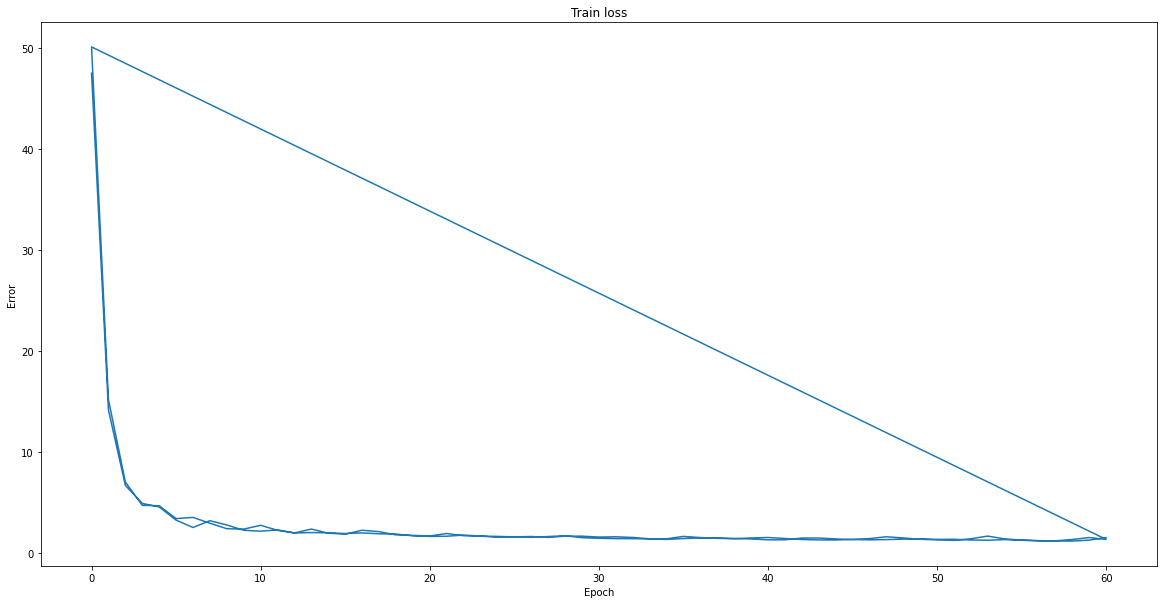

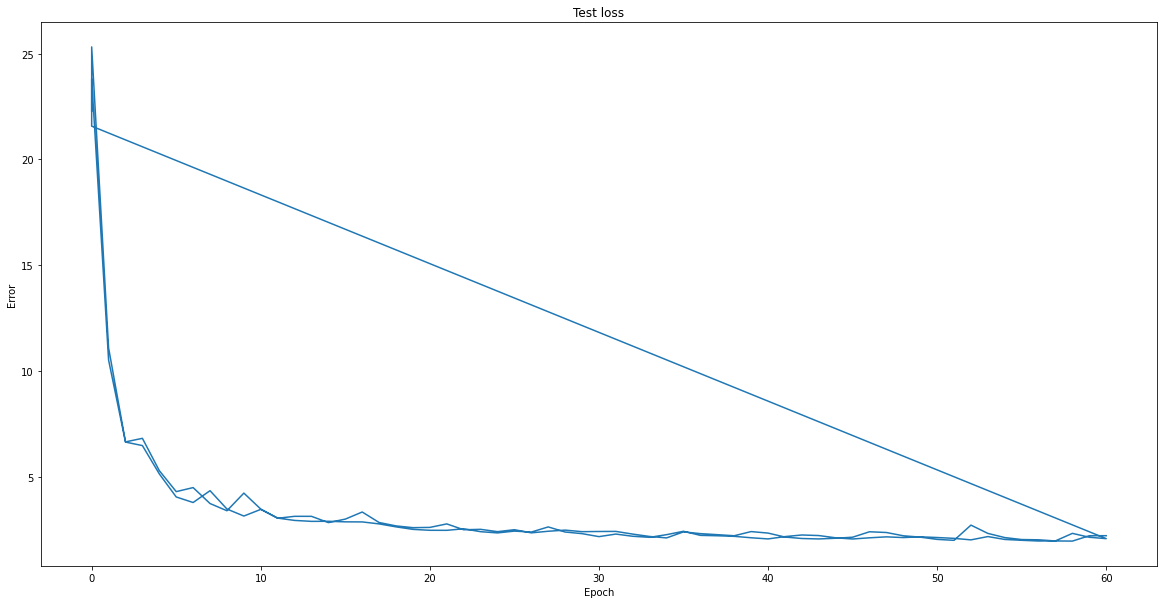

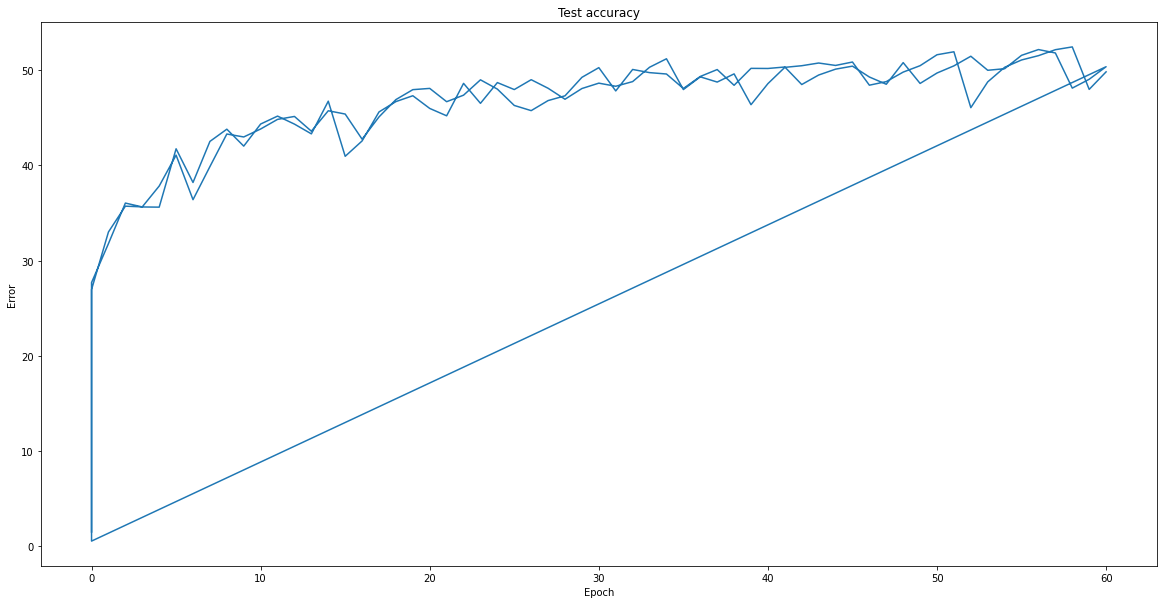

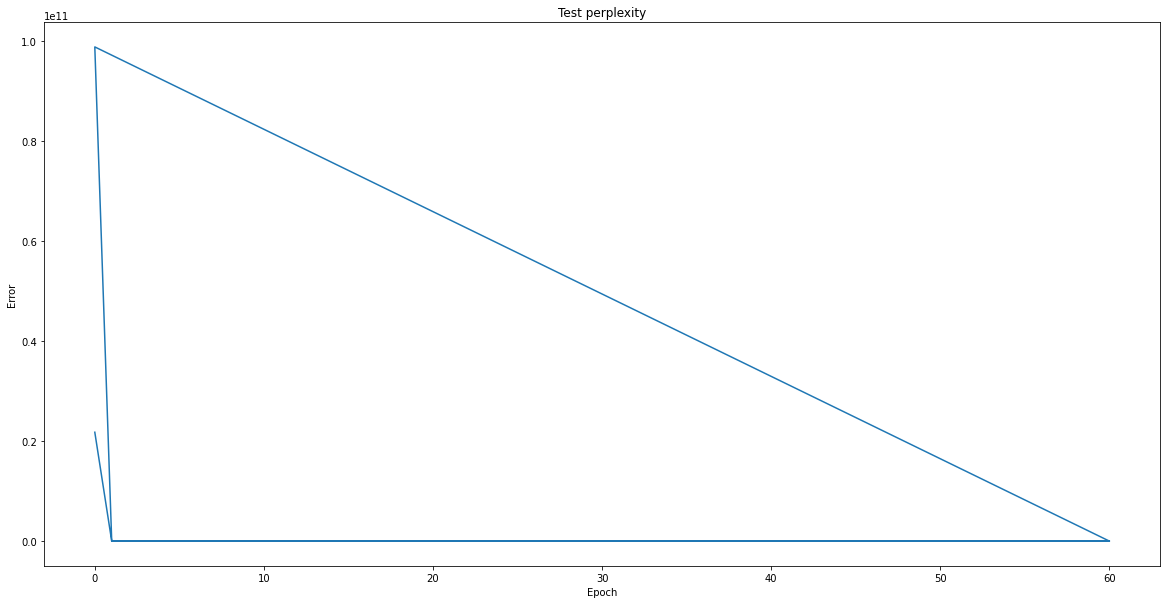

[(0, 21746565181.98062), (1, 37005.70756911645), (2, 766.337278652921), (3, 649.3136674537084), (4, 170.4143030622885), (5, 57.26230471608958), (6, 44.06691621167055), (7, 77.04915841467111), (8, 32.36479845481355), (9, 23.248613121911966), (10, 31.84463730571833), (11, 21.100541080995136), (12, 18.90244574626152), (13, 18.08172199520298), (14, 18.141094325405238), (15, 17.669251640543195), (16, 17.608312458059217), (17, 16.033988248116536), (18, 13.941262468309557), (19, 12.379911694033607), (20, 11.857416751138924), (21, 11.834991378017772), (22, 12.724401948922191), (23, 11.095601166630745), (24, 10.475835922207786), (25, 11.405214540272027), (26, 10.896442904265484), (27, 13.905481727541247), (28, 10.925469025131964), (29, 10.116358334588165), (30, 8.787601702146029), (31, 9.913843562348344), (32, 8.932791069430532), (33, 8.498554370139765), (34, 9.64631035303561), (35, 11.313022556897991), (36, 9.323292248984579), (37, 9.158447688910949), (38, 8.908667442926683), (39, 8.3305002811

In [57]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 60
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log90.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'baskerville_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'baskerville_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    # start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')
    start_epoch = 0

    train_losses, test_losses, test_accuracies, test_perplexities = pt_util.read_log(LOG_PATH, ([], [], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))

            test_perplexities.append((epoch, math.exp(test_loss)))

            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies, test_perplexities))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = ' Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.'
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 90)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        ep, val = zip(*test_perplexities)
        pt_util.plot(ep, val, 'Test perplexity', 'Epoch', 'Error')
        print(test_perplexities)
        return model, vocab, device

final_model, vocab, device = main()

In [56]:
def eval_final_model(model, vocab, device):
    seed_words = 'Harry Potter and the'
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Harry Potter and the country.        “Who was of the conform. When he                                                                                                                                                       
generated with sample	 Harry Potter and the groom of the Sir Charlew out of my with he hospitor.        “Why suppose of a hop of it your pinner. So Lonod of Holmes nat to       your which for of the door. When and          happy faced roselves
generated with sample	 Harry Potter and the groom      for of my friends the loft of myser. Barrymore! Supportrom        mutter into ill Hugo         Barrymore of hours of coments of them        who make       that he coldlocity-cal of cour, s
generated with sample	 Harry Potter and the Barrymore?”        “Did no London’t know of Sir Charles Barrymore out          which of my of his Frang?”        “No Lond?”         “Because conned wrote to spe?”        “How clood for look Egjow you
generated with sample	 Harr

#Part 9: Short answer questions
Please answer these questions, and put the answers in a file called short_answer.pdf in your repository.


1. Just like last time, provide plots for training error, test error, and test accuracy. Also provide a plot of your train and test perplexity per epoch.
    - In class we defined perplexity as `2^(p*log_2(q))`, However the PyTorch cross entropy function uses the natural log. To compute perplexity directly from the cross entropy, you should use `e^p*ln(q)`.
    - We encourage you to try multiple network modifications and hyperparameters, but you only need to provide plots for your best model. Please list the modifications and hyperparameters.    

    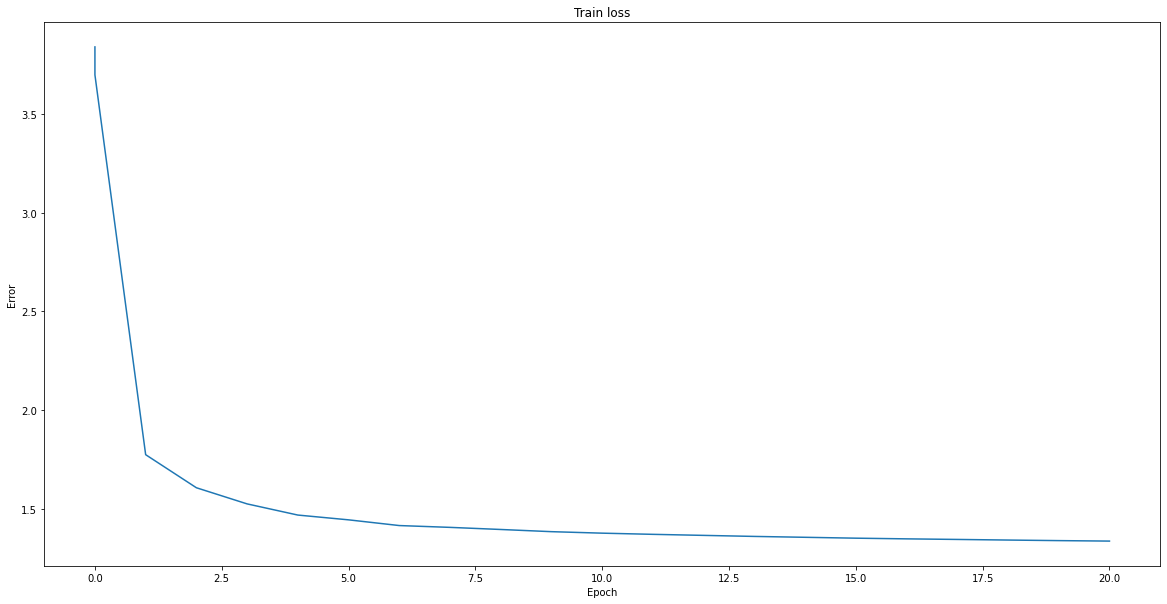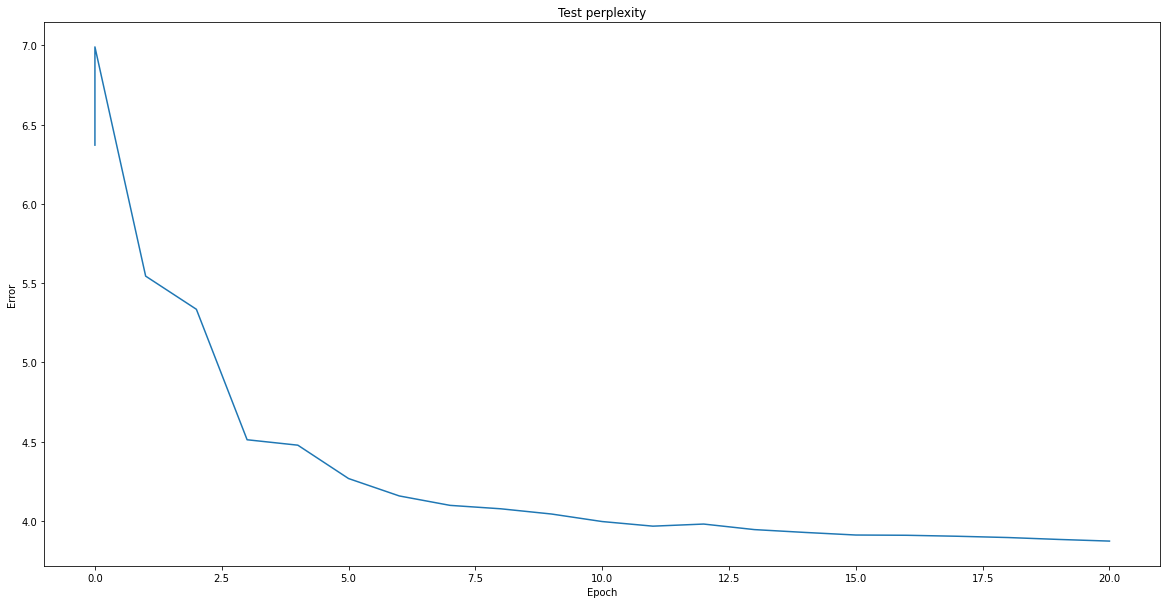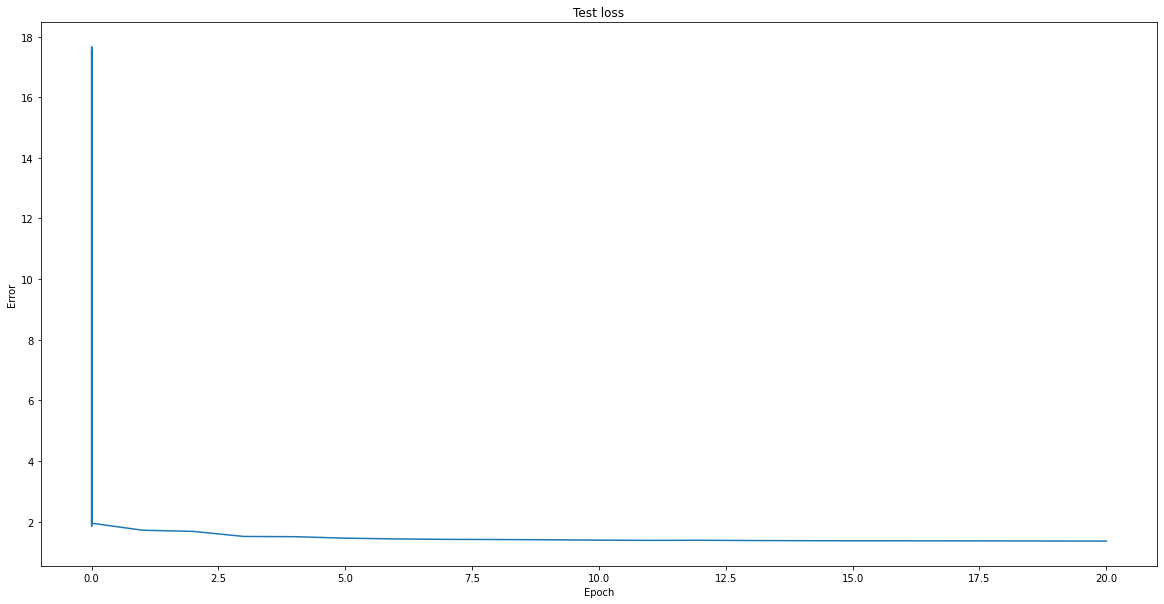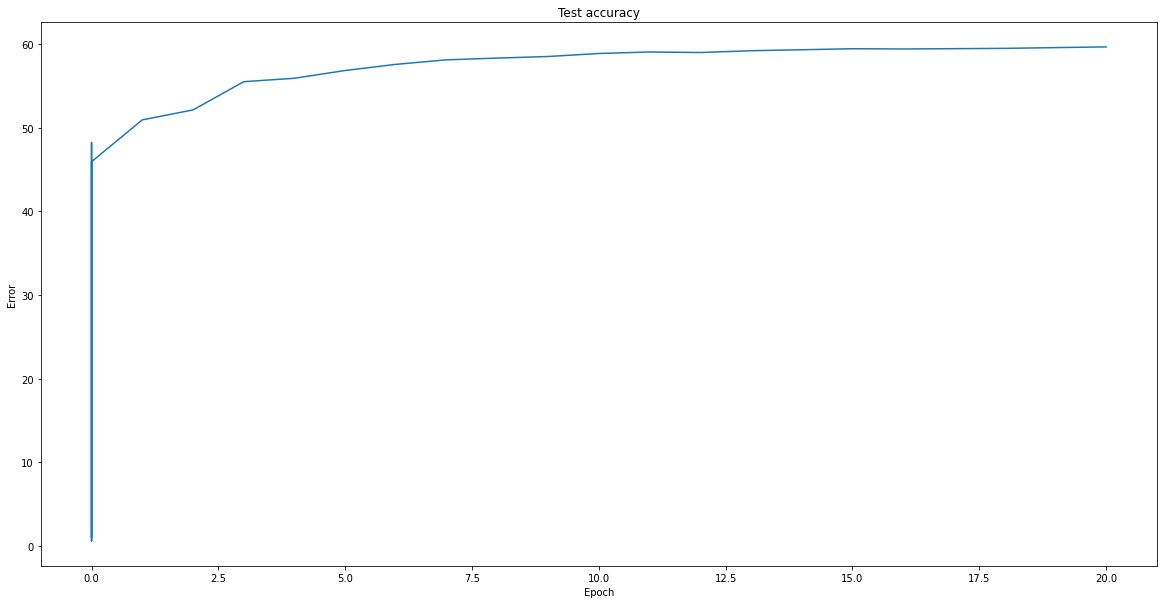



2. What was your final test accuracy? What was your final test perplexity?

Our final test accuracy was 60% and our final perplexity was 3.87

3. What was your favorite sentence generated via each of the sampling methods? What was the prompt you gave to generate that sentence?

To be honest, most of the sentences that were generated were quite poor and made next to no sense, but, our favorite was: 

*pred	" . . .umbledore waroped ahe daok t aoom the cottlm of the ctane sacingand staoed at wnttde tis hobe*


4. Which sampling method seemed to generate the best results? Why do you think that is?

The sampling method that seem to work best was max, which makes intuitive sense as we are finding the maximum proability per character vs. for sample we are trying to creat the most synonomous sentences and with beam its random, both of which make less sense for this type of scenario. 

5. For sampling and beam search, try multiple temperatures between 0 and 2. 
    - Which produces the best outputs? Best as in made the most sense, your favorite, or funniest, doesn't really matter how you decide.

I'd say beam search at around 1.4 was the best, as the results were quite funny and made absolutely no sense whatsover (leading to a large laughing fit for a couple minutes between the two of us haha). 

- What does a temperature of 0 do? What does a temperature of 0<temp<1 do? What does a temperature of 1 do? What does a temperature of above 1 do? What would a negative temperature do (assuming the code allowed for negative temperature)?

From an intuitive understanding, I think the temperature helps dictate the similarity level between the activation function at play and a softmax. For example, if the temperature is a 0, we know that the activation function act like a max argument, vs. if a temperature were 1 it is just a softmax. Anything between there is a gradient, with it getting closer to a softmax as we increase the value.  

    

    


Questions for each of the "Other things" sections. Only answer the questions corresponding to the ones you chose.

1. New Corpus
    1. What corpus did you choose? How many characters were in it?
    2. What differences did you notice between the sentences generated with the new/vs old corpus.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).


We used the Sherlock Holmes story about Baskerville as our corpus with a 373569 characters. The sentences produced from the first corpus were very similar as output from the second corups, although the ones from the first corpus seemed to be a little more comprhendable and felt like english. The second corpus also seemed to have a lot of additional characters that we didn't see in the first one. 

This was our output: 

*een ne ooose ,tneund whet haastgegar mate         “yot Hanratgyond whs tn tir if  cu  and ti*





1. New Architecture
    1. What was your design? What did you try that didn't work well?
    2. What was your lowest test perplexity? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

Our design was a small iterative change from the original network, with an added linear layer, and an increased width. We tried adding multiple linear layers as well as different activations after the GRU, but that always seemed to produce a lower quality output. We ended up increasing the width of our network instead, by doublinng the input size of the GRU layer. 

The lowest test perplexity was 9.18, and the following are the respective plots. 

### AD PLTOS
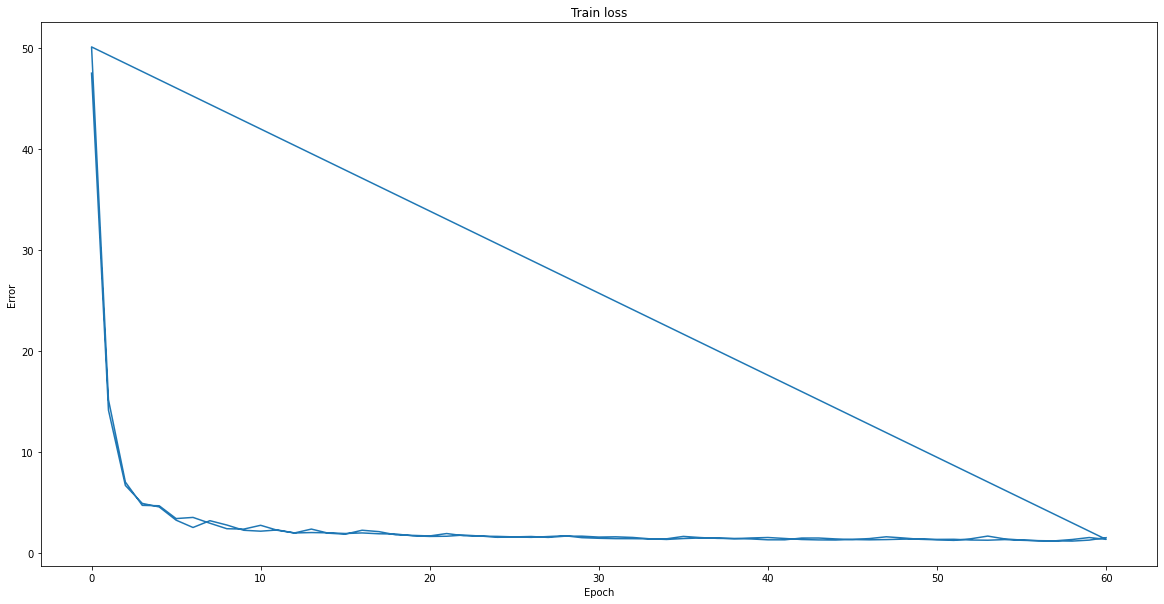

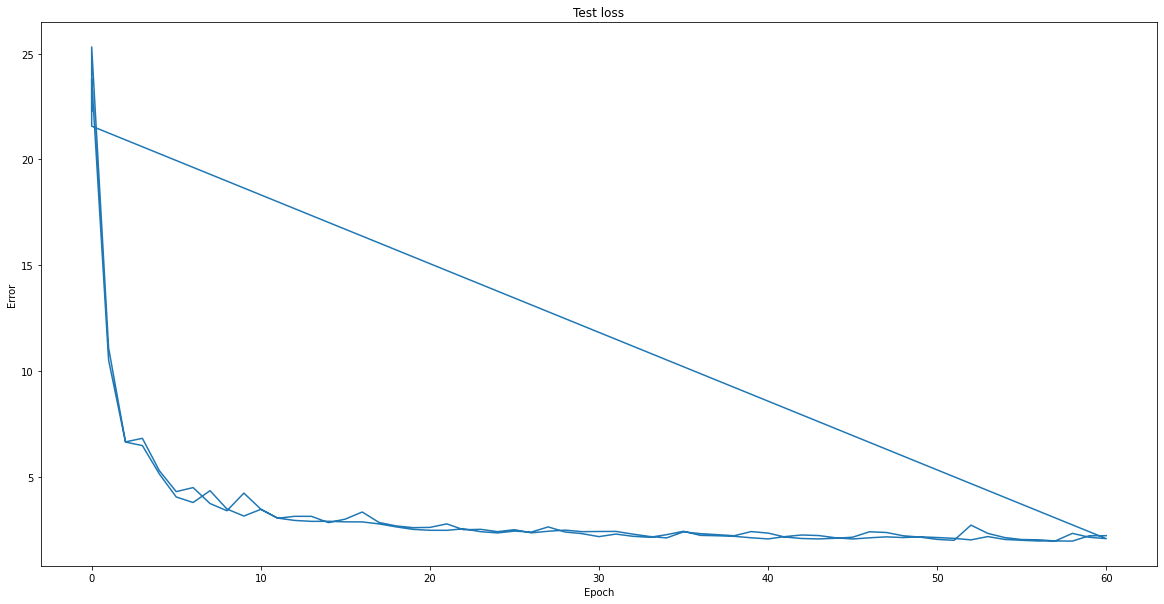

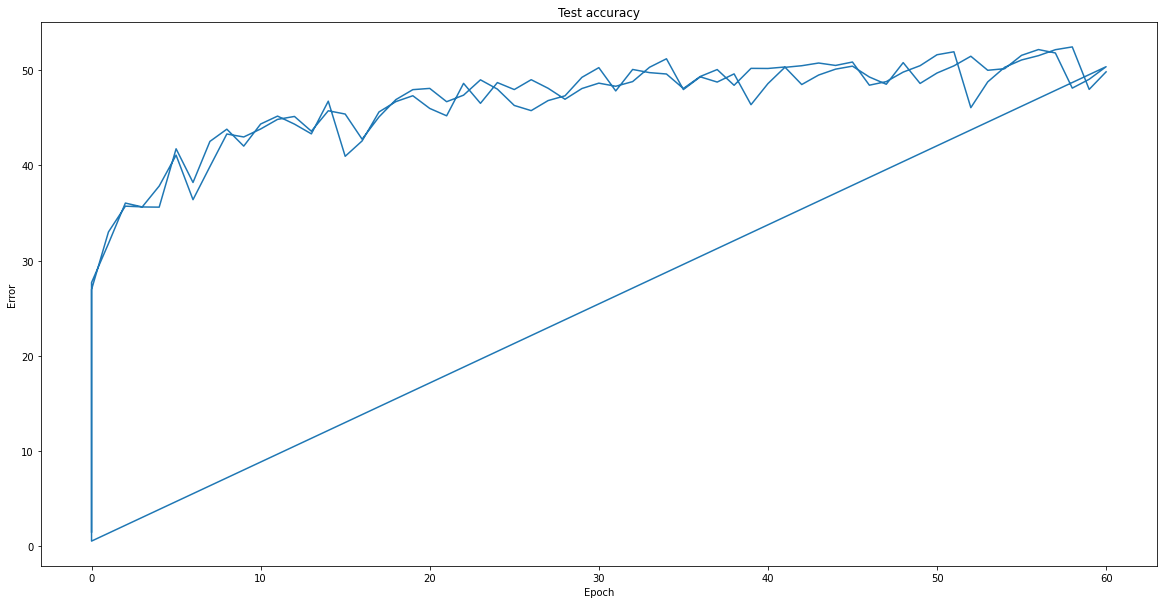

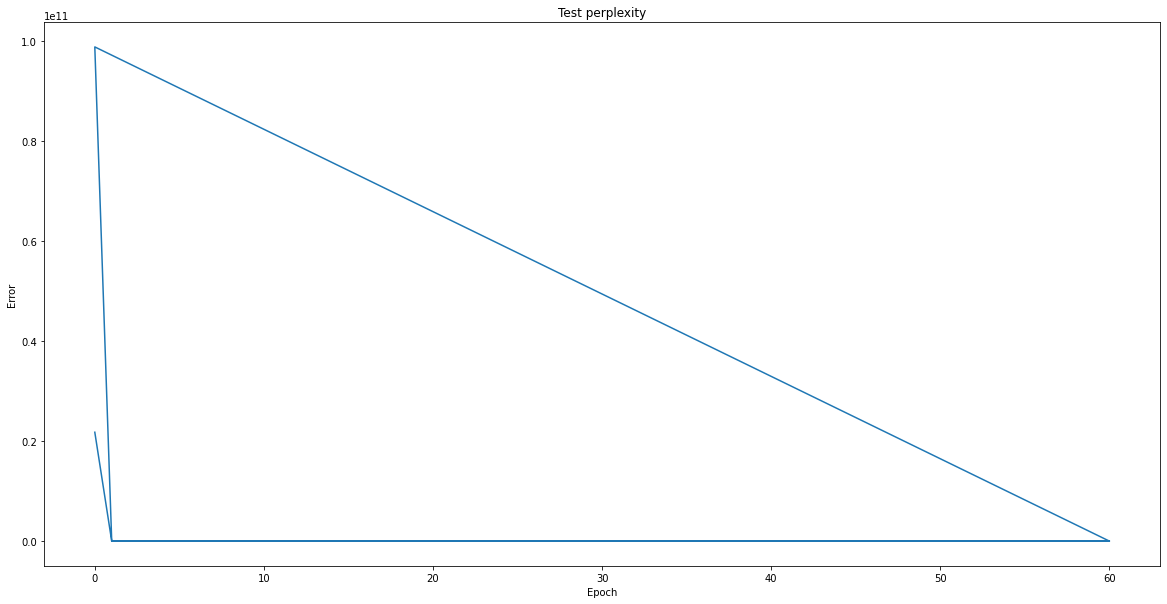

generated max:

Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.         “Well, I not it is        the natural, I       could not          for here, have seen he sant, or                                                                                            

generated sample:
	  Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.         “We happy it incidents which with        coming it      public for         slopeful you       use of scholess, sir?”         “My friends for he ware and value of Baskerville whick I       cou

generated beam:
Mr. Sherlock Holmes, who was usually very late in the mornings,save upon those not infrequent occasions when he was up all night, was seated at the breakfast table.       “Your, Miss Stapleton       Lonshining cried or dinner; but        upon         I was      the others, whenty you have.        Iff you heard       by heard I dony of Sir        Chaire cry of we



1. LSTM
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

We didn't run into many if any difficuluties while training the LSTM instead of the GRU. The results were slightly worse, as visible in the plots below, but thats it. 

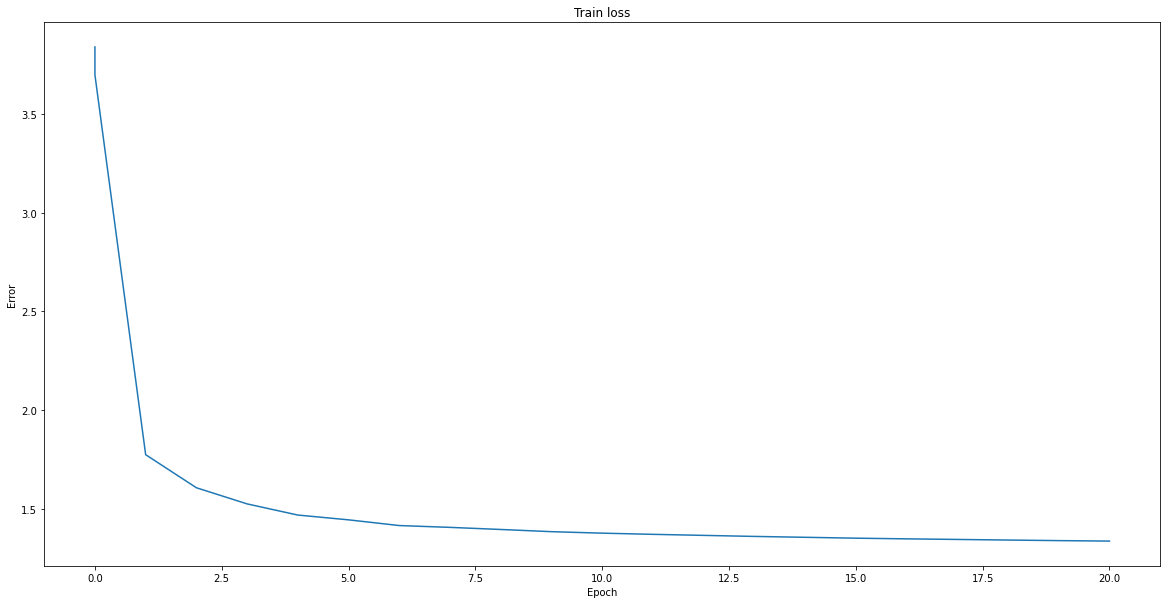

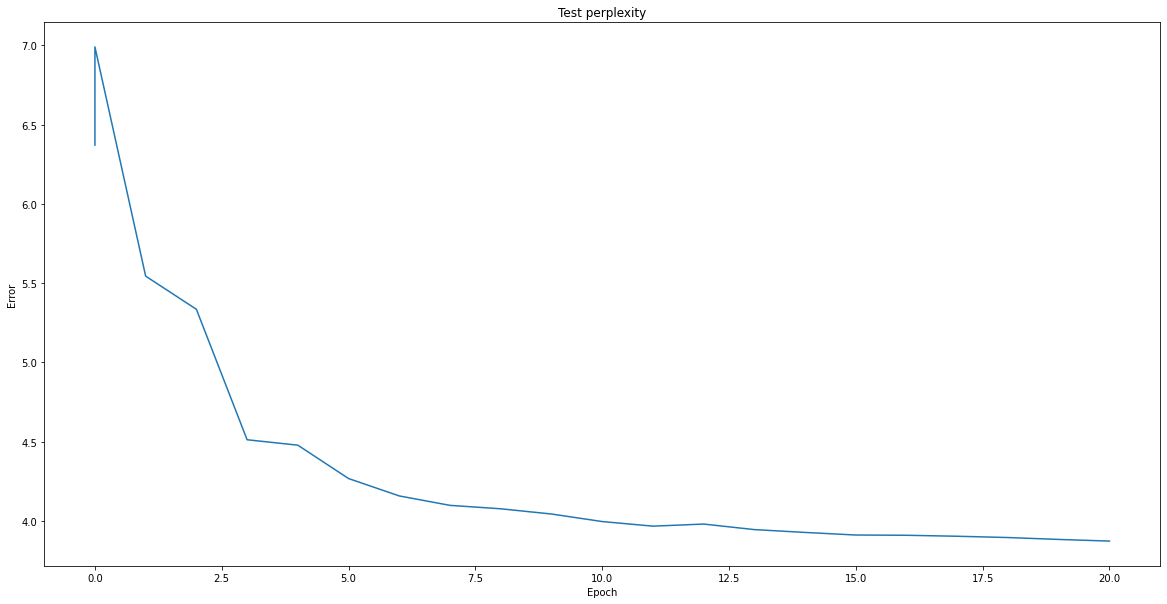


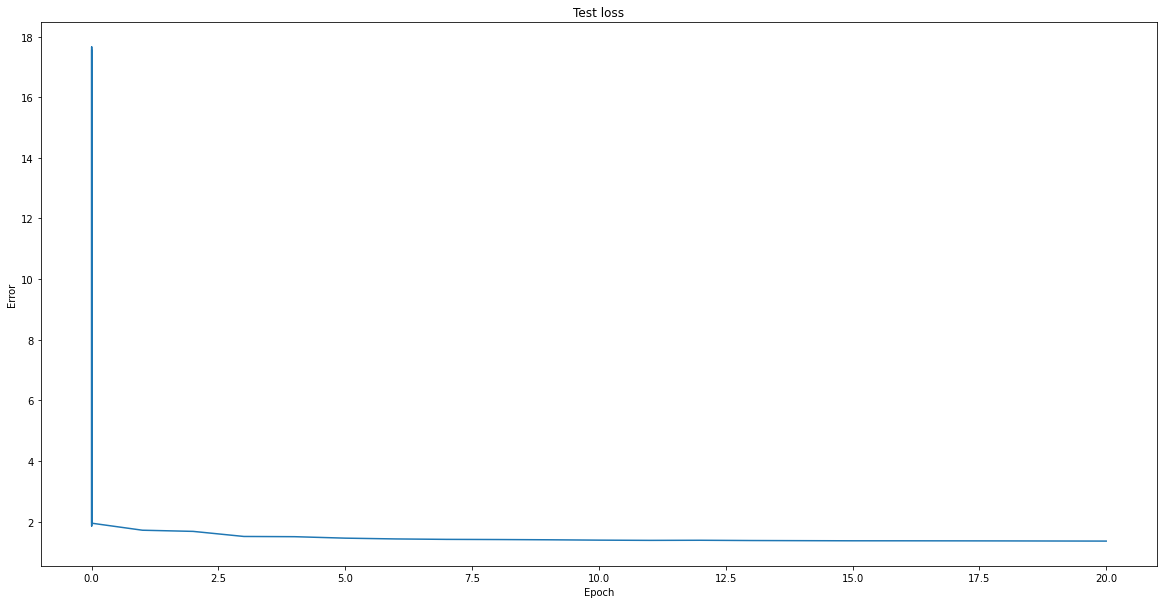

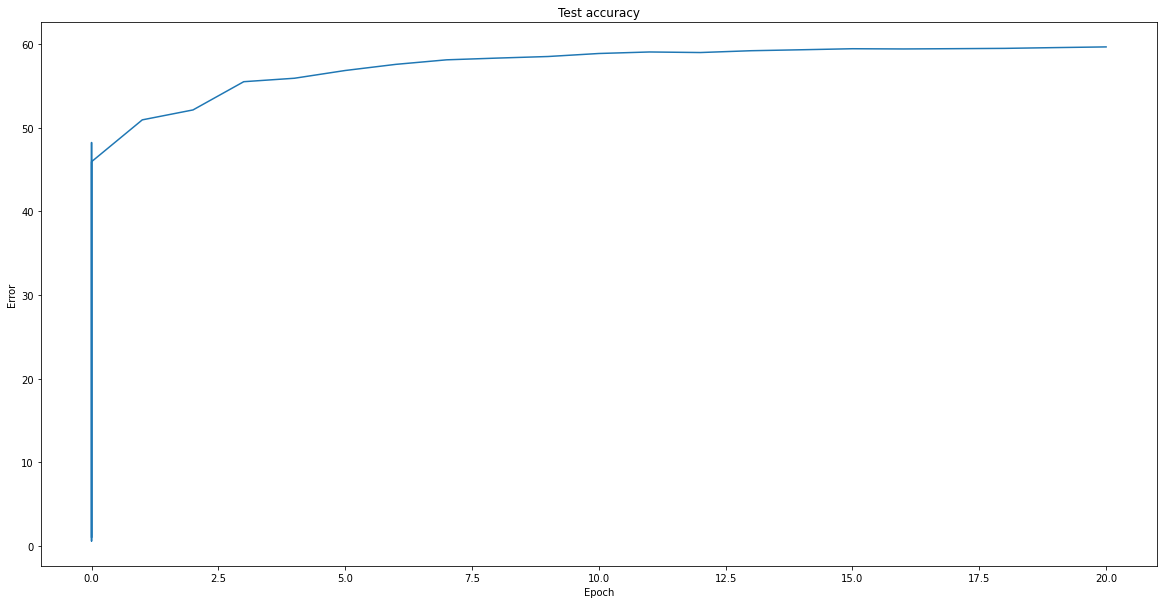

Example output: 

Max:
 generated with max	 Harry Potter and the country.        “Who was of the conform. When he                                                                              

Sample: 
generated with sample	 Harry Potter and the groom of the Sir Charlew out of my with he hospitor.        “Why suppose of a hop of it your pinner. So Lonod of Holmes nat to       your which for of the door. When and          happy faced roselves

Beam: 
generated with beam	 Harry Potter and thereforem an        I rollowed every eyel had to read of the circoduct of courself. Sur friend down why       head out of the family. For the commuty when your Coom of Lafter recllect       likel which 
